In [26]:
import numpy as np
import matplotlib.pyplot as plt
import math, os, functools
import random
import cv2, sys
import matplotlib
from tqdm import tqdm

plt.rcParams['figure.figsize'] = [15, 5]
font = {'family' : 'consolas',
        'weight' : 'bold',
        'size'   : 18}
matplotlib.rc('font', **font)


# RGB Coordinates
RED   = (255,  0,  0)
GREEN = (  0,255,  0)
BLUE  = (  0,  0,255)
WHITE = (255,255,255)


In [2]:
def MorsePotential(r,**kwargs):
    
    defaults = { "a":3,"De":2,"re":1 }
    kwargs   = {**defaults,**kwargs} 
    
    a  = kwargs["a"]
    De = kwargs["De"]
    re = kwargs["re"]
    
    return De*( np.exp(-2*a*(r-re)) - 2*np.exp(-a*(r-re)) )

def PeriodicMorseForce(Particle1,Particle2,**kwargs):
    
    defaults = { "a":3,"De":2,"re":1 }
    kwargs   = {**defaults,**kwargs} 
    
    a  = kwargs["a"]
    De = kwargs["De"]
    re = kwargs["re"]
    
    R = BIB(Particle1.Pos - Particle2.Pos)

    r  = np.sqrt(R*R)
    ur = (1/r)*R 
    return (2*De*a*( np.exp(-2*a*(r-re)) - np.exp(-a*(r-re))))*ur


def MorseForce(Particle1,Particle2,**kwargs):
    
    defaults = { "a":3,"De":2,"re":1 }
    kwargs   = {**defaults,**kwargs} 
    
    a  = kwargs["a"]
    De = kwargs["De"]
    re = kwargs["re"]
    
    R = Particle1.Pos - Particle2.Pos
    
    r  = np.sqrt(R*R)
    ur = (1/r)*R 
    return (2*De*a*( np.exp(-2*a*(r-re)) - np.exp(-a*(r-re))))*ur


def ElectricForce(Particle1,Particle2):
    
    # 4pi\epsilon_0 = 1
    # |qe|          = 1
    # me            = 1
    k = 1
    
    # R is a Vector
    R  = Particle1.Pos - Particle2.Pos
    
    # R*R is the scalar product so it is a number
    r  = np.sqrt(R*R)
    
    # Normal Vector
    ur = (1./r)*R 
    
    # k q1 *q2 / r^2 ur -> Coulombs Law + Van-der Walls
    return (k*Particle1.charge*Particle2.charge/(r*r))*ur #+ (0/(r*r*r))*ur

def LorentzForce(particle,**kwargs):
    if isinstance(particle,ChargedParticle):
        E = (particle.charge)*kwargs["E"]
        B = (particle.charge)*kwargs["B"]
        V  = particle.Vel
        return ( E + (V @ B) )
    else:
        return Vector(0,0,0)
    
def Monopole(particle,**kwargs):
    location = kwargs["location"]
    m_charge = kwargs["m_charge"]
    e_cahrge = kwargs["e_charge"]
    
    position = particle.Pos - location
    
    mu0_over_4pi    = 1
    one_over_4piep0 = 1
    
    r  = np.sqrt(position*position)
    ur = (1./r)*position
    hr = (1./(r*r))*ur
    
    B = (mu0_over_4pi    * m_charge) * hr
    E = (one_over_4piep0 * e_cahrge) * hr
    
    return LorentzForce(particle,E=E,B=B)   

In [3]:
class Vector:

    '''
    3-Dimensional Vector
    
    Holds 3 numbers and all the operators associated 
    with the algebraic manipulations of Vectors in 3D
    
    '''
    
    # Declare a Vector
    def __init__(self,x,y,z):
        self.x = x
        self.y = y
        self.z = z
    
    # Addition
    def __add__(self,other):
        return Vector(self.x+other.x,self.y+other.y,self.z+other.z)
    
    # Subtraction
    def __sub__(self,other):
        return Vector(self.x-other.x,self.y-other.y,self.z-other.z)
    
    # Inner Product
    @functools.singledispatchmethod
    def __mul__(self, other):
        return (self.x*other.x + self.y*other.y+self.z*other.z)
    
    # Multiplication by Scalar
    @__mul__.register(float)
    def _(self,other):
        return Vector(other*self.x,other*self.y,other*self.z)
    
    # Reversed Inner Product
    @functools.singledispatchmethod
    def __rmul__(self, other):
        return (self.x*other.x + self.y*other.y+self.z*other.z)
    
    # Reversed Scalar Multiplication
    @__rmul__.register(float)
    def _(self,other):
        return Vector(self.x*other,self.y*other,self.z*other)
    
    # Cross Product
    def __matmul__(self,other):
        return Vector(self.y*other.z-self.z*other.y,self.z*other.x-self.x*other.z,self.x*other.y-self.y*other.x)
    
    # Print Statement
    def __str__(self):
        return "("+str(self.x)+","+str(self.y)+","+str(self.z)+")"

    def GetTheta(self):
        return np.arctan2(self.y,self.x)
    

In [4]:
def BIB(R,lx=10,ly=10,lz=10):
    if  abs(R.x) > lx:
         R.x =  (R.x**2 - abs(R.x)*2*lx)/R.x
    if  abs(R.y) > ly:
         R.y =  (R.y**2 - abs(R.y)*2*ly)/R.y
    if  abs(R.z) > lz:
         R.z =  (R.z**2 - abs(R.z)*2*lz)/R.z
    return R

class Particle:
    
    '''
    Particles for the Simulator
    They hold kinematical variables: Position, Velocity and Acceleration
    And the trajectory of the particle, the time should be managed externally.
    
    '''
    
    # Syntax of Constructor 
    # Convention python "def" "any_name"(pass_the_name_of_obejct,maybe_some_args):
    def __init__(self,Name,Mass,Position,Velocity,Color):
        self.Nam = Name
        self.Mas = Mass
        self.Pos = Position
        self.Vel = Velocity
        self.Acc = Vector(0.,0.,0.)
        self.Col = Color
        self.TPos = []
        self.TVel = []
        self.TAcc = []

        self.IniPos = self.Pos
        self.IniVel = self.Vel
        self.IniAcc = self.Acc
    
    # One of the functions of the class
    def RemoveLastTrack(self):
        
        for i in range(3):
            del self.Tra[i][-1]

    def ClearTrajectory(self):
        self.TPos = []
        self.TVel = []
        self.TAcc = []
        self.Pos = self.IniPos
        self.Vel = self.IniVel
        self.Acc = self.IniAcc
        
    # Function that moves the particle in time according to its speed: 
    
    # self -> Actual Particle
    # dt   -> dt of the evolution
    
    # dPostion/dt = Velocity 
    # dVelocity/dt = Acceleration 
    
    
    def Evolve(self,dt,Omega=Vector(0.,0.,0.),Method="Euler"):
        
        if Method == "Euler":
            # dPosition = dt*Velocity
            self.Pos = self.Pos + self.Vel * dt
            
            # dVelocity = dt*Acceleration
            self.Vel = self.Vel + self.Acc * dt
        
        if Method == "Euler-Cromer":
            # dVelocity = dt*Acceleration
            self.Vel = self.Vel + self.Acc * dt
        
            # dPosition = dt*Velocity
            self.Pos = self.Pos + self.Vel * dt
        
        else: # Verlet 
            # Following: https://en.wikipedia.org/wiki/Verlet_integration
            # Section: Basic Störmer–Verlet
            if len(self.TPos) < 2:
                self.Pos += self.Vel * dt + 0.5*self.Acc*dt**2
            else:
                self.Pos = 2.0*self.TPos[-1] - self.TPos[-2] + self.Acc*dt**2
        
        # Record the Trajectory
        self.TPos.append(self.Pos)
        self.TVel.append(self.Vel)

class ChargedParticle(Particle):
    
    def __init__(self,Name,Mass,Charge,Position,Velocity,Color):
        super().__init__(Name,Mass,Position,Velocity,Color)
        self.charge = Charge
        
class periodic(Particle): 
    
    def Evolve(self,dt,Omega=Vector(0.,0.,0.),Method="Euler-Cromer"):
        
        if Method == "Euler":
            # dPosition = dt*Velocity
            self.Pos = self.Pos + self.Vel * dt
            
            # dVelocity = dt*Acceleration
            self.Vel = self.Vel + self.Acc * dt
        
        if Method == "Euler-Cromer":
            # dVelocity = dt*Acceleration
            self.Vel = self.Vel + self.Acc * dt
        
            # dPosition = dt*Velocity
            self.Pos = self.Pos + self.Vel * dt
        
        else: # Verlet 
            # Following: https://en.wikipedia.org/wiki/Verlet_integration
            # Section: Basic Störmer–Verlet
            
            LastAcc = (self.TAcc[-1]if len(self.TAcc)else Vector(0,0,0))
            
            self.Pos = self.Pos + self.Vel * dt + LastAcc *(0.5*dt**2)
            
            self.Vel = self.Vel + ( self.Acc + LastAcc) * (0.5*dt)
        
        self.Pos = BIB(self.Pos)
            
        # Record the Trajectory
        self.TPos.append(self.Pos)
        self.TVel.append(self.Vel)
        self.TAcc.append(self.Acc)
        

# Unmovable Particles
class Stationary(ChargedParticle):
    # These do not move
    def Evolve(self,dt,Omega=Vector(0.,0.,0.)):
        self.TPos.append(self.Pos)

# Charged Particle on a Torus
class PChargedParticle(ChargedParticle): 
    
    def Evolve(self,dt,Omega=Vector(0.,0.,0.)):
        
        # dVelocity = dt*Acceleration
        self.Vel = self.Vel + self.Acc * dt
        
        # dPosition = dt*Velocity
        self.Pos = self.Pos + self.Vel * dt 
        
        self.Pos = BIB(self.Pos)
            
        # Record the Trajectory
        self.TPos.append(self.Pos)
        self.TVel.append(self.Vel)

In [27]:
class Simulator:
    
    '''
    
    Deals with Time management and Interactions
    Democratic treatment of all particles

    
    '''
    def __init__(self,**kwargs):
        self.Velocity    = Vector(0,0,0)
        self.Omega       = Vector(0,0,0)
        self.Particles   = kwargs["Particles"]
        self.Interaction = kwargs["Interaction"]
        self.External    = kwargs["External"]
        self.Time        = []
        
    def Simulate(self,Time,Steps):
        
        # Simulation Environment 
        # Computes force on all particles
        
        t = 0
        dt = Time/Steps
        for _ in tqdm(range(Steps)):
        
        #while t < Time:
            #print("Working on:",t)
            #t += dt
            
            # Compute the forces on each particle and modify the 
            # particle's acceleration accordingly
            for i, Particle1 in enumerate(self.Particles):
                # Compute the total force on particle i
                Acc = self.External(Particle1)
                for j, Particle2 in enumerate(self.Particles):
                    # Compute the contribution to the force on particle i from particle j
                    # Skip slef interactions
                    if i == j: 
                        continue
                    # Compute force and acceleration & set the accelerations
                    Acc = Acc + self.Interaction(Particle1,Particle2)
                Particle1.Acc = (1.0/Particle1.Mas)*Acc
            # Time Evolution, this is handled by particles themselves
            for Particle in self.Particles:
                Particle.Evolve(dt,self.Omega)
        
    def GeneratePlots(self,mode="Show"):
        
        plt.clf()
        plt.title("Trajectories")
        for Particle in self.Particles:
            x = [ P.x for P in Particle.TPos ]
            y = [ P.y for P in Particle.TPos ]
            plt.plot(x,y,label=Particle.Nam)
        plt.legend(loc="best")
        if(mode=="Show"):
            plt.show()
        elif (mode=="Save"):
            plt.savefig("Trajectories.png")

    def ClearTrajectories(self):
        for Particle in self.Particles:
            Particle.ClearTrajectory()

In [6]:
class Camera:
    def __init__(self,**kwargs):
        pars = {"Distance":1,"Orientation":Vector(0,0,-1),"Position":Vector(0,0,10)}
        pars.update(**kwargs)
        self.Orientation = pars["Orientation"] # Vector Normal to the plane
        self.Position    = pars["Position"]    # Location of the camera
        self.Distance    = pars["Distance"]    # Distance from the camera to the screeen (in the direction of "Orientation")
        
        r_trans          = np.sqrt(self.Orientation.x**2+self.Orientation.y**2)
        # Local Coordinates on the plane
        self.u_theta     = Vector(-self.Orientation.y/r_trans,self.Orientation.x/r_trans,0)
        self.u_phi       = Vector(self.Orientation.x*self.Orientation.z/r_trans,
                                  self.Orientation.y*self.Orientation.z/r_trans,
                                  -r_trans)
    def Convert(self,Position):
        r     = Position - self.Position
        Proj  = self.Orientation*r
        rscal = ( r * (self.Distance/Proj) if Proj > 0 else Vector(0,0,0) )
        return Vector(self.u_theta*rscal,self.u_phi*rscal,0)

class VideoGenerator:

    def __init__(self,VideoName,Particles,Camera):
        self.Name       = VideoName
        self.Particles  = Particles
        self.Width      = 2000
        self.Height     = 2000
        self.Channels   = 3
        self.framerate  = 30
        self.Padding    = 0.05
        self.Camera     = Camera
    
    def GetRanges(self): 
        
        xMin = self.Camera.Convert(self.Particles[0].TPos[0]).x
        xMax = self.Camera.Convert(self.Particles[0].TPos[0]).x
        yMin = self.Camera.Convert(self.Particles[0].TPos[0]).y
        yMax = self.Camera.Convert(self.Particles[0].TPos[0]).y
        for iFrame in range(len(self.Particles[0].TPos)):
            for particle in self.Particles:
                xMin = min(self.Camera.Convert(particle.TPos[iFrame]).x,xMin)
                xMax = max(self.Camera.Convert(particle.TPos[iFrame]).x,xMax)
                yMin = min(self.Camera.Convert(particle.TPos[iFrame]).y,yMin)
                yMax = max(self.Camera.Convert(particle.TPos[iFrame]).y,yMax)
        return [xMin,xMax] , [yMin,yMax] 

    def Generate(self,show_every=1):
        
        xRange , yRange = self.GetRanges()
        
        print(xRange,yRange)

        xRange[0] -= self.Padding*(xRange[1]-xRange[0])
        xRange[1] += self.Padding*(xRange[1]-xRange[0])
        yRange[0] -= self.Padding*(yRange[1]-yRange[0])
        yRange[1] += self.Padding*(yRange[1]-yRange[0])

        def GetPixel(X,Y):
            x = int((self.Width *float(X - xRange[0]))/(xRange[1]-xRange[0])//1)
            y = int((self.Height*float(Y - yRange[0]))/(yRange[1]-yRange[0])//1)
            return x,y


        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        video  = cv2.VideoWriter(self.Name+".mp4", fourcc, float(self.framerate), (self.Width, self.Height))
    
        num_frames = len(self.Particles[0].TPos)

        print("Generating Video for:",self.Name)        
        for frame_count in range(num_frames):
            
            if frame_count % show_every:
                continue

            sys.stdout.write('\r')
            sys.stdout.write("%d%% : [%-1s] " % ( (100/num_frames)*frame_count,'='*int((float(50*frame_count)/num_frames)//1)))
            sys.stdout.flush()
            
            frame = np.zeros((self.Height,self.Width,self.Channels), dtype=np.uint8)
            for particle in self.Particles:
                x,y = GetPixel(self.Camera.Convert(particle.TPos[frame_count]).x,
                               self.Camera.Convert(particle.TPos[frame_count]).y)
                for xC in range(10):
                    for yC in range(10):
                        for rbg in range(self.Channels):
                            frame[self.Height-(y+yC-5)][(x+xC-5)][rbg] = particle.Col[rbg]
            video.write(frame)
        print()
 
        video.release()

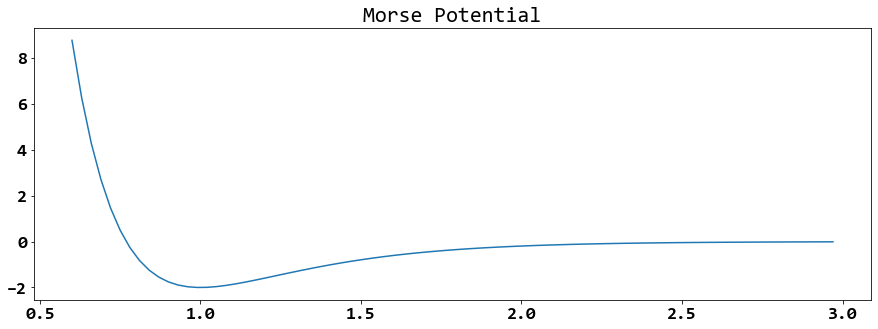

In [7]:
#Q1

granularity = 100
x_axis = [ (3*i)/granularity for i in range(20,granularity) ]
y_axis = [ MorsePotential(i) for i in x_axis ]

plt.title("Morse Potential")
plt.plot(x_axis,y_axis)
plt.show()

Working on: 0
Working on: 0.01464
Working on: 0.02928
Working on: 0.04392
Working on: 0.05856
Working on: 0.0732
Working on: 0.08784
Working on: 0.10248
Working on: 0.11712
Working on: 0.13176
Working on: 0.14639999999999997
Working on: 0.16103999999999996
Working on: 0.17567999999999995
Working on: 0.19031999999999993
Working on: 0.20495999999999992
Working on: 0.2195999999999999
Working on: 0.2342399999999999
Working on: 0.24887999999999988
Working on: 0.26351999999999987
Working on: 0.27815999999999985
Working on: 0.29279999999999984
Working on: 0.3074399999999998
Working on: 0.3220799999999998
Working on: 0.3367199999999998
Working on: 0.3513599999999998
Working on: 0.36599999999999977
Working on: 0.38063999999999976
Working on: 0.39527999999999974
Working on: 0.40991999999999973
Working on: 0.4245599999999997
Working on: 0.4391999999999997
Working on: 0.4538399999999997
Working on: 0.4684799999999997
Working on: 0.48311999999999966
Working on: 0.49775999999999965
Working on: 0.512

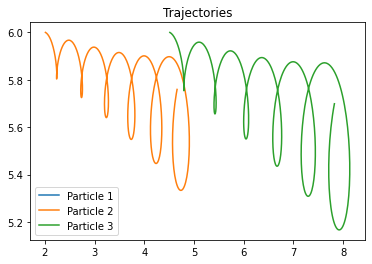

[0.7111332858126549, 2.658503034566471] [3.137863998891567, 4.0]
Generating Video for: Lorentz
99% : [=================================================] 


In [8]:
p1 = Vector(3.5,6,0)
p2 = Vector(2,6,0)
p3 = Vector(4.5,6,0)

# Velocity Vectors
v1 = Vector(0,0,0)
v2 = Vector(0.4,0,0)
v3 = Vector(0.5,0,0)

# Particle objects 
p1 = ChargedParticle("Particle 1",1.,1.,p1,v1,RED)
p2 = ChargedParticle("Particle 2",1.,1.,p2,v2,BLUE)
p3 = ChargedParticle("Particle 3",1.,1.,p3,v3,GREEN)

LorentzSimulator = Simulator(
                             Particles = [p1,p2,p3],
                             Interaction = lambda p1,p2 : Vector(0,0,0),
                             External    = lambda p : LorentzForce(p,E=Vector(0,0,0),B=Vector(0,0,5))
                            )

LorentzSimulator.Simulate(7.32,500)
LorentzSimulator.GeneratePlots()

# Generate the Video
C  = Camera(Position=Vector(0,0,10),Orientation=Vector(0,-1/np.sqrt(2),-1/np.sqrt(2)))
VG = VideoGenerator("Lorentz",LorentzSimulator.Particles,C)
VG.Generate(show_every=1)

In [9]:
# Q2 Perform the following simulation. Let the initial position of particle 1 be
# (7.0, 6.0, 0.0) and that it is resting there. Let particle 2 have initial velocity (0.4, 0.0, 0.0)
# and initial position (2.0, 6.0, 0.0). Take dt = 0.01 and run about 10,000 steps.

dt = 0.001     # Energy is conserved as dt -> 0
steps = 100000

# Position Vector 

p1 = Vector(7.,6.,0)
p2 = Vector(2.,6.,0)

# Velocity Vectors

v1 = Vector(0.0,0.1,0)
v2 = Vector(0.4,0.1,0)

# Particle objects 
p1 = periodic("Particle 1",1.,p1,v1,RED)
p2 = periodic("Particle 2",1.,p2,v2,BLUE)

MorseSimulator = Simulator(Particles   = [p1,p2],
                           Interaction = lambda p1,p2 : PeriodicMorseForce(p1,p2,De=2,a=3,re=1),
                           External    = lambda p1    : Vector(0,0,0))

MorseSimulator.Simulate(steps*dt,steps)

Working on: 0
Working on: 0.001
Working on: 0.002
Working on: 0.003
Working on: 0.004
Working on: 0.005
Working on: 0.006
Working on: 0.007
Working on: 0.008
Working on: 0.009000000000000001
Working on: 0.010000000000000002
Working on: 0.011000000000000003
Working on: 0.012000000000000004
Working on: 0.013000000000000005
Working on: 0.014000000000000005
Working on: 0.015000000000000006
Working on: 0.016000000000000007
Working on: 0.017000000000000008
Working on: 0.01800000000000001
Working on: 0.01900000000000001
Working on: 0.02000000000000001
Working on: 0.02100000000000001
Working on: 0.022000000000000013
Working on: 0.023000000000000013
Working on: 0.024000000000000014
Working on: 0.025000000000000015
Working on: 0.026000000000000016
Working on: 0.027000000000000017
Working on: 0.028000000000000018
Working on: 0.02900000000000002
Working on: 0.03000000000000002
Working on: 0.03100000000000002
Working on: 0.03200000000000002
Working on: 0.03300000000000002
Working on: 0.034000000000

Working on: 0.36400000000000027
Working on: 0.36500000000000027
Working on: 0.36600000000000027
Working on: 0.36700000000000027
Working on: 0.36800000000000027
Working on: 0.36900000000000027
Working on: 0.3700000000000003
Working on: 0.3710000000000003
Working on: 0.3720000000000003
Working on: 0.3730000000000003
Working on: 0.3740000000000003
Working on: 0.3750000000000003
Working on: 0.3760000000000003
Working on: 0.3770000000000003
Working on: 0.3780000000000003
Working on: 0.3790000000000003
Working on: 0.3800000000000003
Working on: 0.3810000000000003
Working on: 0.3820000000000003
Working on: 0.3830000000000003
Working on: 0.3840000000000003
Working on: 0.3850000000000003
Working on: 0.3860000000000003
Working on: 0.3870000000000003
Working on: 0.3880000000000003
Working on: 0.3890000000000003
Working on: 0.3900000000000003
Working on: 0.3910000000000003
Working on: 0.3920000000000003
Working on: 0.3930000000000003
Working on: 0.3940000000000003
Working on: 0.3950000000000003
Wo

Working on: 0.7490000000000006
Working on: 0.7500000000000006
Working on: 0.7510000000000006
Working on: 0.7520000000000006
Working on: 0.7530000000000006
Working on: 0.7540000000000006
Working on: 0.7550000000000006
Working on: 0.7560000000000006
Working on: 0.7570000000000006
Working on: 0.7580000000000006
Working on: 0.7590000000000006
Working on: 0.7600000000000006
Working on: 0.7610000000000006
Working on: 0.7620000000000006
Working on: 0.7630000000000006
Working on: 0.7640000000000006
Working on: 0.7650000000000006
Working on: 0.7660000000000006
Working on: 0.7670000000000006
Working on: 0.7680000000000006
Working on: 0.7690000000000006
Working on: 0.7700000000000006
Working on: 0.7710000000000006
Working on: 0.7720000000000006
Working on: 0.7730000000000006
Working on: 0.7740000000000006
Working on: 0.7750000000000006
Working on: 0.7760000000000006
Working on: 0.7770000000000006
Working on: 0.7780000000000006
Working on: 0.7790000000000006
Working on: 0.7800000000000006
Working 

Working on: 1.0499999999999952
Working on: 1.050999999999995
Working on: 1.051999999999995
Working on: 1.0529999999999948
Working on: 1.0539999999999947
Working on: 1.0549999999999946
Working on: 1.0559999999999945
Working on: 1.0569999999999944
Working on: 1.0579999999999943
Working on: 1.0589999999999942
Working on: 1.059999999999994
Working on: 1.060999999999994
Working on: 1.0619999999999938
Working on: 1.0629999999999937
Working on: 1.0639999999999936
Working on: 1.0649999999999935
Working on: 1.0659999999999934
Working on: 1.0669999999999933
Working on: 1.0679999999999932
Working on: 1.068999999999993
Working on: 1.069999999999993
Working on: 1.0709999999999928
Working on: 1.0719999999999927
Working on: 1.0729999999999926
Working on: 1.0739999999999925
Working on: 1.0749999999999924
Working on: 1.0759999999999923
Working on: 1.0769999999999922
Working on: 1.077999999999992
Working on: 1.078999999999992
Working on: 1.0799999999999919
Working on: 1.0809999999999917
Working on: 1.08

Working on: 1.3889999999999578
Working on: 1.3899999999999577
Working on: 1.3909999999999576
Working on: 1.3919999999999575
Working on: 1.3929999999999574
Working on: 1.3939999999999573
Working on: 1.3949999999999572
Working on: 1.395999999999957
Working on: 1.396999999999957
Working on: 1.3979999999999568
Working on: 1.3989999999999567
Working on: 1.3999999999999566
Working on: 1.4009999999999565
Working on: 1.4019999999999564
Working on: 1.4029999999999563
Working on: 1.4039999999999562
Working on: 1.404999999999956
Working on: 1.405999999999956
Working on: 1.4069999999999558
Working on: 1.4079999999999557
Working on: 1.4089999999999556
Working on: 1.4099999999999555
Working on: 1.4109999999999554
Working on: 1.4119999999999553
Working on: 1.4129999999999552
Working on: 1.413999999999955
Working on: 1.414999999999955
Working on: 1.4159999999999549
Working on: 1.4169999999999547
Working on: 1.4179999999999546
Working on: 1.4189999999999545
Working on: 1.4199999999999544
Working on: 1.

Working on: 1.7379999999999194
Working on: 1.7389999999999193
Working on: 1.7399999999999192
Working on: 1.740999999999919
Working on: 1.741999999999919
Working on: 1.7429999999999188
Working on: 1.7439999999999187
Working on: 1.7449999999999186
Working on: 1.7459999999999185
Working on: 1.7469999999999184
Working on: 1.7479999999999183
Working on: 1.7489999999999182
Working on: 1.749999999999918
Working on: 1.750999999999918
Working on: 1.7519999999999178
Working on: 1.7529999999999177
Working on: 1.7539999999999176
Working on: 1.7549999999999175
Working on: 1.7559999999999174
Working on: 1.7569999999999173
Working on: 1.7579999999999172
Working on: 1.758999999999917
Working on: 1.759999999999917
Working on: 1.7609999999999169
Working on: 1.7619999999999167
Working on: 1.7629999999999166
Working on: 1.7639999999999165
Working on: 1.7649999999999164
Working on: 1.7659999999999163
Working on: 1.7669999999999162
Working on: 1.767999999999916
Working on: 1.768999999999916
Working on: 1.76

Working on: 2.0479999999998855
Working on: 2.0489999999998854
Working on: 2.0499999999998852
Working on: 2.050999999999885
Working on: 2.051999999999885
Working on: 2.052999999999885
Working on: 2.053999999999885
Working on: 2.0549999999998847
Working on: 2.0559999999998846
Working on: 2.0569999999998845
Working on: 2.0579999999998844
Working on: 2.0589999999998843
Working on: 2.059999999999884
Working on: 2.060999999999884
Working on: 2.061999999999884
Working on: 2.062999999999884
Working on: 2.0639999999998837
Working on: 2.0649999999998836
Working on: 2.0659999999998835
Working on: 2.0669999999998834
Working on: 2.0679999999998833
Working on: 2.068999999999883
Working on: 2.069999999999883
Working on: 2.070999999999883
Working on: 2.071999999999883
Working on: 2.0729999999998827
Working on: 2.0739999999998826
Working on: 2.0749999999998825
Working on: 2.0759999999998824
Working on: 2.0769999999998823
Working on: 2.077999999999882
Working on: 2.078999999999882
Working on: 2.07999999

Working on: 2.361999999999851
Working on: 2.3629999999998508
Working on: 2.3639999999998507
Working on: 2.3649999999998506
Working on: 2.3659999999998504
Working on: 2.3669999999998503
Working on: 2.3679999999998502
Working on: 2.36899999999985
Working on: 2.36999999999985
Working on: 2.37099999999985
Working on: 2.37199999999985
Working on: 2.3729999999998497
Working on: 2.3739999999998496
Working on: 2.3749999999998495
Working on: 2.3759999999998493
Working on: 2.3769999999998492
Working on: 2.377999999999849
Working on: 2.378999999999849
Working on: 2.379999999999849
Working on: 2.380999999999849
Working on: 2.3819999999998487
Working on: 2.3829999999998486
Working on: 2.3839999999998485
Working on: 2.3849999999998484
Working on: 2.3859999999998482
Working on: 2.386999999999848
Working on: 2.387999999999848
Working on: 2.388999999999848
Working on: 2.389999999999848
Working on: 2.3909999999998477
Working on: 2.3919999999998476
Working on: 2.3929999999998475
Working on: 2.39399999999

Working on: 2.705999999999813
Working on: 2.706999999999813
Working on: 2.707999999999813
Working on: 2.7089999999998127
Working on: 2.7099999999998126
Working on: 2.7109999999998124
Working on: 2.7119999999998123
Working on: 2.7129999999998122
Working on: 2.713999999999812
Working on: 2.714999999999812
Working on: 2.715999999999812
Working on: 2.716999999999812
Working on: 2.7179999999998117
Working on: 2.7189999999998116
Working on: 2.7199999999998115
Working on: 2.7209999999998113
Working on: 2.7219999999998112
Working on: 2.722999999999811
Working on: 2.723999999999811
Working on: 2.724999999999811
Working on: 2.725999999999811
Working on: 2.7269999999998107
Working on: 2.7279999999998106
Working on: 2.7289999999998105
Working on: 2.7299999999998104
Working on: 2.7309999999998102
Working on: 2.73199999999981
Working on: 2.73299999999981
Working on: 2.73399999999981
Working on: 2.73499999999981
Working on: 2.7359999999998097
Working on: 2.7369999999998096
Working on: 2.7379999999998

Working on: 2.9899999999997817
Working on: 2.9909999999997816
Working on: 2.9919999999997815
Working on: 2.9929999999997814
Working on: 2.9939999999997813
Working on: 2.994999999999781
Working on: 2.995999999999781
Working on: 2.996999999999781
Working on: 2.997999999999781
Working on: 2.9989999999997807
Working on: 2.9999999999997806
Working on: 3.0009999999997805
Working on: 3.0019999999997804
Working on: 3.0029999999997803
Working on: 3.00399999999978
Working on: 3.00499999999978
Working on: 3.00599999999978
Working on: 3.00699999999978
Working on: 3.0079999999997797
Working on: 3.0089999999997796
Working on: 3.0099999999997795
Working on: 3.0109999999997794
Working on: 3.0119999999997793
Working on: 3.012999999999779
Working on: 3.013999999999779
Working on: 3.014999999999779
Working on: 3.015999999999779
Working on: 3.0169999999997787
Working on: 3.0179999999997786
Working on: 3.0189999999997785
Working on: 3.0199999999997784
Working on: 3.0209999999997783
Working on: 3.0219999999

Working on: 3.2819999999997496
Working on: 3.2829999999997495
Working on: 3.2839999999997493
Working on: 3.2849999999997492
Working on: 3.285999999999749
Working on: 3.286999999999749
Working on: 3.287999999999749
Working on: 3.288999999999749
Working on: 3.2899999999997487
Working on: 3.2909999999997486
Working on: 3.2919999999997485
Working on: 3.2929999999997484
Working on: 3.2939999999997482
Working on: 3.294999999999748
Working on: 3.295999999999748
Working on: 3.296999999999748
Working on: 3.297999999999748
Working on: 3.2989999999997477
Working on: 3.2999999999997476
Working on: 3.3009999999997475
Working on: 3.3019999999997474
Working on: 3.3029999999997472
Working on: 3.303999999999747
Working on: 3.304999999999747
Working on: 3.305999999999747
Working on: 3.306999999999747
Working on: 3.3079999999997467
Working on: 3.3089999999997466
Working on: 3.3099999999997465
Working on: 3.3109999999997464
Working on: 3.3119999999997463
Working on: 3.312999999999746
Working on: 3.3139999

Working on: 3.593999999999715
Working on: 3.594999999999715
Working on: 3.595999999999715
Working on: 3.596999999999715
Working on: 3.5979999999997148
Working on: 3.5989999999997146
Working on: 3.5999999999997145
Working on: 3.6009999999997144
Working on: 3.6019999999997143
Working on: 3.602999999999714
Working on: 3.603999999999714
Working on: 3.604999999999714
Working on: 3.605999999999714
Working on: 3.6069999999997138
Working on: 3.6079999999997137
Working on: 3.6089999999997135
Working on: 3.6099999999997134
Working on: 3.6109999999997133
Working on: 3.611999999999713
Working on: 3.612999999999713
Working on: 3.613999999999713
Working on: 3.614999999999713
Working on: 3.6159999999997128
Working on: 3.6169999999997127
Working on: 3.6179999999997126
Working on: 3.6189999999997124
Working on: 3.6199999999997123
Working on: 3.6209999999997122
Working on: 3.621999999999712
Working on: 3.622999999999712
Working on: 3.623999999999712
Working on: 3.624999999999712
Working on: 3.6259999999

Working on: 3.9189999999996794
Working on: 3.9199999999996793
Working on: 3.920999999999679
Working on: 3.921999999999679
Working on: 3.922999999999679
Working on: 3.923999999999679
Working on: 3.9249999999996787
Working on: 3.9259999999996786
Working on: 3.9269999999996785
Working on: 3.9279999999996784
Working on: 3.9289999999996783
Working on: 3.929999999999678
Working on: 3.930999999999678
Working on: 3.931999999999678
Working on: 3.932999999999678
Working on: 3.9339999999996778
Working on: 3.9349999999996776
Working on: 3.9359999999996775
Working on: 3.9369999999996774
Working on: 3.9379999999996773
Working on: 3.938999999999677
Working on: 3.939999999999677
Working on: 3.940999999999677
Working on: 3.941999999999677
Working on: 3.9429999999996768
Working on: 3.9439999999996767
Working on: 3.9449999999996765
Working on: 3.9459999999996764
Working on: 3.9469999999996763
Working on: 3.947999999999676
Working on: 3.948999999999676
Working on: 3.949999999999676
Working on: 3.950999999

Working on: 4.257999999999757
Working on: 4.258999999999757
Working on: 4.259999999999757
Working on: 4.260999999999758
Working on: 4.261999999999758
Working on: 4.262999999999758
Working on: 4.263999999999759
Working on: 4.264999999999759
Working on: 4.265999999999759
Working on: 4.26699999999976
Working on: 4.26799999999976
Working on: 4.26899999999976
Working on: 4.269999999999761
Working on: 4.270999999999761
Working on: 4.271999999999761
Working on: 4.272999999999762
Working on: 4.273999999999762
Working on: 4.274999999999762
Working on: 4.275999999999763
Working on: 4.276999999999763
Working on: 4.277999999999763
Working on: 4.278999999999764
Working on: 4.279999999999764
Working on: 4.280999999999764
Working on: 4.281999999999765
Working on: 4.282999999999765
Working on: 4.283999999999765
Working on: 4.284999999999766
Working on: 4.285999999999766
Working on: 4.286999999999766
Working on: 4.287999999999767
Working on: 4.288999999999767
Working on: 4.289999999999767
Working on: 4

Working on: 4.5479999999998535
Working on: 4.548999999999854
Working on: 4.549999999999854
Working on: 4.5509999999998545
Working on: 4.551999999999855
Working on: 4.552999999999855
Working on: 4.5539999999998555
Working on: 4.554999999999856
Working on: 4.555999999999856
Working on: 4.5569999999998565
Working on: 4.557999999999857
Working on: 4.558999999999857
Working on: 4.5599999999998575
Working on: 4.560999999999858
Working on: 4.561999999999858
Working on: 4.5629999999998585
Working on: 4.563999999999859
Working on: 4.564999999999859
Working on: 4.5659999999998595
Working on: 4.56699999999986
Working on: 4.56799999999986
Working on: 4.5689999999998605
Working on: 4.569999999999861
Working on: 4.570999999999861
Working on: 4.5719999999998615
Working on: 4.572999999999862
Working on: 4.573999999999862
Working on: 4.5749999999998625
Working on: 4.575999999999863
Working on: 4.576999999999863
Working on: 4.5779999999998635
Working on: 4.578999999999864
Working on: 4.579999999999864
W

Working on: 4.971999999999995
Working on: 4.972999999999995
Working on: 4.973999999999996
Working on: 4.974999999999996
Working on: 4.975999999999996
Working on: 4.976999999999997
Working on: 4.977999999999997
Working on: 4.978999999999997
Working on: 4.979999999999998
Working on: 4.980999999999998
Working on: 4.981999999999998
Working on: 4.982999999999999
Working on: 4.983999999999999
Working on: 4.984999999999999
Working on: 4.986
Working on: 4.987
Working on: 4.988
Working on: 4.989000000000001
Working on: 4.990000000000001
Working on: 4.991000000000001
Working on: 4.992000000000002
Working on: 4.993000000000002
Working on: 4.994000000000002
Working on: 4.995000000000003
Working on: 4.996000000000003
Working on: 4.997000000000003
Working on: 4.998000000000004
Working on: 4.999000000000004
Working on: 5.000000000000004
Working on: 5.001000000000005
Working on: 5.002000000000005
Working on: 5.003000000000005
Working on: 5.004000000000006
Working on: 5.005000000000006
Working on: 5.00

Working on: 5.338000000000117
Working on: 5.339000000000118
Working on: 5.340000000000118
Working on: 5.341000000000118
Working on: 5.342000000000119
Working on: 5.343000000000119
Working on: 5.344000000000119
Working on: 5.34500000000012
Working on: 5.34600000000012
Working on: 5.34700000000012
Working on: 5.348000000000121
Working on: 5.349000000000121
Working on: 5.350000000000121
Working on: 5.351000000000122
Working on: 5.352000000000122
Working on: 5.353000000000122
Working on: 5.354000000000123
Working on: 5.355000000000123
Working on: 5.356000000000123
Working on: 5.357000000000124
Working on: 5.358000000000124
Working on: 5.359000000000124
Working on: 5.360000000000125
Working on: 5.361000000000125
Working on: 5.362000000000125
Working on: 5.363000000000126
Working on: 5.364000000000126
Working on: 5.365000000000126
Working on: 5.366000000000127
Working on: 5.367000000000127
Working on: 5.368000000000127
Working on: 5.369000000000128
Working on: 5.370000000000128
Working on: 5

Working on: 5.812000000000276
Working on: 5.813000000000276
Working on: 5.814000000000276
Working on: 5.815000000000277
Working on: 5.816000000000277
Working on: 5.817000000000277
Working on: 5.818000000000278
Working on: 5.819000000000278
Working on: 5.820000000000278
Working on: 5.821000000000279
Working on: 5.822000000000279
Working on: 5.823000000000279
Working on: 5.82400000000028
Working on: 5.82500000000028
Working on: 5.82600000000028
Working on: 5.827000000000281
Working on: 5.828000000000281
Working on: 5.829000000000281
Working on: 5.830000000000282
Working on: 5.831000000000282
Working on: 5.832000000000282
Working on: 5.833000000000283
Working on: 5.834000000000283
Working on: 5.835000000000283
Working on: 5.836000000000284
Working on: 5.837000000000284
Working on: 5.838000000000284
Working on: 5.839000000000285
Working on: 5.840000000000285
Working on: 5.841000000000285
Working on: 5.842000000000286
Working on: 5.843000000000286
Working on: 5.844000000000286
Working on: 5

Working on: 6.217000000000411
Working on: 6.218000000000411
Working on: 6.2190000000004115
Working on: 6.220000000000412
Working on: 6.221000000000412
Working on: 6.2220000000004125
Working on: 6.223000000000413
Working on: 6.224000000000413
Working on: 6.2250000000004135
Working on: 6.226000000000414
Working on: 6.227000000000414
Working on: 6.2280000000004145
Working on: 6.229000000000415
Working on: 6.230000000000415
Working on: 6.2310000000004155
Working on: 6.232000000000416
Working on: 6.233000000000416
Working on: 6.2340000000004165
Working on: 6.235000000000417
Working on: 6.236000000000417
Working on: 6.2370000000004175
Working on: 6.238000000000418
Working on: 6.239000000000418
Working on: 6.2400000000004185
Working on: 6.241000000000419
Working on: 6.242000000000419
Working on: 6.2430000000004195
Working on: 6.24400000000042
Working on: 6.24500000000042
Working on: 6.2460000000004205
Working on: 6.247000000000421
Working on: 6.248000000000421
Working on: 6.2490000000004216
W

Working on: 6.507000000000508
Working on: 6.508000000000508
Working on: 6.509000000000508
Working on: 6.510000000000509
Working on: 6.511000000000509
Working on: 6.512000000000509
Working on: 6.51300000000051
Working on: 6.51400000000051
Working on: 6.51500000000051
Working on: 6.516000000000511
Working on: 6.517000000000511
Working on: 6.518000000000511
Working on: 6.519000000000512
Working on: 6.520000000000512
Working on: 6.521000000000512
Working on: 6.522000000000513
Working on: 6.523000000000513
Working on: 6.524000000000513
Working on: 6.525000000000514
Working on: 6.526000000000514
Working on: 6.527000000000514
Working on: 6.528000000000515
Working on: 6.529000000000515
Working on: 6.530000000000515
Working on: 6.531000000000516
Working on: 6.532000000000516
Working on: 6.533000000000516
Working on: 6.534000000000517
Working on: 6.535000000000517
Working on: 6.536000000000517
Working on: 6.537000000000518
Working on: 6.538000000000518
Working on: 6.539000000000518
Working on: 6

Working on: 6.7790000000005985
Working on: 6.780000000000599
Working on: 6.781000000000599
Working on: 6.7820000000005995
Working on: 6.7830000000006
Working on: 6.7840000000006
Working on: 6.7850000000006006
Working on: 6.786000000000601
Working on: 6.787000000000601
Working on: 6.7880000000006016
Working on: 6.789000000000602
Working on: 6.790000000000602
Working on: 6.7910000000006026
Working on: 6.792000000000603
Working on: 6.793000000000603
Working on: 6.794000000000604
Working on: 6.795000000000604
Working on: 6.796000000000604
Working on: 6.797000000000605
Working on: 6.798000000000605
Working on: 6.799000000000605
Working on: 6.800000000000606
Working on: 6.801000000000606
Working on: 6.802000000000606
Working on: 6.803000000000607
Working on: 6.804000000000607
Working on: 6.805000000000607
Working on: 6.806000000000608
Working on: 6.807000000000608
Working on: 6.808000000000608
Working on: 6.809000000000609
Working on: 6.810000000000609
Working on: 6.811000000000609
Working o

Working on: 7.11300000000071
Working on: 7.11400000000071
Working on: 7.115000000000711
Working on: 7.116000000000711
Working on: 7.117000000000711
Working on: 7.118000000000712
Working on: 7.119000000000712
Working on: 7.120000000000712
Working on: 7.121000000000713
Working on: 7.122000000000713
Working on: 7.123000000000713
Working on: 7.124000000000714
Working on: 7.125000000000714
Working on: 7.126000000000714
Working on: 7.127000000000715
Working on: 7.128000000000715
Working on: 7.129000000000715
Working on: 7.130000000000716
Working on: 7.131000000000716
Working on: 7.132000000000716
Working on: 7.133000000000717
Working on: 7.134000000000717
Working on: 7.135000000000717
Working on: 7.136000000000718
Working on: 7.137000000000718
Working on: 7.138000000000718
Working on: 7.139000000000719
Working on: 7.140000000000719
Working on: 7.141000000000719
Working on: 7.14200000000072
Working on: 7.14300000000072
Working on: 7.14400000000072
Working on: 7.145000000000721
Working on: 7.1

Working on: 7.521000000000846
Working on: 7.522000000000847
Working on: 7.523000000000847
Working on: 7.524000000000847
Working on: 7.525000000000848
Working on: 7.526000000000848
Working on: 7.527000000000848
Working on: 7.528000000000849
Working on: 7.529000000000849
Working on: 7.530000000000849
Working on: 7.53100000000085
Working on: 7.53200000000085
Working on: 7.53300000000085
Working on: 7.534000000000851
Working on: 7.535000000000851
Working on: 7.536000000000851
Working on: 7.537000000000852
Working on: 7.538000000000852
Working on: 7.539000000000852
Working on: 7.540000000000853
Working on: 7.541000000000853
Working on: 7.542000000000853
Working on: 7.543000000000854
Working on: 7.544000000000854
Working on: 7.545000000000854
Working on: 7.546000000000855
Working on: 7.547000000000855
Working on: 7.548000000000855
Working on: 7.549000000000856
Working on: 7.550000000000856
Working on: 7.551000000000856
Working on: 7.552000000000857
Working on: 7.553000000000857
Working on: 7

Working on: 7.823000000000947
Working on: 7.8240000000009475
Working on: 7.825000000000948
Working on: 7.826000000000948
Working on: 7.8270000000009485
Working on: 7.828000000000949
Working on: 7.829000000000949
Working on: 7.8300000000009495
Working on: 7.83100000000095
Working on: 7.83200000000095
Working on: 7.8330000000009505
Working on: 7.834000000000951
Working on: 7.835000000000951
Working on: 7.8360000000009515
Working on: 7.837000000000952
Working on: 7.838000000000952
Working on: 7.8390000000009525
Working on: 7.840000000000953
Working on: 7.841000000000953
Working on: 7.8420000000009535
Working on: 7.843000000000954
Working on: 7.844000000000954
Working on: 7.8450000000009545
Working on: 7.846000000000955
Working on: 7.847000000000955
Working on: 7.8480000000009555
Working on: 7.849000000000956
Working on: 7.850000000000956
Working on: 7.8510000000009565
Working on: 7.852000000000957
Working on: 7.853000000000957
Working on: 7.8540000000009575
Working on: 7.855000000000958
W

Working on: 8.177000000000907
Working on: 8.178000000000907
Working on: 8.179000000000906
Working on: 8.180000000000906
Working on: 8.181000000000905
Working on: 8.182000000000905
Working on: 8.183000000000904
Working on: 8.184000000000903
Working on: 8.185000000000903
Working on: 8.186000000000902
Working on: 8.187000000000902
Working on: 8.188000000000901
Working on: 8.1890000000009
Working on: 8.1900000000009
Working on: 8.1910000000009
Working on: 8.192000000000899
Working on: 8.193000000000898
Working on: 8.194000000000898
Working on: 8.195000000000897
Working on: 8.196000000000897
Working on: 8.197000000000896
Working on: 8.198000000000896
Working on: 8.199000000000895
Working on: 8.200000000000895
Working on: 8.201000000000894
Working on: 8.202000000000893
Working on: 8.203000000000893
Working on: 8.204000000000892
Working on: 8.205000000000892
Working on: 8.206000000000891
Working on: 8.20700000000089
Working on: 8.20800000000089
Working on: 8.20900000000089
Working on: 8.21000

Working on: 8.477000000000741
Working on: 8.47800000000074
Working on: 8.47900000000074
Working on: 8.48000000000074
Working on: 8.481000000000739
Working on: 8.482000000000738
Working on: 8.483000000000738
Working on: 8.484000000000737
Working on: 8.485000000000737
Working on: 8.486000000000736
Working on: 8.487000000000736
Working on: 8.488000000000735
Working on: 8.489000000000734
Working on: 8.490000000000734
Working on: 8.491000000000733
Working on: 8.492000000000733
Working on: 8.493000000000732
Working on: 8.494000000000732
Working on: 8.495000000000731
Working on: 8.49600000000073
Working on: 8.49700000000073
Working on: 8.49800000000073
Working on: 8.499000000000729
Working on: 8.500000000000728
Working on: 8.501000000000728
Working on: 8.502000000000727
Working on: 8.503000000000727
Working on: 8.504000000000726
Working on: 8.505000000000726
Working on: 8.506000000000725
Working on: 8.507000000000724
Working on: 8.508000000000724
Working on: 8.509000000000723
Working on: 8.51

Working on: 8.794000000000565
Working on: 8.795000000000565
Working on: 8.796000000000564
Working on: 8.797000000000564
Working on: 8.798000000000563
Working on: 8.799000000000563
Working on: 8.800000000000562
Working on: 8.801000000000561
Working on: 8.802000000000561
Working on: 8.80300000000056
Working on: 8.80400000000056
Working on: 8.80500000000056
Working on: 8.806000000000559
Working on: 8.807000000000558
Working on: 8.808000000000558
Working on: 8.809000000000557
Working on: 8.810000000000556
Working on: 8.811000000000556
Working on: 8.812000000000555
Working on: 8.813000000000555
Working on: 8.814000000000554
Working on: 8.815000000000554
Working on: 8.816000000000553
Working on: 8.817000000000553
Working on: 8.818000000000552
Working on: 8.819000000000552
Working on: 8.820000000000551
Working on: 8.82100000000055
Working on: 8.82200000000055
Working on: 8.82300000000055
Working on: 8.824000000000549
Working on: 8.825000000000548
Working on: 8.826000000000548
Working on: 8.82

Working on: 9.154000000000366
Working on: 9.155000000000365
Working on: 9.156000000000365
Working on: 9.157000000000364
Working on: 9.158000000000364
Working on: 9.159000000000363
Working on: 9.160000000000363
Working on: 9.161000000000362
Working on: 9.162000000000361
Working on: 9.16300000000036
Working on: 9.16400000000036
Working on: 9.16500000000036
Working on: 9.16600000000036
Working on: 9.167000000000359
Working on: 9.168000000000358
Working on: 9.169000000000358
Working on: 9.170000000000357
Working on: 9.171000000000356
Working on: 9.172000000000356
Working on: 9.173000000000355
Working on: 9.174000000000355
Working on: 9.175000000000354
Working on: 9.176000000000354
Working on: 9.177000000000353
Working on: 9.178000000000353
Working on: 9.179000000000352
Working on: 9.180000000000351
Working on: 9.18100000000035
Working on: 9.18200000000035
Working on: 9.18300000000035
Working on: 9.18400000000035
Working on: 9.185000000000349
Working on: 9.186000000000348
Working on: 9.1870

Working on: 9.477000000000187
Working on: 9.478000000000186
Working on: 9.479000000000186
Working on: 9.480000000000185
Working on: 9.481000000000185
Working on: 9.482000000000184
Working on: 9.483000000000184
Working on: 9.484000000000183
Working on: 9.485000000000182
Working on: 9.486000000000182
Working on: 9.487000000000181
Working on: 9.48800000000018
Working on: 9.48900000000018
Working on: 9.49000000000018
Working on: 9.491000000000179
Working on: 9.492000000000179
Working on: 9.493000000000178
Working on: 9.494000000000177
Working on: 9.495000000000177
Working on: 9.496000000000176
Working on: 9.497000000000176
Working on: 9.498000000000175
Working on: 9.499000000000175
Working on: 9.500000000000174
Working on: 9.501000000000174
Working on: 9.502000000000173
Working on: 9.503000000000172
Working on: 9.504000000000172
Working on: 9.505000000000171
Working on: 9.50600000000017
Working on: 9.50700000000017
Working on: 9.50800000000017
Working on: 9.509000000000169
Working on: 9.51

Working on: 9.79700000000001
Working on: 9.798000000000009
Working on: 9.799000000000008
Working on: 9.800000000000008
Working on: 9.801000000000007
Working on: 9.802000000000007
Working on: 9.803000000000006
Working on: 9.804000000000006
Working on: 9.805000000000005
Working on: 9.806000000000004
Working on: 9.807000000000004
Working on: 9.808000000000003
Working on: 9.809000000000003
Working on: 9.810000000000002
Working on: 9.811000000000002
Working on: 9.812000000000001
Working on: 9.813
Working on: 9.814
Working on: 9.815
Working on: 9.815999999999999
Working on: 9.816999999999998
Working on: 9.817999999999998
Working on: 9.818999999999997
Working on: 9.819999999999997
Working on: 9.820999999999996
Working on: 9.821999999999996
Working on: 9.822999999999995
Working on: 9.823999999999995
Working on: 9.824999999999994
Working on: 9.825999999999993
Working on: 9.826999999999993
Working on: 9.827999999999992
Working on: 9.828999999999992
Working on: 9.829999999999991
Working on: 9.830

Working on: 10.113999999999834
Working on: 10.114999999999833
Working on: 10.115999999999833
Working on: 10.116999999999832
Working on: 10.117999999999832
Working on: 10.118999999999831
Working on: 10.11999999999983
Working on: 10.12099999999983
Working on: 10.12199999999983
Working on: 10.122999999999829
Working on: 10.123999999999828
Working on: 10.124999999999828
Working on: 10.125999999999827
Working on: 10.126999999999827
Working on: 10.127999999999826
Working on: 10.128999999999825
Working on: 10.129999999999825
Working on: 10.130999999999824
Working on: 10.131999999999824
Working on: 10.132999999999823
Working on: 10.133999999999823
Working on: 10.134999999999822
Working on: 10.135999999999822
Working on: 10.136999999999821
Working on: 10.13799999999982
Working on: 10.13899999999982
Working on: 10.13999999999982
Working on: 10.140999999999819
Working on: 10.141999999999818
Working on: 10.142999999999818
Working on: 10.143999999999817
Working on: 10.144999999999817
Working on: 10

Working on: 10.416999999999666
Working on: 10.417999999999665
Working on: 10.418999999999665
Working on: 10.419999999999664
Working on: 10.420999999999664
Working on: 10.421999999999663
Working on: 10.422999999999663
Working on: 10.423999999999662
Working on: 10.424999999999661
Working on: 10.42599999999966
Working on: 10.42699999999966
Working on: 10.42799999999966
Working on: 10.42899999999966
Working on: 10.429999999999659
Working on: 10.430999999999658
Working on: 10.431999999999658
Working on: 10.432999999999657
Working on: 10.433999999999656
Working on: 10.434999999999656
Working on: 10.435999999999655
Working on: 10.436999999999655
Working on: 10.437999999999654
Working on: 10.438999999999654
Working on: 10.439999999999653
Working on: 10.440999999999653
Working on: 10.441999999999652
Working on: 10.442999999999651
Working on: 10.443999999999651
Working on: 10.44499999999965
Working on: 10.44599999999965
Working on: 10.44699999999965
Working on: 10.447999999999649
Working on: 10.

Working on: 10.970999999999359
Working on: 10.971999999999358
Working on: 10.972999999999358
Working on: 10.973999999999357
Working on: 10.974999999999357
Working on: 10.975999999999356
Working on: 10.976999999999355
Working on: 10.977999999999355
Working on: 10.978999999999354
Working on: 10.979999999999354
Working on: 10.980999999999353
Working on: 10.981999999999353
Working on: 10.982999999999352
Working on: 10.983999999999352
Working on: 10.984999999999351
Working on: 10.98599999999935
Working on: 10.98699999999935
Working on: 10.98799999999935
Working on: 10.988999999999349
Working on: 10.989999999999348
Working on: 10.990999999999348
Working on: 10.991999999999347
Working on: 10.992999999999347
Working on: 10.993999999999346
Working on: 10.994999999999346
Working on: 10.995999999999345
Working on: 10.996999999999344
Working on: 10.997999999999344
Working on: 10.998999999999343
Working on: 10.999999999999343
Working on: 11.000999999999342
Working on: 11.001999999999342
Working on:

Working on: 11.24099999999921
Working on: 11.241999999999209
Working on: 11.242999999999208
Working on: 11.243999999999208
Working on: 11.244999999999207
Working on: 11.245999999999206
Working on: 11.246999999999206
Working on: 11.247999999999205
Working on: 11.248999999999205
Working on: 11.249999999999204
Working on: 11.250999999999204
Working on: 11.251999999999203
Working on: 11.252999999999203
Working on: 11.253999999999202
Working on: 11.254999999999201
Working on: 11.2559999999992
Working on: 11.2569999999992
Working on: 11.2579999999992
Working on: 11.2589999999992
Working on: 11.259999999999199
Working on: 11.260999999999198
Working on: 11.261999999999198
Working on: 11.262999999999197
Working on: 11.263999999999196
Working on: 11.264999999999196
Working on: 11.265999999999195
Working on: 11.266999999999195
Working on: 11.267999999999194
Working on: 11.268999999999194
Working on: 11.269999999999193
Working on: 11.270999999999193
Working on: 11.271999999999192
Working on: 11.27

Working on: 11.612999999999003
Working on: 11.613999999999002
Working on: 11.614999999999002
Working on: 11.615999999999001
Working on: 11.616999999999
Working on: 11.617999999999
Working on: 11.618999999999
Working on: 11.619999999999
Working on: 11.620999999998999
Working on: 11.621999999998998
Working on: 11.622999999998997
Working on: 11.623999999998997
Working on: 11.624999999998996
Working on: 11.625999999998996
Working on: 11.626999999998995
Working on: 11.627999999998995
Working on: 11.628999999998994
Working on: 11.629999999998994
Working on: 11.630999999998993
Working on: 11.631999999998992
Working on: 11.632999999998992
Working on: 11.633999999998991
Working on: 11.63499999999899
Working on: 11.63599999999899
Working on: 11.63699999999899
Working on: 11.63799999999899
Working on: 11.638999999998989
Working on: 11.639999999998988
Working on: 11.640999999998987
Working on: 11.641999999998987
Working on: 11.642999999998986
Working on: 11.643999999998986
Working on: 11.644999999

Working on: 12.017999999998779
Working on: 12.018999999998778
Working on: 12.019999999998777
Working on: 12.020999999998777
Working on: 12.021999999998776
Working on: 12.022999999998776
Working on: 12.023999999998775
Working on: 12.024999999998775
Working on: 12.025999999998774
Working on: 12.026999999998774
Working on: 12.027999999998773
Working on: 12.028999999998772
Working on: 12.029999999998772
Working on: 12.030999999998771
Working on: 12.03199999999877
Working on: 12.03299999999877
Working on: 12.03399999999877
Working on: 12.03499999999877
Working on: 12.035999999998769
Working on: 12.036999999998768
Working on: 12.037999999998767
Working on: 12.038999999998767
Working on: 12.039999999998766
Working on: 12.040999999998766
Working on: 12.041999999998765
Working on: 12.042999999998765
Working on: 12.043999999998764
Working on: 12.044999999998764
Working on: 12.045999999998763
Working on: 12.046999999998762
Working on: 12.047999999998762
Working on: 12.048999999998761
Working on: 

Working on: 12.39499999999857
Working on: 12.395999999998569
Working on: 12.396999999998568
Working on: 12.397999999998568
Working on: 12.398999999998567
Working on: 12.399999999998567
Working on: 12.400999999998566
Working on: 12.401999999998566
Working on: 12.402999999998565
Working on: 12.403999999998565
Working on: 12.404999999998564
Working on: 12.405999999998564
Working on: 12.406999999998563
Working on: 12.407999999998562
Working on: 12.408999999998562
Working on: 12.409999999998561
Working on: 12.41099999999856
Working on: 12.41199999999856
Working on: 12.41299999999856
Working on: 12.413999999998559
Working on: 12.414999999998559
Working on: 12.415999999998558
Working on: 12.416999999998557
Working on: 12.417999999998557
Working on: 12.418999999998556
Working on: 12.419999999998556
Working on: 12.420999999998555
Working on: 12.421999999998555
Working on: 12.422999999998554
Working on: 12.423999999998554
Working on: 12.424999999998553
Working on: 12.425999999998552
Working on: 

Working on: 12.745999999998375
Working on: 12.746999999998375
Working on: 12.747999999998374
Working on: 12.748999999998373
Working on: 12.749999999998373
Working on: 12.750999999998372
Working on: 12.751999999998372
Working on: 12.752999999998371
Working on: 12.75399999999837
Working on: 12.75499999999837
Working on: 12.75599999999837
Working on: 12.756999999998369
Working on: 12.757999999998368
Working on: 12.758999999998368
Working on: 12.759999999998367
Working on: 12.760999999998367
Working on: 12.761999999998366
Working on: 12.762999999998366
Working on: 12.763999999998365
Working on: 12.764999999998365
Working on: 12.765999999998364
Working on: 12.766999999998363
Working on: 12.767999999998363
Working on: 12.768999999998362
Working on: 12.769999999998362
Working on: 12.770999999998361
Working on: 12.77199999999836
Working on: 12.77299999999836
Working on: 12.77399999999836
Working on: 12.774999999998359
Working on: 12.775999999998358
Working on: 12.776999999998358
Working on: 12

Working on: 13.161999999998145
Working on: 13.162999999998144
Working on: 13.163999999998143
Working on: 13.164999999998143
Working on: 13.165999999998142
Working on: 13.166999999998142
Working on: 13.167999999998141
Working on: 13.16899999999814
Working on: 13.16999999999814
Working on: 13.17099999999814
Working on: 13.171999999998139
Working on: 13.172999999998138
Working on: 13.173999999998138
Working on: 13.174999999998137
Working on: 13.175999999998137
Working on: 13.176999999998136
Working on: 13.177999999998136
Working on: 13.178999999998135
Working on: 13.179999999998135
Working on: 13.180999999998134
Working on: 13.181999999998133
Working on: 13.182999999998133
Working on: 13.183999999998132
Working on: 13.184999999998132
Working on: 13.185999999998131
Working on: 13.18699999999813
Working on: 13.18799999999813
Working on: 13.18899999999813
Working on: 13.189999999998129
Working on: 13.190999999998128
Working on: 13.191999999998128
Working on: 13.192999999998127
Working on: 13

Working on: 13.517999999997947
Working on: 13.518999999997947
Working on: 13.519999999997946
Working on: 13.520999999997946
Working on: 13.521999999997945
Working on: 13.522999999997944
Working on: 13.523999999997944
Working on: 13.524999999997943
Working on: 13.525999999997943
Working on: 13.526999999997942
Working on: 13.527999999997942
Working on: 13.528999999997941
Working on: 13.52999999999794
Working on: 13.53099999999794
Working on: 13.53199999999794
Working on: 13.532999999997939
Working on: 13.533999999997938
Working on: 13.534999999997938
Working on: 13.535999999997937
Working on: 13.536999999997937
Working on: 13.537999999997936
Working on: 13.538999999997936
Working on: 13.539999999997935
Working on: 13.540999999997934
Working on: 13.541999999997934
Working on: 13.542999999997933
Working on: 13.543999999997933
Working on: 13.544999999997932
Working on: 13.545999999997932
Working on: 13.546999999997931
Working on: 13.54799999999793
Working on: 13.54899999999793
Working on: 1

Working on: 13.826999999997776
Working on: 13.827999999997775
Working on: 13.828999999997775
Working on: 13.829999999997774
Working on: 13.830999999997774
Working on: 13.831999999997773
Working on: 13.832999999997773
Working on: 13.833999999997772
Working on: 13.834999999997772
Working on: 13.835999999997771
Working on: 13.83699999999777
Working on: 13.83799999999777
Working on: 13.83899999999777
Working on: 13.839999999997769
Working on: 13.840999999997768
Working on: 13.841999999997768
Working on: 13.842999999997767
Working on: 13.843999999997767
Working on: 13.844999999997766
Working on: 13.845999999997765
Working on: 13.846999999997765
Working on: 13.847999999997764
Working on: 13.848999999997764
Working on: 13.849999999997763
Working on: 13.850999999997763
Working on: 13.851999999997762
Working on: 13.852999999997762
Working on: 13.853999999997761
Working on: 13.85499999999776
Working on: 13.85599999999776
Working on: 13.85699999999776
Working on: 13.857999999997759
Working on: 13

Working on: 14.196999999997571
Working on: 14.19799999999757
Working on: 14.19899999999757
Working on: 14.19999999999757
Working on: 14.200999999997569
Working on: 14.201999999997568
Working on: 14.202999999997568
Working on: 14.203999999997567
Working on: 14.204999999997566
Working on: 14.205999999997566
Working on: 14.206999999997565
Working on: 14.207999999997565
Working on: 14.208999999997564
Working on: 14.209999999997564
Working on: 14.210999999997563
Working on: 14.211999999997563
Working on: 14.212999999997562
Working on: 14.213999999997561
Working on: 14.214999999997561
Working on: 14.21599999999756
Working on: 14.21699999999756
Working on: 14.21799999999756
Working on: 14.218999999997559
Working on: 14.219999999997558
Working on: 14.220999999997558
Working on: 14.221999999997557
Working on: 14.222999999997556
Working on: 14.223999999997556
Working on: 14.224999999997555
Working on: 14.225999999997555
Working on: 14.226999999997554
Working on: 14.227999999997554
Working on: 14

Working on: 14.479999999997414
Working on: 14.480999999997413
Working on: 14.481999999997413
Working on: 14.482999999997412
Working on: 14.483999999997412
Working on: 14.484999999997411
Working on: 14.48599999999741
Working on: 14.48699999999741
Working on: 14.48799999999741
Working on: 14.488999999997409
Working on: 14.489999999997409
Working on: 14.490999999997408
Working on: 14.491999999997407
Working on: 14.492999999997407
Working on: 14.493999999997406
Working on: 14.494999999997406
Working on: 14.495999999997405
Working on: 14.496999999997405
Working on: 14.497999999997404
Working on: 14.498999999997404
Working on: 14.499999999997403
Working on: 14.500999999997402
Working on: 14.501999999997402
Working on: 14.502999999997401
Working on: 14.5039999999974
Working on: 14.5049999999974
Working on: 14.5059999999974
Working on: 14.506999999997399
Working on: 14.507999999997399
Working on: 14.508999999997398
Working on: 14.509999999997397
Working on: 14.510999999997397
Working on: 14.51

Working on: 14.782999999997246
Working on: 14.783999999997246
Working on: 14.784999999997245
Working on: 14.785999999997244
Working on: 14.786999999997244
Working on: 14.787999999997243
Working on: 14.788999999997243
Working on: 14.789999999997242
Working on: 14.790999999997242
Working on: 14.791999999997241
Working on: 14.79299999999724
Working on: 14.79399999999724
Working on: 14.79499999999724
Working on: 14.795999999997239
Working on: 14.796999999997238
Working on: 14.797999999997238
Working on: 14.798999999997237
Working on: 14.799999999997237
Working on: 14.800999999997236
Working on: 14.801999999997236
Working on: 14.802999999997235
Working on: 14.803999999997234
Working on: 14.804999999997234
Working on: 14.805999999997233
Working on: 14.806999999997233
Working on: 14.807999999997232
Working on: 14.808999999997232
Working on: 14.809999999997231
Working on: 14.81099999999723
Working on: 14.81199999999723
Working on: 14.81299999999723
Working on: 14.813999999997229
Working on: 14

Working on: 15.248999999996988
Working on: 15.249999999996987
Working on: 15.250999999996987
Working on: 15.251999999996986
Working on: 15.252999999996986
Working on: 15.253999999996985
Working on: 15.254999999996985
Working on: 15.255999999996984
Working on: 15.256999999996983
Working on: 15.257999999996983
Working on: 15.258999999996982
Working on: 15.259999999996982
Working on: 15.260999999996981
Working on: 15.26199999999698
Working on: 15.26299999999698
Working on: 15.26399999999698
Working on: 15.264999999996979
Working on: 15.265999999996978
Working on: 15.266999999996978
Working on: 15.267999999996977
Working on: 15.268999999996977
Working on: 15.269999999996976
Working on: 15.270999999996976
Working on: 15.271999999996975
Working on: 15.272999999996975
Working on: 15.273999999996974
Working on: 15.274999999996973
Working on: 15.275999999996973
Working on: 15.276999999996972
Working on: 15.277999999996972
Working on: 15.278999999996971
Working on: 15.27999999999697
Working on: 

Working on: 15.616999999996784
Working on: 15.617999999996783
Working on: 15.618999999996783
Working on: 15.619999999996782
Working on: 15.620999999996782
Working on: 15.621999999996781
Working on: 15.62299999999678
Working on: 15.62399999999678
Working on: 15.62499999999678
Working on: 15.625999999996779
Working on: 15.626999999996778
Working on: 15.627999999996778
Working on: 15.628999999996777
Working on: 15.629999999996777
Working on: 15.630999999996776
Working on: 15.631999999996776
Working on: 15.632999999996775
Working on: 15.633999999996774
Working on: 15.634999999996774
Working on: 15.635999999996773
Working on: 15.636999999996773
Working on: 15.637999999996772
Working on: 15.638999999996772
Working on: 15.639999999996771
Working on: 15.64099999999677
Working on: 15.64199999999677
Working on: 15.64299999999677
Working on: 15.643999999996769
Working on: 15.644999999996768
Working on: 15.645999999996768
Working on: 15.646999999996767
Working on: 15.647999999996767
Working on: 15

Working on: 15.98499999999658
Working on: 15.98599999999658
Working on: 15.986999999996579
Working on: 15.987999999996578
Working on: 15.988999999996578
Working on: 15.989999999996577
Working on: 15.990999999996577
Working on: 15.991999999996576
Working on: 15.992999999996576
Working on: 15.993999999996575
Working on: 15.994999999996574
Working on: 15.995999999996574
Working on: 15.996999999996573
Working on: 15.997999999996573
Working on: 15.998999999996572
Working on: 15.999999999996572
Working on: 16.000999999996573
Working on: 16.001999999996574
Working on: 16.002999999996575
Working on: 16.003999999996577
Working on: 16.004999999996578
Working on: 16.00599999999658
Working on: 16.00699999999658
Working on: 16.00799999999658
Working on: 16.008999999996583
Working on: 16.009999999996584
Working on: 16.010999999996585
Working on: 16.011999999996586
Working on: 16.012999999996588
Working on: 16.01399999999659
Working on: 16.01499999999659
Working on: 16.01599999999659
Working on: 16.0

Working on: 16.50599999999719
Working on: 16.50699999999719
Working on: 16.507999999997192
Working on: 16.508999999997194
Working on: 16.509999999997195
Working on: 16.510999999997196
Working on: 16.511999999997197
Working on: 16.5129999999972
Working on: 16.5139999999972
Working on: 16.5149999999972
Working on: 16.515999999997202
Working on: 16.516999999997203
Working on: 16.517999999997205
Working on: 16.518999999997206
Working on: 16.519999999997207
Working on: 16.52099999999721
Working on: 16.52199999999721
Working on: 16.52299999999721
Working on: 16.523999999997212
Working on: 16.524999999997213
Working on: 16.525999999997214
Working on: 16.526999999997216
Working on: 16.527999999997217
Working on: 16.528999999997218
Working on: 16.52999999999722
Working on: 16.53099999999722
Working on: 16.531999999997222
Working on: 16.532999999997223
Working on: 16.533999999997224
Working on: 16.534999999997225
Working on: 16.535999999997227
Working on: 16.536999999997228
Working on: 16.537999

Working on: 16.926999999997705
Working on: 16.927999999997706
Working on: 16.928999999997707
Working on: 16.929999999997708
Working on: 16.93099999999771
Working on: 16.93199999999771
Working on: 16.932999999997712
Working on: 16.933999999997713
Working on: 16.934999999997714
Working on: 16.935999999997716
Working on: 16.936999999997717
Working on: 16.937999999997718
Working on: 16.93899999999772
Working on: 16.93999999999772
Working on: 16.94099999999772
Working on: 16.941999999997723
Working on: 16.942999999997724
Working on: 16.943999999997725
Working on: 16.944999999997727
Working on: 16.945999999997728
Working on: 16.94699999999773
Working on: 16.94799999999773
Working on: 16.94899999999773
Working on: 16.949999999997733
Working on: 16.950999999997734
Working on: 16.951999999997735
Working on: 16.952999999997736
Working on: 16.953999999997738
Working on: 16.95499999999774
Working on: 16.95599999999774
Working on: 16.95699999999774
Working on: 16.957999999997742
Working on: 16.9589

Working on: 17.215999999998058
Working on: 17.21699999999806
Working on: 17.21799999999806
Working on: 17.21899999999806
Working on: 17.219999999998063
Working on: 17.220999999998064
Working on: 17.221999999998065
Working on: 17.222999999998066
Working on: 17.223999999998068
Working on: 17.22499999999807
Working on: 17.22599999999807
Working on: 17.22699999999807
Working on: 17.227999999998072
Working on: 17.228999999998074
Working on: 17.229999999998075
Working on: 17.230999999998076
Working on: 17.231999999998077
Working on: 17.23299999999808
Working on: 17.23399999999808
Working on: 17.23499999999808
Working on: 17.235999999998082
Working on: 17.236999999998083
Working on: 17.237999999998085
Working on: 17.238999999998086
Working on: 17.239999999998087
Working on: 17.24099999999809
Working on: 17.24199999999809
Working on: 17.24299999999809
Working on: 17.243999999998092
Working on: 17.244999999998093
Working on: 17.245999999998094
Working on: 17.246999999998096
Working on: 17.24799

Working on: 17.5779999999985
Working on: 17.5789999999985
Working on: 17.579999999998503
Working on: 17.580999999998504
Working on: 17.581999999998505
Working on: 17.582999999998506
Working on: 17.583999999998507
Working on: 17.58499999999851
Working on: 17.58599999999851
Working on: 17.58699999999851
Working on: 17.587999999998512
Working on: 17.588999999998514
Working on: 17.589999999998515
Working on: 17.590999999998516
Working on: 17.591999999998517
Working on: 17.59299999999852
Working on: 17.59399999999852
Working on: 17.59499999999852
Working on: 17.595999999998522
Working on: 17.596999999998523
Working on: 17.597999999998525
Working on: 17.598999999998526
Working on: 17.599999999998527
Working on: 17.60099999999853
Working on: 17.60199999999853
Working on: 17.60299999999853
Working on: 17.603999999998532
Working on: 17.604999999998533
Working on: 17.605999999998534
Working on: 17.606999999998536
Working on: 17.607999999998537
Working on: 17.608999999998538
Working on: 17.609999

Working on: 18.030999999999054
Working on: 18.031999999999055
Working on: 18.032999999999056
Working on: 18.033999999999057
Working on: 18.03499999999906
Working on: 18.03599999999906
Working on: 18.03699999999906
Working on: 18.037999999999062
Working on: 18.038999999999064
Working on: 18.039999999999065
Working on: 18.040999999999066
Working on: 18.041999999999067
Working on: 18.04299999999907
Working on: 18.04399999999907
Working on: 18.04499999999907
Working on: 18.045999999999072
Working on: 18.046999999999073
Working on: 18.047999999999075
Working on: 18.048999999999076
Working on: 18.049999999999077
Working on: 18.05099999999908
Working on: 18.05199999999908
Working on: 18.05299999999908
Working on: 18.053999999999082
Working on: 18.054999999999083
Working on: 18.055999999999084
Working on: 18.056999999999086
Working on: 18.057999999999087
Working on: 18.058999999999088
Working on: 18.05999999999909
Working on: 18.06099999999909
Working on: 18.06199999999909
Working on: 18.06299

Working on: 18.38699999999949
Working on: 18.38799999999949
Working on: 18.38899999999949
Working on: 18.389999999999493
Working on: 18.390999999999494
Working on: 18.391999999999495
Working on: 18.392999999999496
Working on: 18.393999999999497
Working on: 18.3949999999995
Working on: 18.3959999999995
Working on: 18.3969999999995
Working on: 18.397999999999502
Working on: 18.398999999999504
Working on: 18.399999999999505
Working on: 18.400999999999506
Working on: 18.401999999999507
Working on: 18.40299999999951
Working on: 18.40399999999951
Working on: 18.40499999999951
Working on: 18.405999999999512
Working on: 18.406999999999513
Working on: 18.407999999999515
Working on: 18.408999999999516
Working on: 18.409999999999517
Working on: 18.410999999999518
Working on: 18.41199999999952
Working on: 18.41299999999952
Working on: 18.413999999999522
Working on: 18.414999999999523
Working on: 18.415999999999524
Working on: 18.416999999999526
Working on: 18.417999999999527
Working on: 18.4189999

Working on: 18.667999999999832
Working on: 18.668999999999834
Working on: 18.669999999999835
Working on: 18.670999999999836
Working on: 18.671999999999837
Working on: 18.67299999999984
Working on: 18.67399999999984
Working on: 18.67499999999984
Working on: 18.675999999999842
Working on: 18.676999999999843
Working on: 18.677999999999845
Working on: 18.678999999999846
Working on: 18.679999999999847
Working on: 18.680999999999848
Working on: 18.68199999999985
Working on: 18.68299999999985
Working on: 18.683999999999852
Working on: 18.684999999999853
Working on: 18.685999999999854
Working on: 18.686999999999856
Working on: 18.687999999999857
Working on: 18.688999999999858
Working on: 18.68999999999986
Working on: 18.69099999999986
Working on: 18.69199999999986
Working on: 18.692999999999863
Working on: 18.693999999999864
Working on: 18.694999999999865
Working on: 18.695999999999867
Working on: 18.696999999999868
Working on: 18.69799999999987
Working on: 18.69899999999987
Working on: 18.699

Working on: 19.028000000000272
Working on: 19.029000000000273
Working on: 19.030000000000275
Working on: 19.031000000000276
Working on: 19.032000000000277
Working on: 19.03300000000028
Working on: 19.03400000000028
Working on: 19.03500000000028
Working on: 19.036000000000282
Working on: 19.037000000000283
Working on: 19.038000000000284
Working on: 19.039000000000286
Working on: 19.040000000000287
Working on: 19.041000000000288
Working on: 19.04200000000029
Working on: 19.04300000000029
Working on: 19.044000000000292
Working on: 19.045000000000293
Working on: 19.046000000000294
Working on: 19.047000000000295
Working on: 19.048000000000297
Working on: 19.049000000000298
Working on: 19.0500000000003
Working on: 19.0510000000003
Working on: 19.0520000000003
Working on: 19.053000000000303
Working on: 19.054000000000304
Working on: 19.055000000000305
Working on: 19.056000000000306
Working on: 19.057000000000308
Working on: 19.05800000000031
Working on: 19.05900000000031
Working on: 19.060000

Working on: 19.31300000000062
Working on: 19.314000000000622
Working on: 19.315000000000623
Working on: 19.316000000000624
Working on: 19.317000000000625
Working on: 19.318000000000627
Working on: 19.319000000000628
Working on: 19.32000000000063
Working on: 19.32100000000063
Working on: 19.32200000000063
Working on: 19.323000000000633
Working on: 19.324000000000634
Working on: 19.325000000000635
Working on: 19.326000000000636
Working on: 19.327000000000638
Working on: 19.32800000000064
Working on: 19.32900000000064
Working on: 19.33000000000064
Working on: 19.331000000000643
Working on: 19.332000000000644
Working on: 19.333000000000645
Working on: 19.334000000000646
Working on: 19.335000000000647
Working on: 19.33600000000065
Working on: 19.33700000000065
Working on: 19.33800000000065
Working on: 19.339000000000652
Working on: 19.340000000000654
Working on: 19.341000000000655
Working on: 19.342000000000656
Working on: 19.343000000000657
Working on: 19.34400000000066
Working on: 19.3450

Working on: 19.69800000000109
Working on: 19.699000000001092
Working on: 19.700000000001094
Working on: 19.701000000001095
Working on: 19.702000000001096
Working on: 19.703000000001097
Working on: 19.7040000000011
Working on: 19.7050000000011
Working on: 19.7060000000011
Working on: 19.707000000001102
Working on: 19.708000000001103
Working on: 19.709000000001105
Working on: 19.710000000001106
Working on: 19.711000000001107
Working on: 19.712000000001108
Working on: 19.71300000000111
Working on: 19.71400000000111
Working on: 19.715000000001112
Working on: 19.716000000001113
Working on: 19.717000000001114
Working on: 19.718000000001116
Working on: 19.719000000001117
Working on: 19.720000000001118
Working on: 19.72100000000112
Working on: 19.72200000000112
Working on: 19.72300000000112
Working on: 19.724000000001123
Working on: 19.725000000001124
Working on: 19.726000000001125
Working on: 19.727000000001127
Working on: 19.728000000001128
Working on: 19.72900000000113
Working on: 19.730000

Working on: 20.070000000001546
Working on: 20.071000000001547
Working on: 20.072000000001548
Working on: 20.07300000000155
Working on: 20.07400000000155
Working on: 20.075000000001552
Working on: 20.076000000001553
Working on: 20.077000000001554
Working on: 20.078000000001555
Working on: 20.079000000001557
Working on: 20.080000000001558
Working on: 20.08100000000156
Working on: 20.08200000000156
Working on: 20.08300000000156
Working on: 20.084000000001563
Working on: 20.085000000001564
Working on: 20.086000000001565
Working on: 20.087000000001566
Working on: 20.088000000001568
Working on: 20.08900000000157
Working on: 20.09000000000157
Working on: 20.09100000000157
Working on: 20.092000000001573
Working on: 20.093000000001574
Working on: 20.094000000001575
Working on: 20.095000000001576
Working on: 20.096000000001577
Working on: 20.09700000000158
Working on: 20.09800000000158
Working on: 20.09900000000158
Working on: 20.100000000001582
Working on: 20.101000000001584
Working on: 20.1020

Working on: 20.437000000001994
Working on: 20.438000000001995
Working on: 20.439000000001997
Working on: 20.440000000001998
Working on: 20.441000000002
Working on: 20.442000000002
Working on: 20.443000000002
Working on: 20.444000000002003
Working on: 20.445000000002004
Working on: 20.446000000002005
Working on: 20.447000000002006
Working on: 20.448000000002008
Working on: 20.44900000000201
Working on: 20.45000000000201
Working on: 20.45100000000201
Working on: 20.452000000002013
Working on: 20.453000000002014
Working on: 20.454000000002015
Working on: 20.455000000002016
Working on: 20.456000000002017
Working on: 20.45700000000202
Working on: 20.45800000000202
Working on: 20.45900000000202
Working on: 20.460000000002022
Working on: 20.461000000002024
Working on: 20.462000000002025
Working on: 20.463000000002026
Working on: 20.464000000002027
Working on: 20.46500000000203
Working on: 20.46600000000203
Working on: 20.46700000000203
Working on: 20.468000000002032
Working on: 20.46900000000

Working on: 21.020000000002707
Working on: 21.021000000002708
Working on: 21.02200000000271
Working on: 21.02300000000271
Working on: 21.02400000000271
Working on: 21.025000000002713
Working on: 21.026000000002714
Working on: 21.027000000002715
Working on: 21.028000000002717
Working on: 21.029000000002718
Working on: 21.03000000000272
Working on: 21.03100000000272
Working on: 21.03200000000272
Working on: 21.033000000002723
Working on: 21.034000000002724
Working on: 21.035000000002725
Working on: 21.036000000002726
Working on: 21.037000000002728
Working on: 21.03800000000273
Working on: 21.03900000000273
Working on: 21.04000000000273
Working on: 21.041000000002732
Working on: 21.042000000002734
Working on: 21.043000000002735
Working on: 21.044000000002736
Working on: 21.045000000002737
Working on: 21.04600000000274
Working on: 21.04700000000274
Working on: 21.04800000000274
Working on: 21.049000000002742
Working on: 21.050000000002743
Working on: 21.051000000002745
Working on: 21.05200

Working on: 21.43300000000321
Working on: 21.434000000003213
Working on: 21.435000000003214
Working on: 21.436000000003215
Working on: 21.437000000003216
Working on: 21.438000000003218
Working on: 21.43900000000322
Working on: 21.44000000000322
Working on: 21.44100000000322
Working on: 21.442000000003222
Working on: 21.443000000003224
Working on: 21.444000000003225
Working on: 21.445000000003226
Working on: 21.446000000003227
Working on: 21.44700000000323
Working on: 21.44800000000323
Working on: 21.44900000000323
Working on: 21.450000000003232
Working on: 21.451000000003233
Working on: 21.452000000003235
Working on: 21.453000000003236
Working on: 21.454000000003237
Working on: 21.45500000000324
Working on: 21.45600000000324
Working on: 21.45700000000324
Working on: 21.458000000003242
Working on: 21.459000000003243
Working on: 21.460000000003244
Working on: 21.461000000003246
Working on: 21.462000000003247
Working on: 21.463000000003248
Working on: 21.46400000000325
Working on: 21.4650

Working on: 21.782000000003638
Working on: 21.78300000000364
Working on: 21.78400000000364
Working on: 21.78500000000364
Working on: 21.786000000003643
Working on: 21.787000000003644
Working on: 21.788000000003645
Working on: 21.789000000003647
Working on: 21.790000000003648
Working on: 21.79100000000365
Working on: 21.79200000000365
Working on: 21.79300000000365
Working on: 21.794000000003653
Working on: 21.795000000003654
Working on: 21.796000000003655
Working on: 21.797000000003656
Working on: 21.798000000003658
Working on: 21.79900000000366
Working on: 21.80000000000366
Working on: 21.80100000000366
Working on: 21.802000000003662
Working on: 21.803000000003664
Working on: 21.804000000003665
Working on: 21.805000000003666
Working on: 21.806000000003667
Working on: 21.80700000000367
Working on: 21.80800000000367
Working on: 21.80900000000367
Working on: 21.810000000003672
Working on: 21.811000000003673
Working on: 21.812000000003675
Working on: 21.813000000003676
Working on: 21.81400

Working on: 22.273000000004238
Working on: 22.27400000000424
Working on: 22.27500000000424
Working on: 22.27600000000424
Working on: 22.277000000004243
Working on: 22.278000000004244
Working on: 22.279000000004245
Working on: 22.280000000004247
Working on: 22.281000000004248
Working on: 22.28200000000425
Working on: 22.28300000000425
Working on: 22.28400000000425
Working on: 22.285000000004253
Working on: 22.286000000004254
Working on: 22.287000000004255
Working on: 22.288000000004256
Working on: 22.289000000004258
Working on: 22.29000000000426
Working on: 22.29100000000426
Working on: 22.29200000000426
Working on: 22.293000000004263
Working on: 22.294000000004264
Working on: 22.295000000004265
Working on: 22.296000000004266
Working on: 22.297000000004267
Working on: 22.29800000000427
Working on: 22.29900000000427
Working on: 22.30000000000427
Working on: 22.301000000004272
Working on: 22.302000000004274
Working on: 22.303000000004275
Working on: 22.304000000004276
Working on: 22.30500

Working on: 22.656000000004706
Working on: 22.657000000004707
Working on: 22.65800000000471
Working on: 22.65900000000471
Working on: 22.66000000000471
Working on: 22.661000000004712
Working on: 22.662000000004713
Working on: 22.663000000004715
Working on: 22.664000000004716
Working on: 22.665000000004717
Working on: 22.66600000000472
Working on: 22.66700000000472
Working on: 22.66800000000472
Working on: 22.669000000004722
Working on: 22.670000000004723
Working on: 22.671000000004724
Working on: 22.672000000004726
Working on: 22.673000000004727
Working on: 22.674000000004728
Working on: 22.67500000000473
Working on: 22.67600000000473
Working on: 22.677000000004732
Working on: 22.678000000004733
Working on: 22.679000000004734
Working on: 22.680000000004735
Working on: 22.681000000004737
Working on: 22.682000000004738
Working on: 22.68300000000474
Working on: 22.68400000000474
Working on: 22.68500000000474
Working on: 22.686000000004743
Working on: 22.687000000004744
Working on: 22.6880

Working on: 23.253000000005436
Working on: 23.254000000005437
Working on: 23.255000000005438
Working on: 23.25600000000544
Working on: 23.25700000000544
Working on: 23.258000000005442
Working on: 23.259000000005443
Working on: 23.260000000005444
Working on: 23.261000000005446
Working on: 23.262000000005447
Working on: 23.263000000005448
Working on: 23.26400000000545
Working on: 23.26500000000545
Working on: 23.26600000000545
Working on: 23.267000000005453
Working on: 23.268000000005454
Working on: 23.269000000005455
Working on: 23.270000000005457
Working on: 23.271000000005458
Working on: 23.27200000000546
Working on: 23.27300000000546
Working on: 23.27400000000546
Working on: 23.275000000005463
Working on: 23.276000000005464
Working on: 23.277000000005465
Working on: 23.278000000005466
Working on: 23.279000000005468
Working on: 23.28000000000547
Working on: 23.28100000000547
Working on: 23.28200000000547
Working on: 23.283000000005472
Working on: 23.284000000005474
Working on: 23.2850

Working on: 23.586000000005843
Working on: 23.587000000005844
Working on: 23.588000000005845
Working on: 23.589000000005846
Working on: 23.590000000005848
Working on: 23.59100000000585
Working on: 23.59200000000585
Working on: 23.59300000000585
Working on: 23.594000000005853
Working on: 23.595000000005854
Working on: 23.596000000005855
Working on: 23.597000000005856
Working on: 23.598000000005857
Working on: 23.59900000000586
Working on: 23.60000000000586
Working on: 23.60100000000586
Working on: 23.602000000005862
Working on: 23.603000000005864
Working on: 23.604000000005865
Working on: 23.605000000005866
Working on: 23.606000000005867
Working on: 23.60700000000587
Working on: 23.60800000000587
Working on: 23.60900000000587
Working on: 23.610000000005872
Working on: 23.611000000005873
Working on: 23.612000000005875
Working on: 23.613000000005876
Working on: 23.614000000005877
Working on: 23.615000000005878
Working on: 23.61600000000588
Working on: 23.61700000000588
Working on: 23.6180

Working on: 23.988000000006334
Working on: 23.989000000006335
Working on: 23.990000000006336
Working on: 23.991000000006338
Working on: 23.99200000000634
Working on: 23.99300000000634
Working on: 23.99400000000634
Working on: 23.995000000006343
Working on: 23.996000000006344
Working on: 23.997000000006345
Working on: 23.998000000006346
Working on: 23.999000000006347
Working on: 24.00000000000635
Working on: 24.00100000000635
Working on: 24.00200000000635
Working on: 24.003000000006352
Working on: 24.004000000006354
Working on: 24.005000000006355
Working on: 24.006000000006356
Working on: 24.007000000006357
Working on: 24.00800000000636
Working on: 24.00900000000636
Working on: 24.01000000000636
Working on: 24.011000000006362
Working on: 24.012000000006363
Working on: 24.013000000006365
Working on: 24.014000000006366
Working on: 24.015000000006367
Working on: 24.01600000000637
Working on: 24.01700000000637
Working on: 24.01800000000637
Working on: 24.019000000006372
Working on: 24.02000

Working on: 24.355000000006783
Working on: 24.356000000006784
Working on: 24.357000000006785
Working on: 24.358000000006786
Working on: 24.359000000006787
Working on: 24.36000000000679
Working on: 24.36100000000679
Working on: 24.36200000000679
Working on: 24.363000000006792
Working on: 24.364000000006794
Working on: 24.365000000006795
Working on: 24.366000000006796
Working on: 24.367000000006797
Working on: 24.3680000000068
Working on: 24.3690000000068
Working on: 24.3700000000068
Working on: 24.371000000006802
Working on: 24.372000000006803
Working on: 24.373000000006805
Working on: 24.374000000006806
Working on: 24.375000000006807
Working on: 24.376000000006808
Working on: 24.37700000000681
Working on: 24.37800000000681
Working on: 24.379000000006812
Working on: 24.380000000006813
Working on: 24.381000000006814
Working on: 24.382000000006816
Working on: 24.383000000006817
Working on: 24.384000000006818
Working on: 24.38500000000682
Working on: 24.38600000000682
Working on: 24.387000

Working on: 24.699000000007203
Working on: 24.700000000007204
Working on: 24.701000000007205
Working on: 24.702000000007207
Working on: 24.703000000007208
Working on: 24.70400000000721
Working on: 24.70500000000721
Working on: 24.70600000000721
Working on: 24.707000000007213
Working on: 24.708000000007214
Working on: 24.709000000007215
Working on: 24.710000000007216
Working on: 24.711000000007218
Working on: 24.71200000000722
Working on: 24.71300000000722
Working on: 24.71400000000722
Working on: 24.715000000007223
Working on: 24.716000000007224
Working on: 24.717000000007225
Working on: 24.718000000007226
Working on: 24.719000000007227
Working on: 24.72000000000723
Working on: 24.72100000000723
Working on: 24.72200000000723
Working on: 24.723000000007232
Working on: 24.724000000007234
Working on: 24.725000000007235
Working on: 24.726000000007236
Working on: 24.727000000007237
Working on: 24.72800000000724
Working on: 24.72900000000724
Working on: 24.73000000000724
Working on: 24.73100

Working on: 25.04900000000763
Working on: 25.050000000007632
Working on: 25.051000000007633
Working on: 25.052000000007634
Working on: 25.053000000007636
Working on: 25.054000000007637
Working on: 25.055000000007638
Working on: 25.05600000000764
Working on: 25.05700000000764
Working on: 25.05800000000764
Working on: 25.059000000007643
Working on: 25.060000000007644
Working on: 25.061000000007645
Working on: 25.062000000007647
Working on: 25.063000000007648
Working on: 25.06400000000765
Working on: 25.06500000000765
Working on: 25.06600000000765
Working on: 25.067000000007653
Working on: 25.068000000007654
Working on: 25.069000000007655
Working on: 25.070000000007656
Working on: 25.071000000007658
Working on: 25.07200000000766
Working on: 25.07300000000766
Working on: 25.07400000000766
Working on: 25.075000000007662
Working on: 25.076000000007664
Working on: 25.077000000007665
Working on: 25.078000000007666
Working on: 25.079000000007667
Working on: 25.08000000000767
Working on: 25.0810

Working on: 25.419000000008083
Working on: 25.420000000008084
Working on: 25.421000000008085
Working on: 25.422000000008087
Working on: 25.423000000008088
Working on: 25.42400000000809
Working on: 25.42500000000809
Working on: 25.42600000000809
Working on: 25.427000000008093
Working on: 25.428000000008094
Working on: 25.429000000008095
Working on: 25.430000000008096
Working on: 25.431000000008098
Working on: 25.4320000000081
Working on: 25.4330000000081
Working on: 25.4340000000081
Working on: 25.435000000008102
Working on: 25.436000000008104
Working on: 25.437000000008105
Working on: 25.438000000008106
Working on: 25.439000000008107
Working on: 25.44000000000811
Working on: 25.44100000000811
Working on: 25.44200000000811
Working on: 25.443000000008112
Working on: 25.444000000008113
Working on: 25.445000000008115
Working on: 25.446000000008116
Working on: 25.447000000008117
Working on: 25.44800000000812
Working on: 25.44900000000812
Working on: 25.45000000000812
Working on: 25.45100000

Working on: 25.85800000000862
Working on: 25.85900000000862
Working on: 25.860000000008622
Working on: 25.861000000008623
Working on: 25.862000000008624
Working on: 25.863000000008626
Working on: 25.864000000008627
Working on: 25.865000000008628
Working on: 25.86600000000863
Working on: 25.86700000000863
Working on: 25.86800000000863
Working on: 25.869000000008633
Working on: 25.870000000008634
Working on: 25.871000000008635
Working on: 25.872000000008637
Working on: 25.873000000008638
Working on: 25.87400000000864
Working on: 25.87500000000864
Working on: 25.87600000000864
Working on: 25.877000000008643
Working on: 25.878000000008644
Working on: 25.879000000008645
Working on: 25.880000000008646
Working on: 25.881000000008648
Working on: 25.88200000000865
Working on: 25.88300000000865
Working on: 25.88400000000865
Working on: 25.885000000008652
Working on: 25.886000000008654
Working on: 25.887000000008655
Working on: 25.888000000008656
Working on: 25.889000000008657
Working on: 25.8900

Working on: 26.13600000000896
Working on: 26.13700000000896
Working on: 26.13800000000896
Working on: 26.139000000008963
Working on: 26.140000000008964
Working on: 26.141000000008965
Working on: 26.142000000008967
Working on: 26.143000000008968
Working on: 26.14400000000897
Working on: 26.14500000000897
Working on: 26.14600000000897
Working on: 26.147000000008973
Working on: 26.148000000008974
Working on: 26.149000000008975
Working on: 26.150000000008976
Working on: 26.151000000008978
Working on: 26.15200000000898
Working on: 26.15300000000898
Working on: 26.15400000000898
Working on: 26.155000000008982
Working on: 26.156000000008984
Working on: 26.157000000008985
Working on: 26.158000000008986
Working on: 26.159000000008987
Working on: 26.16000000000899
Working on: 26.16100000000899
Working on: 26.16200000000899
Working on: 26.163000000008992
Working on: 26.164000000008993
Working on: 26.165000000008995
Working on: 26.166000000008996
Working on: 26.167000000008997
Working on: 26.16800

Working on: 26.502000000009406
Working on: 26.503000000009408
Working on: 26.50400000000941
Working on: 26.50500000000941
Working on: 26.50600000000941
Working on: 26.507000000009413
Working on: 26.508000000009414
Working on: 26.509000000009415
Working on: 26.510000000009416
Working on: 26.511000000009417
Working on: 26.51200000000942
Working on: 26.51300000000942
Working on: 26.51400000000942
Working on: 26.515000000009422
Working on: 26.516000000009424
Working on: 26.517000000009425
Working on: 26.518000000009426
Working on: 26.519000000009427
Working on: 26.52000000000943
Working on: 26.52100000000943
Working on: 26.52200000000943
Working on: 26.523000000009432
Working on: 26.524000000009433
Working on: 26.525000000009435
Working on: 26.526000000009436
Working on: 26.527000000009437
Working on: 26.52800000000944
Working on: 26.52900000000944
Working on: 26.53000000000944
Working on: 26.531000000009442
Working on: 26.532000000009443
Working on: 26.533000000009444
Working on: 26.53400

Working on: 26.908000000009903
Working on: 26.909000000009904
Working on: 26.910000000009905
Working on: 26.911000000009906
Working on: 26.912000000009908
Working on: 26.91300000000991
Working on: 26.91400000000991
Working on: 26.91500000000991
Working on: 26.916000000009912
Working on: 26.917000000009914
Working on: 26.918000000009915
Working on: 26.919000000009916
Working on: 26.920000000009917
Working on: 26.92100000000992
Working on: 26.92200000000992
Working on: 26.92300000000992
Working on: 26.924000000009922
Working on: 26.925000000009923
Working on: 26.926000000009925
Working on: 26.927000000009926
Working on: 26.928000000009927
Working on: 26.92900000000993
Working on: 26.93000000000993
Working on: 26.93100000000993
Working on: 26.932000000009932
Working on: 26.933000000009933
Working on: 26.934000000009934
Working on: 26.935000000009936
Working on: 26.936000000009937
Working on: 26.937000000009938
Working on: 26.93800000000994
Working on: 26.93900000000994
Working on: 26.9400

Working on: 27.27500000001035
Working on: 27.276000000010352
Working on: 27.277000000010354
Working on: 27.278000000010355
Working on: 27.279000000010356
Working on: 27.280000000010357
Working on: 27.28100000001036
Working on: 27.28200000001036
Working on: 27.28300000001036
Working on: 27.284000000010362
Working on: 27.285000000010363
Working on: 27.286000000010365
Working on: 27.287000000010366
Working on: 27.288000000010367
Working on: 27.28900000001037
Working on: 27.29000000001037
Working on: 27.29100000001037
Working on: 27.292000000010372
Working on: 27.293000000010373
Working on: 27.294000000010374
Working on: 27.295000000010376
Working on: 27.296000000010377
Working on: 27.297000000010378
Working on: 27.29800000001038
Working on: 27.29900000001038
Working on: 27.30000000001038
Working on: 27.301000000010383
Working on: 27.302000000010384
Working on: 27.303000000010385
Working on: 27.304000000010387
Working on: 27.305000000010388
Working on: 27.30600000001039
Working on: 27.3070

Working on: 27.775000000010962
Working on: 27.776000000010963
Working on: 27.777000000010965
Working on: 27.778000000010966
Working on: 27.779000000010967
Working on: 27.78000000001097
Working on: 27.78100000001097
Working on: 27.78200000001097
Working on: 27.783000000010972
Working on: 27.784000000010973
Working on: 27.785000000010974
Working on: 27.786000000010976
Working on: 27.787000000010977
Working on: 27.788000000010978
Working on: 27.78900000001098
Working on: 27.79000000001098
Working on: 27.791000000010982
Working on: 27.792000000010983
Working on: 27.793000000010984
Working on: 27.794000000010985
Working on: 27.795000000010987
Working on: 27.796000000010988
Working on: 27.79700000001099
Working on: 27.79800000001099
Working on: 27.79900000001099
Working on: 27.800000000010993
Working on: 27.801000000010994
Working on: 27.802000000010995
Working on: 27.803000000010996
Working on: 27.804000000010998
Working on: 27.805000000011
Working on: 27.806000000011
Working on: 27.8070000

Working on: 28.375000000011696
Working on: 28.376000000011697
Working on: 28.377000000011698
Working on: 28.3780000000117
Working on: 28.3790000000117
Working on: 28.3800000000117
Working on: 28.381000000011703
Working on: 28.382000000011704
Working on: 28.383000000011705
Working on: 28.384000000011707
Working on: 28.385000000011708
Working on: 28.38600000001171
Working on: 28.38700000001171
Working on: 28.38800000001171
Working on: 28.389000000011713
Working on: 28.390000000011714
Working on: 28.391000000011715
Working on: 28.392000000011716
Working on: 28.393000000011718
Working on: 28.39400000001172
Working on: 28.39500000001172
Working on: 28.39600000001172
Working on: 28.397000000011722
Working on: 28.398000000011724
Working on: 28.399000000011725
Working on: 28.400000000011726
Working on: 28.401000000011727
Working on: 28.40200000001173
Working on: 28.40300000001173
Working on: 28.40400000001173
Working on: 28.405000000011732
Working on: 28.406000000011733
Working on: 28.40700000

Working on: 28.669000000012055
Working on: 28.670000000012056
Working on: 28.671000000012057
Working on: 28.67200000001206
Working on: 28.67300000001206
Working on: 28.67400000001206
Working on: 28.675000000012062
Working on: 28.676000000012063
Working on: 28.677000000012065
Working on: 28.678000000012066
Working on: 28.679000000012067
Working on: 28.68000000001207
Working on: 28.68100000001207
Working on: 28.68200000001207
Working on: 28.683000000012072
Working on: 28.684000000012073
Working on: 28.685000000012074
Working on: 28.686000000012076
Working on: 28.687000000012077
Working on: 28.688000000012078
Working on: 28.68900000001208
Working on: 28.69000000001208
Working on: 28.69100000001208
Working on: 28.692000000012083
Working on: 28.693000000012084
Working on: 28.694000000012085
Working on: 28.695000000012087
Working on: 28.696000000012088
Working on: 28.69700000001209
Working on: 28.69800000001209
Working on: 28.69900000001209
Working on: 28.700000000012093
Working on: 28.70100

Working on: 29.126000000012613
Working on: 29.127000000012615
Working on: 29.128000000012616
Working on: 29.129000000012617
Working on: 29.13000000001262
Working on: 29.13100000001262
Working on: 29.13200000001262
Working on: 29.133000000012622
Working on: 29.134000000012623
Working on: 29.135000000012624
Working on: 29.136000000012626
Working on: 29.137000000012627
Working on: 29.138000000012628
Working on: 29.13900000001263
Working on: 29.14000000001263
Working on: 29.14100000001263
Working on: 29.142000000012633
Working on: 29.143000000012634
Working on: 29.144000000012635
Working on: 29.145000000012637
Working on: 29.146000000012638
Working on: 29.14700000001264
Working on: 29.14800000001264
Working on: 29.14900000001264
Working on: 29.150000000012643
Working on: 29.151000000012644
Working on: 29.152000000012645
Working on: 29.153000000012646
Working on: 29.154000000012648
Working on: 29.15500000001265
Working on: 29.15600000001265
Working on: 29.15700000001265
Working on: 29.15800

Working on: 29.5230000000131
Working on: 29.5240000000131
Working on: 29.5250000000131
Working on: 29.526000000013102
Working on: 29.527000000013103
Working on: 29.528000000013105
Working on: 29.529000000013106
Working on: 29.530000000013107
Working on: 29.53100000001311
Working on: 29.53200000001311
Working on: 29.53300000001311
Working on: 29.534000000013112
Working on: 29.535000000013113
Working on: 29.536000000013114
Working on: 29.537000000013116
Working on: 29.538000000013117
Working on: 29.539000000013118
Working on: 29.54000000001312
Working on: 29.54100000001312
Working on: 29.54200000001312
Working on: 29.543000000013123
Working on: 29.544000000013124
Working on: 29.545000000013125
Working on: 29.546000000013127
Working on: 29.547000000013128
Working on: 29.54800000001313
Working on: 29.54900000001313
Working on: 29.55000000001313
Working on: 29.551000000013133
Working on: 29.552000000013134
Working on: 29.553000000013135
Working on: 29.554000000013136
Working on: 29.55500000

Working on: 30.201000000013927
Working on: 30.20200000001393
Working on: 30.20300000001393
Working on: 30.20400000001393
Working on: 30.205000000013932
Working on: 30.206000000013933
Working on: 30.207000000013934
Working on: 30.208000000013936
Working on: 30.209000000013937
Working on: 30.210000000013938
Working on: 30.21100000001394
Working on: 30.21200000001394
Working on: 30.213000000013942
Working on: 30.214000000013943
Working on: 30.215000000013944
Working on: 30.216000000013945
Working on: 30.217000000013947
Working on: 30.218000000013948
Working on: 30.21900000001395
Working on: 30.22000000001395
Working on: 30.22100000001395
Working on: 30.222000000013953
Working on: 30.223000000013954
Working on: 30.224000000013955
Working on: 30.225000000013956
Working on: 30.226000000013958
Working on: 30.22700000001396
Working on: 30.22800000001396
Working on: 30.22900000001396
Working on: 30.230000000013963
Working on: 30.231000000013964
Working on: 30.232000000013965
Working on: 30.2330

Working on: 30.623000000014443
Working on: 30.624000000014444
Working on: 30.625000000014445
Working on: 30.626000000014447
Working on: 30.627000000014448
Working on: 30.62800000001445
Working on: 30.62900000001445
Working on: 30.63000000001445
Working on: 30.631000000014453
Working on: 30.632000000014454
Working on: 30.633000000014455
Working on: 30.634000000014456
Working on: 30.635000000014458
Working on: 30.63600000001446
Working on: 30.63700000001446
Working on: 30.63800000001446
Working on: 30.639000000014462
Working on: 30.640000000014464
Working on: 30.641000000014465
Working on: 30.642000000014466
Working on: 30.643000000014467
Working on: 30.64400000001447
Working on: 30.64500000001447
Working on: 30.64600000001447
Working on: 30.647000000014472
Working on: 30.648000000014473
Working on: 30.649000000014475
Working on: 30.650000000014476
Working on: 30.651000000014477
Working on: 30.65200000001448
Working on: 30.65300000001448
Working on: 30.65400000001448
Working on: 30.65500

Working on: 31.02200000001493
Working on: 31.02300000001493
Working on: 31.024000000014933
Working on: 31.025000000014934
Working on: 31.026000000014935
Working on: 31.027000000014937
Working on: 31.028000000014938
Working on: 31.02900000001494
Working on: 31.03000000001494
Working on: 31.03100000001494
Working on: 31.032000000014943
Working on: 31.033000000014944
Working on: 31.034000000014945
Working on: 31.035000000014946
Working on: 31.036000000014948
Working on: 31.03700000001495
Working on: 31.03800000001495
Working on: 31.03900000001495
Working on: 31.040000000014953
Working on: 31.041000000014954
Working on: 31.042000000014955
Working on: 31.043000000014956
Working on: 31.044000000014957
Working on: 31.04500000001496
Working on: 31.04600000001496
Working on: 31.04700000001496
Working on: 31.048000000014962
Working on: 31.049000000014964
Working on: 31.050000000014965
Working on: 31.051000000014966
Working on: 31.052000000014967
Working on: 31.05300000001497
Working on: 31.05400

Working on: 31.344000000015324
Working on: 31.345000000015325
Working on: 31.346000000015326
Working on: 31.347000000015328
Working on: 31.34800000001533
Working on: 31.34900000001533
Working on: 31.35000000001533
Working on: 31.351000000015333
Working on: 31.352000000015334
Working on: 31.353000000015335
Working on: 31.354000000015336
Working on: 31.355000000015337
Working on: 31.35600000001534
Working on: 31.35700000001534
Working on: 31.35800000001534
Working on: 31.359000000015342
Working on: 31.360000000015344
Working on: 31.361000000015345
Working on: 31.362000000015346
Working on: 31.363000000015347
Working on: 31.36400000001535
Working on: 31.36500000001535
Working on: 31.36600000001535
Working on: 31.367000000015352
Working on: 31.368000000015353
Working on: 31.369000000015355
Working on: 31.370000000015356
Working on: 31.371000000015357
Working on: 31.37200000001536
Working on: 31.37300000001536
Working on: 31.37400000001536
Working on: 31.375000000015362
Working on: 31.37600

Working on: 31.885000000015985
Working on: 31.886000000015986
Working on: 31.887000000015988
Working on: 31.88800000001599
Working on: 31.88900000001599
Working on: 31.89000000001599
Working on: 31.891000000015993
Working on: 31.892000000015994
Working on: 31.893000000015995
Working on: 31.894000000015996
Working on: 31.895000000015997
Working on: 31.896000000016
Working on: 31.897000000016
Working on: 31.898000000016
Working on: 31.899000000016002
Working on: 31.900000000016004
Working on: 31.901000000016005
Working on: 31.902000000016006
Working on: 31.903000000016007
Working on: 31.90400000001601
Working on: 31.90500000001601
Working on: 31.90600000001601
Working on: 31.907000000016012
Working on: 31.908000000016013
Working on: 31.909000000016015
Working on: 31.910000000016016
Working on: 31.911000000016017
Working on: 31.912000000016018
Working on: 31.91300000001602
Working on: 31.91400000001602
Working on: 31.915000000016022
Working on: 31.916000000016023
Working on: 31.9170000000

Working on: 32.273000000015486
Working on: 32.274000000015484
Working on: 32.27500000001548
Working on: 32.27600000001548
Working on: 32.27700000001548
Working on: 32.278000000015474
Working on: 32.27900000001547
Working on: 32.28000000001547
Working on: 32.28100000001547
Working on: 32.282000000015465
Working on: 32.28300000001546
Working on: 32.28400000001546
Working on: 32.28500000001546
Working on: 32.286000000015456
Working on: 32.28700000001545
Working on: 32.28800000001545
Working on: 32.28900000001545
Working on: 32.290000000015446
Working on: 32.291000000015444
Working on: 32.29200000001544
Working on: 32.29300000001544
Working on: 32.29400000001544
Working on: 32.295000000015435
Working on: 32.29600000001543
Working on: 32.29700000001543
Working on: 32.29800000001543
Working on: 32.299000000015425
Working on: 32.30000000001542
Working on: 32.30100000001542
Working on: 32.30200000001542
Working on: 32.303000000015416
Working on: 32.304000000015414
Working on: 32.30500000001541

Working on: 32.86300000001411
Working on: 32.86400000001411
Working on: 32.865000000014106
Working on: 32.866000000014104
Working on: 32.8670000000141
Working on: 32.8680000000141
Working on: 32.8690000000141
Working on: 32.870000000014095
Working on: 32.87100000001409
Working on: 32.87200000001409
Working on: 32.87300000001409
Working on: 32.874000000014085
Working on: 32.87500000001408
Working on: 32.87600000001408
Working on: 32.87700000001408
Working on: 32.878000000014076
Working on: 32.879000000014074
Working on: 32.88000000001407
Working on: 32.88100000001407
Working on: 32.88200000001407
Working on: 32.883000000014064
Working on: 32.88400000001406
Working on: 32.88500000001406
Working on: 32.88600000001406
Working on: 32.887000000014055
Working on: 32.88800000001405
Working on: 32.88900000001405
Working on: 32.89000000001405
Working on: 32.891000000014046
Working on: 32.89200000001404
Working on: 32.89300000001404
Working on: 32.89400000001404
Working on: 32.895000000014036
Wor

Working on: 33.19400000001334
Working on: 33.19500000001334
Working on: 33.196000000013335
Working on: 33.19700000001333
Working on: 33.19800000001333
Working on: 33.19900000001333
Working on: 33.200000000013326
Working on: 33.20100000001332
Working on: 33.20200000001332
Working on: 33.20300000001332
Working on: 33.204000000013316
Working on: 33.205000000013314
Working on: 33.20600000001331
Working on: 33.20700000001331
Working on: 33.20800000001331
Working on: 33.209000000013305
Working on: 33.2100000000133
Working on: 33.2110000000133
Working on: 33.2120000000133
Working on: 33.213000000013295
Working on: 33.21400000001329
Working on: 33.21500000001329
Working on: 33.21600000001329
Working on: 33.217000000013286
Working on: 33.218000000013284
Working on: 33.21900000001328
Working on: 33.22000000001328
Working on: 33.22100000001328
Working on: 33.222000000013274
Working on: 33.22300000001327
Working on: 33.22400000001327
Working on: 33.22500000001327
Working on: 33.226000000013265
Wor

Working on: 33.63200000001232
Working on: 33.633000000012316
Working on: 33.634000000012314
Working on: 33.63500000001231
Working on: 33.63600000001231
Working on: 33.63700000001231
Working on: 33.638000000012305
Working on: 33.6390000000123
Working on: 33.6400000000123
Working on: 33.6410000000123
Working on: 33.642000000012295
Working on: 33.64300000001229
Working on: 33.64400000001229
Working on: 33.64500000001229
Working on: 33.646000000012286
Working on: 33.647000000012284
Working on: 33.64800000001228
Working on: 33.64900000001228
Working on: 33.65000000001228
Working on: 33.651000000012274
Working on: 33.65200000001227
Working on: 33.65300000001227
Working on: 33.65400000001227
Working on: 33.655000000012265
Working on: 33.65600000001226
Working on: 33.65700000001226
Working on: 33.65800000001226
Working on: 33.659000000012256
Working on: 33.66000000001225
Working on: 33.66100000001225
Working on: 33.66200000001225
Working on: 33.66300000001225
Working on: 33.664000000012244
Wor

Working on: 34.016000000011424
Working on: 34.01700000001142
Working on: 34.01800000001142
Working on: 34.01900000001142
Working on: 34.020000000011414
Working on: 34.02100000001141
Working on: 34.02200000001141
Working on: 34.02300000001141
Working on: 34.024000000011405
Working on: 34.0250000000114
Working on: 34.0260000000114
Working on: 34.0270000000114
Working on: 34.028000000011396
Working on: 34.02900000001139
Working on: 34.03000000001139
Working on: 34.03100000001139
Working on: 34.03200000001139
Working on: 34.033000000011384
Working on: 34.03400000001138
Working on: 34.03500000001138
Working on: 34.03600000001138
Working on: 34.037000000011375
Working on: 34.03800000001137
Working on: 34.03900000001137
Working on: 34.04000000001137
Working on: 34.041000000011366
Working on: 34.04200000001136
Working on: 34.04300000001136
Working on: 34.04400000001136
Working on: 34.045000000011356
Working on: 34.046000000011354
Working on: 34.04700000001135
Working on: 34.04800000001135
Work

Working on: 34.384000000010566
Working on: 34.385000000010564
Working on: 34.38600000001056
Working on: 34.38700000001056
Working on: 34.38800000001056
Working on: 34.389000000010554
Working on: 34.39000000001055
Working on: 34.39100000001055
Working on: 34.39200000001055
Working on: 34.393000000010545
Working on: 34.39400000001054
Working on: 34.39500000001054
Working on: 34.39600000001054
Working on: 34.397000000010536
Working on: 34.39800000001053
Working on: 34.39900000001053
Working on: 34.40000000001053
Working on: 34.40100000001053
Working on: 34.402000000010524
Working on: 34.40300000001052
Working on: 34.40400000001052
Working on: 34.40500000001052
Working on: 34.406000000010515
Working on: 34.40700000001051
Working on: 34.40800000001051
Working on: 34.40900000001051
Working on: 34.410000000010506
Working on: 34.4110000000105
Working on: 34.4120000000105
Working on: 34.4130000000105
Working on: 34.414000000010496
Working on: 34.415000000010494
Working on: 34.41600000001049
Wor

Working on: 34.97900000000918
Working on: 34.98000000000918
Working on: 34.981000000009175
Working on: 34.98200000000917
Working on: 34.98300000000917
Working on: 34.98400000000917
Working on: 34.985000000009165
Working on: 34.98600000000916
Working on: 34.98700000000916
Working on: 34.98800000000916
Working on: 34.989000000009156
Working on: 34.990000000009154
Working on: 34.99100000000915
Working on: 34.99200000000915
Working on: 34.99300000000915
Working on: 34.994000000009144
Working on: 34.99500000000914
Working on: 34.99600000000914
Working on: 34.99700000000914
Working on: 34.998000000009135
Working on: 34.99900000000913
Working on: 35.00000000000913
Working on: 35.00100000000913
Working on: 35.002000000009126
Working on: 35.00300000000912
Working on: 35.00400000000912
Working on: 35.00500000000912
Working on: 35.00600000000912
Working on: 35.007000000009114
Working on: 35.00800000000911
Working on: 35.00900000000911
Working on: 35.01000000000911
Working on: 35.011000000009105
W

Working on: 35.53300000000789
Working on: 35.534000000007886
Working on: 35.535000000007884
Working on: 35.53600000000788
Working on: 35.53700000000788
Working on: 35.53800000000788
Working on: 35.539000000007874
Working on: 35.54000000000787
Working on: 35.54100000000787
Working on: 35.54200000000787
Working on: 35.543000000007865
Working on: 35.54400000000786
Working on: 35.54500000000786
Working on: 35.54600000000786
Working on: 35.547000000007856
Working on: 35.54800000000785
Working on: 35.54900000000785
Working on: 35.55000000000785
Working on: 35.551000000007846
Working on: 35.552000000007844
Working on: 35.55300000000784
Working on: 35.55400000000784
Working on: 35.55500000000784
Working on: 35.556000000007835
Working on: 35.55700000000783
Working on: 35.55800000000783
Working on: 35.55900000000783
Working on: 35.560000000007825
Working on: 35.56100000000782
Working on: 35.56200000000782
Working on: 35.56300000000782
Working on: 35.564000000007816
Working on: 35.565000000007814

Working on: 35.97300000000686
Working on: 35.97400000000686
Working on: 35.97500000000686
Working on: 35.976000000006856
Working on: 35.97700000000685
Working on: 35.97800000000685
Working on: 35.97900000000685
Working on: 35.98000000000685
Working on: 35.981000000006844
Working on: 35.98200000000684
Working on: 35.98300000000684
Working on: 35.98400000000684
Working on: 35.985000000006835
Working on: 35.98600000000683
Working on: 35.98700000000683
Working on: 35.98800000000683
Working on: 35.989000000006826
Working on: 35.99000000000682
Working on: 35.99100000000682
Working on: 35.99200000000682
Working on: 35.993000000006816
Working on: 35.994000000006814
Working on: 35.99500000000681
Working on: 35.99600000000681
Working on: 35.99700000000681
Working on: 35.998000000006805
Working on: 35.9990000000068
Working on: 36.0000000000068
Working on: 36.0010000000068
Working on: 36.002000000006795
Working on: 36.00300000000679
Working on: 36.00400000000679
Working on: 36.00500000000679
Worki

Working on: 36.57500000000546
Working on: 36.57600000000546
Working on: 36.577000000005455
Working on: 36.57800000000545
Working on: 36.57900000000545
Working on: 36.58000000000545
Working on: 36.581000000005446
Working on: 36.58200000000544
Working on: 36.58300000000544
Working on: 36.58400000000544
Working on: 36.58500000000544
Working on: 36.586000000005434
Working on: 36.58700000000543
Working on: 36.58800000000543
Working on: 36.58900000000543
Working on: 36.590000000005425
Working on: 36.59100000000542
Working on: 36.59200000000542
Working on: 36.59300000000542
Working on: 36.594000000005416
Working on: 36.59500000000541
Working on: 36.59600000000541
Working on: 36.59700000000541
Working on: 36.598000000005406
Working on: 36.599000000005404
Working on: 36.6000000000054
Working on: 36.6010000000054
Working on: 36.6020000000054
Working on: 36.603000000005395
Working on: 36.60400000000539
Working on: 36.60500000000539
Working on: 36.60600000000539
Working on: 36.607000000005385
Work

Working on: 36.93900000000461
Working on: 36.94000000000461
Working on: 36.94100000000461
Working on: 36.942000000004604
Working on: 36.9430000000046
Working on: 36.9440000000046
Working on: 36.9450000000046
Working on: 36.946000000004595
Working on: 36.94700000000459
Working on: 36.94800000000459
Working on: 36.94900000000459
Working on: 36.950000000004586
Working on: 36.95100000000458
Working on: 36.95200000000458
Working on: 36.95300000000458
Working on: 36.95400000000458
Working on: 36.955000000004574
Working on: 36.95600000000457
Working on: 36.95700000000457
Working on: 36.95800000000457
Working on: 36.959000000004565
Working on: 36.96000000000456
Working on: 36.96100000000456
Working on: 36.96200000000456
Working on: 36.963000000004556
Working on: 36.96400000000455
Working on: 36.96500000000455
Working on: 36.96600000000455
Working on: 36.967000000004546
Working on: 36.968000000004544
Working on: 36.96900000000454
Working on: 36.97000000000454
Working on: 36.97100000000454
Worki

Working on: 37.268000000003845
Working on: 37.26900000000384
Working on: 37.27000000000384
Working on: 37.27100000000384
Working on: 37.272000000003835
Working on: 37.27300000000383
Working on: 37.27400000000383
Working on: 37.27500000000383
Working on: 37.276000000003826
Working on: 37.277000000003824
Working on: 37.27800000000382
Working on: 37.27900000000382
Working on: 37.28000000000382
Working on: 37.281000000003814
Working on: 37.28200000000381
Working on: 37.28300000000381
Working on: 37.28400000000381
Working on: 37.285000000003805
Working on: 37.2860000000038
Working on: 37.2870000000038
Working on: 37.2880000000038
Working on: 37.289000000003796
Working on: 37.29000000000379
Working on: 37.29100000000379
Working on: 37.29200000000379
Working on: 37.29300000000379
Working on: 37.294000000003784
Working on: 37.29500000000378
Working on: 37.29600000000378
Working on: 37.29700000000378
Working on: 37.298000000003775
Working on: 37.29900000000377
Working on: 37.30000000000377
Work

Working on: 37.80500000000259
Working on: 37.80600000000259
Working on: 37.80700000000259
Working on: 37.808000000002586
Working on: 37.809000000002584
Working on: 37.81000000000258
Working on: 37.81100000000258
Working on: 37.81200000000258
Working on: 37.813000000002575
Working on: 37.81400000000257
Working on: 37.81500000000257
Working on: 37.81600000000257
Working on: 37.817000000002565
Working on: 37.81800000000256
Working on: 37.81900000000256
Working on: 37.82000000000256
Working on: 37.821000000002556
Working on: 37.822000000002554
Working on: 37.82300000000255
Working on: 37.82400000000255
Working on: 37.82500000000255
Working on: 37.826000000002544
Working on: 37.82700000000254
Working on: 37.82800000000254
Working on: 37.82900000000254
Working on: 37.830000000002535
Working on: 37.83100000000253
Working on: 37.83200000000253
Working on: 37.83300000000253
Working on: 37.834000000002526
Working on: 37.83500000000252
Working on: 37.83600000000252
Working on: 37.83700000000252
W

Working on: 38.17400000000173
Working on: 38.17500000000173
Working on: 38.17600000000173
Working on: 38.177000000001726
Working on: 38.178000000001724
Working on: 38.17900000000172
Working on: 38.18000000000172
Working on: 38.18100000000172
Working on: 38.182000000001715
Working on: 38.18300000000171
Working on: 38.18400000000171
Working on: 38.18500000000171
Working on: 38.186000000001705
Working on: 38.1870000000017
Working on: 38.1880000000017
Working on: 38.1890000000017
Working on: 38.190000000001696
Working on: 38.191000000001694
Working on: 38.19200000000169
Working on: 38.19300000000169
Working on: 38.19400000000169
Working on: 38.195000000001684
Working on: 38.19600000000168
Working on: 38.19700000000168
Working on: 38.19800000000168
Working on: 38.199000000001675
Working on: 38.20000000000167
Working on: 38.20100000000167
Working on: 38.20200000000167
Working on: 38.203000000001666
Working on: 38.20400000000166
Working on: 38.20500000000166
Working on: 38.20600000000166
Work

Working on: 38.69400000000052
Working on: 38.69500000000052
Working on: 38.69600000000052
Working on: 38.697000000000514
Working on: 38.69800000000051
Working on: 38.69900000000051
Working on: 38.70000000000051
Working on: 38.701000000000505
Working on: 38.7020000000005
Working on: 38.7030000000005
Working on: 38.7040000000005
Working on: 38.705000000000496
Working on: 38.70600000000049
Working on: 38.70700000000049
Working on: 38.70800000000049
Working on: 38.709000000000486
Working on: 38.710000000000484
Working on: 38.71100000000048
Working on: 38.71200000000048
Working on: 38.71300000000048
Working on: 38.714000000000475
Working on: 38.71500000000047
Working on: 38.71600000000047
Working on: 38.71700000000047
Working on: 38.718000000000465
Working on: 38.71900000000046
Working on: 38.72000000000046
Working on: 38.72100000000046
Working on: 38.722000000000456
Working on: 38.723000000000454
Working on: 38.72400000000045
Working on: 38.72500000000045
Working on: 38.72600000000045
Work

Working on: 39.150999999999456
Working on: 39.151999999999454
Working on: 39.15299999999945
Working on: 39.15399999999945
Working on: 39.15499999999945
Working on: 39.155999999999445
Working on: 39.15699999999944
Working on: 39.15799999999944
Working on: 39.15899999999944
Working on: 39.159999999999435
Working on: 39.16099999999943
Working on: 39.16199999999943
Working on: 39.16299999999943
Working on: 39.163999999999426
Working on: 39.164999999999424
Working on: 39.16599999999942
Working on: 39.16699999999942
Working on: 39.16799999999942
Working on: 39.168999999999414
Working on: 39.16999999999941
Working on: 39.17099999999941
Working on: 39.17199999999941
Working on: 39.172999999999405
Working on: 39.1739999999994
Working on: 39.1749999999994
Working on: 39.1759999999994
Working on: 39.176999999999396
Working on: 39.17799999999939
Working on: 39.17899999999939
Working on: 39.17999999999939
Working on: 39.180999999999386
Working on: 39.181999999999384
Working on: 39.18299999999938
Wo

Working on: 39.57499999999847
Working on: 39.575999999998466
Working on: 39.57699999999846
Working on: 39.57799999999846
Working on: 39.57899999999846
Working on: 39.579999999998456
Working on: 39.580999999998454
Working on: 39.58199999999845
Working on: 39.58299999999845
Working on: 39.58399999999845
Working on: 39.584999999998445
Working on: 39.58599999999844
Working on: 39.58699999999844
Working on: 39.58799999999844
Working on: 39.588999999998435
Working on: 39.58999999999843
Working on: 39.59099999999843
Working on: 39.59199999999843
Working on: 39.592999999998426
Working on: 39.593999999998424
Working on: 39.59499999999842
Working on: 39.59599999999842
Working on: 39.59699999999842
Working on: 39.597999999998414
Working on: 39.59899999999841
Working on: 39.59999999999841
Working on: 39.60099999999841
Working on: 39.601999999998405
Working on: 39.6029999999984
Working on: 39.6039999999984
Working on: 39.6049999999984
Working on: 39.605999999998396
Working on: 39.60699999999839
Wor

Working on: 39.84999999999783
Working on: 39.850999999997825
Working on: 39.85199999999782
Working on: 39.85299999999782
Working on: 39.85399999999782
Working on: 39.854999999997816
Working on: 39.85599999999781
Working on: 39.85699999999781
Working on: 39.85799999999781
Working on: 39.858999999997806
Working on: 39.859999999997804
Working on: 39.8609999999978
Working on: 39.8619999999978
Working on: 39.8629999999978
Working on: 39.863999999997795
Working on: 39.86499999999779
Working on: 39.86599999999779
Working on: 39.86699999999779
Working on: 39.867999999997785
Working on: 39.86899999999778
Working on: 39.86999999999778
Working on: 39.87099999999778
Working on: 39.871999999997776
Working on: 39.872999999997774
Working on: 39.87399999999777
Working on: 39.87499999999777
Working on: 39.87599999999777
Working on: 39.876999999997764
Working on: 39.87799999999776
Working on: 39.87899999999776
Working on: 39.87999999999776
Working on: 39.880999999997755
Working on: 39.88199999999775
Wor

Working on: 40.23199999999694
Working on: 40.232999999996935
Working on: 40.23399999999693
Working on: 40.23499999999693
Working on: 40.23599999999693
Working on: 40.236999999996925
Working on: 40.23799999999692
Working on: 40.23899999999692
Working on: 40.23999999999692
Working on: 40.240999999996916
Working on: 40.241999999996914
Working on: 40.24299999999691
Working on: 40.24399999999691
Working on: 40.24499999999691
Working on: 40.245999999996904
Working on: 40.2469999999969
Working on: 40.2479999999969
Working on: 40.2489999999969
Working on: 40.249999999996895
Working on: 40.25099999999689
Working on: 40.25199999999689
Working on: 40.25299999999689
Working on: 40.253999999996886
Working on: 40.25499999999688
Working on: 40.25599999999688
Working on: 40.25699999999688
Working on: 40.257999999996876
Working on: 40.258999999996874
Working on: 40.25999999999687
Working on: 40.26099999999687
Working on: 40.26199999999687
Working on: 40.262999999996865
Working on: 40.26399999999686
Wor

Working on: 40.67199999999591
Working on: 40.67299999999591
Working on: 40.67399999999591
Working on: 40.674999999995904
Working on: 40.6759999999959
Working on: 40.6769999999959
Working on: 40.6779999999959
Working on: 40.678999999995895
Working on: 40.67999999999589
Working on: 40.68099999999589
Working on: 40.68199999999589
Working on: 40.682999999995886
Working on: 40.68399999999588
Working on: 40.68499999999588
Working on: 40.68599999999588
Working on: 40.68699999999588
Working on: 40.687999999995874
Working on: 40.68899999999587
Working on: 40.68999999999587
Working on: 40.69099999999587
Working on: 40.691999999995865
Working on: 40.69299999999586
Working on: 40.69399999999586
Working on: 40.69499999999586
Working on: 40.695999999995855
Working on: 40.69699999999585
Working on: 40.69799999999585
Working on: 40.69899999999585
Working on: 40.699999999995846
Working on: 40.700999999995844
Working on: 40.70199999999584
Working on: 40.70299999999584
Working on: 40.70399999999584
Worki

Working on: 41.081999999994956
Working on: 41.082999999994954
Working on: 41.08399999999495
Working on: 41.08499999999495
Working on: 41.08599999999495
Working on: 41.086999999994944
Working on: 41.08799999999494
Working on: 41.08899999999494
Working on: 41.08999999999494
Working on: 41.090999999994935
Working on: 41.09199999999493
Working on: 41.09299999999493
Working on: 41.09399999999493
Working on: 41.094999999994926
Working on: 41.09599999999492
Working on: 41.09699999999492
Working on: 41.09799999999492
Working on: 41.098999999994916
Working on: 41.099999999994914
Working on: 41.10099999999491
Working on: 41.10199999999491
Working on: 41.10299999999491
Working on: 41.103999999994905
Working on: 41.1049999999949
Working on: 41.1059999999949
Working on: 41.1069999999949
Working on: 41.107999999994895
Working on: 41.10899999999489
Working on: 41.10999999999489
Working on: 41.11099999999489
Working on: 41.111999999994886
Working on: 41.112999999994884
Working on: 41.11399999999488
Wo

Working on: 41.45399999999409
Working on: 41.45499999999409
Working on: 41.455999999994084
Working on: 41.45699999999408
Working on: 41.45799999999408
Working on: 41.45899999999408
Working on: 41.459999999994075
Working on: 41.46099999999407
Working on: 41.46199999999407
Working on: 41.46299999999407
Working on: 41.463999999994066
Working on: 41.46499999999406
Working on: 41.46599999999406
Working on: 41.46699999999406
Working on: 41.467999999994056
Working on: 41.468999999994054
Working on: 41.46999999999405
Working on: 41.47099999999405
Working on: 41.47199999999405
Working on: 41.472999999994045
Working on: 41.47399999999404
Working on: 41.47499999999404
Working on: 41.47599999999404
Working on: 41.476999999994035
Working on: 41.47799999999403
Working on: 41.47899999999403
Working on: 41.47999999999403
Working on: 41.480999999994026
Working on: 41.481999999994024
Working on: 41.48299999999402
Working on: 41.48399999999402
Working on: 41.48499999999402
Working on: 41.485999999994014


Working on: 41.76099999999337
Working on: 41.76199999999337
Working on: 41.76299999999337
Working on: 41.763999999993366
Working on: 41.764999999993364
Working on: 41.76599999999336
Working on: 41.76699999999336
Working on: 41.76799999999336
Working on: 41.768999999993355
Working on: 41.76999999999335
Working on: 41.77099999999335
Working on: 41.77199999999335
Working on: 41.772999999993345
Working on: 41.77399999999334
Working on: 41.77499999999334
Working on: 41.77599999999334
Working on: 41.776999999993336
Working on: 41.777999999993334
Working on: 41.77899999999333
Working on: 41.77999999999333
Working on: 41.78099999999333
Working on: 41.781999999993324
Working on: 41.78299999999332
Working on: 41.78399999999332
Working on: 41.78499999999332
Working on: 41.785999999993315
Working on: 41.78699999999331
Working on: 41.78799999999331
Working on: 41.78899999999331
Working on: 41.789999999993306
Working on: 41.7909999999933
Working on: 41.7919999999933
Working on: 41.7929999999933
Work

Working on: 42.20499999999234
Working on: 42.205999999992336
Working on: 42.206999999992334
Working on: 42.20799999999233
Working on: 42.20899999999233
Working on: 42.20999999999233
Working on: 42.210999999992325
Working on: 42.21199999999232
Working on: 42.21299999999232
Working on: 42.21399999999232
Working on: 42.214999999992315
Working on: 42.21599999999231
Working on: 42.21699999999231
Working on: 42.21799999999231
Working on: 42.218999999992306
Working on: 42.219999999992304
Working on: 42.2209999999923
Working on: 42.2219999999923
Working on: 42.2229999999923
Working on: 42.223999999992294
Working on: 42.22499999999229
Working on: 42.22599999999229
Working on: 42.22699999999229
Working on: 42.227999999992285
Working on: 42.22899999999228
Working on: 42.22999999999228
Working on: 42.23099999999228
Working on: 42.231999999992276
Working on: 42.23299999999227
Working on: 42.23399999999227
Working on: 42.23499999999227
Working on: 42.235999999992266
Working on: 42.236999999992264
Wo

Working on: 42.54799999999154
Working on: 42.54899999999154
Working on: 42.549999999991535
Working on: 42.55099999999153
Working on: 42.55199999999153
Working on: 42.55299999999153
Working on: 42.553999999991525
Working on: 42.55499999999152
Working on: 42.55599999999152
Working on: 42.55699999999152
Working on: 42.557999999991516
Working on: 42.558999999991514
Working on: 42.55999999999151
Working on: 42.56099999999151
Working on: 42.56199999999151
Working on: 42.562999999991504
Working on: 42.5639999999915
Working on: 42.5649999999915
Working on: 42.5659999999915
Working on: 42.566999999991495
Working on: 42.56799999999149
Working on: 42.56899999999149
Working on: 42.56999999999149
Working on: 42.570999999991486
Working on: 42.57199999999148
Working on: 42.57299999999148
Working on: 42.57399999999148
Working on: 42.574999999991476
Working on: 42.575999999991474
Working on: 42.57699999999147
Working on: 42.57799999999147
Working on: 42.57899999999147
Working on: 42.579999999991465
Wor

Working on: 42.901999999990714
Working on: 42.90299999999071
Working on: 42.90399999999071
Working on: 42.90499999999071
Working on: 42.905999999990705
Working on: 42.9069999999907
Working on: 42.9079999999907
Working on: 42.9089999999907
Working on: 42.909999999990696
Working on: 42.91099999999069
Working on: 42.91199999999069
Working on: 42.91299999999069
Working on: 42.913999999990686
Working on: 42.914999999990684
Working on: 42.91599999999068
Working on: 42.91699999999068
Working on: 42.91799999999068
Working on: 42.918999999990675
Working on: 42.91999999999067
Working on: 42.92099999999067
Working on: 42.92199999999067
Working on: 42.922999999990665
Working on: 42.92399999999066
Working on: 42.92499999999066
Working on: 42.92599999999066
Working on: 42.926999999990656
Working on: 42.927999999990654
Working on: 42.92899999999065
Working on: 42.92999999999065
Working on: 42.93099999999065
Working on: 42.931999999990644
Working on: 42.93299999999064
Working on: 42.93399999999064
Wor

Working on: 43.31699999998975
Working on: 43.317999999989745
Working on: 43.31899999998974
Working on: 43.31999999998974
Working on: 43.32099999998974
Working on: 43.321999999989735
Working on: 43.32299999998973
Working on: 43.32399999998973
Working on: 43.32499999998973
Working on: 43.325999999989726
Working on: 43.326999999989724
Working on: 43.32799999998972
Working on: 43.32899999998972
Working on: 43.32999999998972
Working on: 43.330999999989714
Working on: 43.33199999998971
Working on: 43.33299999998971
Working on: 43.33399999998971
Working on: 43.334999999989705
Working on: 43.3359999999897
Working on: 43.3369999999897
Working on: 43.3379999999897
Working on: 43.338999999989696
Working on: 43.33999999998969
Working on: 43.34099999998969
Working on: 43.34199999998969
Working on: 43.342999999989686
Working on: 43.343999999989684
Working on: 43.34499999998968
Working on: 43.34599999998968
Working on: 43.34699999998968
Working on: 43.347999999989675
Working on: 43.34899999998967
Wor

Working on: 43.76299999998871
Working on: 43.763999999988705
Working on: 43.7649999999887
Working on: 43.7659999999887
Working on: 43.7669999999887
Working on: 43.767999999988696
Working on: 43.768999999988694
Working on: 43.76999999998869
Working on: 43.77099999998869
Working on: 43.77199999998869
Working on: 43.772999999988684
Working on: 43.77399999998868
Working on: 43.77499999998868
Working on: 43.77599999998868
Working on: 43.776999999988675
Working on: 43.77799999998867
Working on: 43.77899999998867
Working on: 43.77999999998867
Working on: 43.780999999988666
Working on: 43.78199999998866
Working on: 43.78299999998866
Working on: 43.78399999998866
Working on: 43.784999999988656
Working on: 43.785999999988654
Working on: 43.78699999998865
Working on: 43.78799999998865
Working on: 43.78899999998865
Working on: 43.789999999988645
Working on: 43.79099999998864
Working on: 43.79199999998864
Working on: 43.79299999998864
Working on: 43.793999999988635
Working on: 43.79499999998863
Wor

Working on: 44.20099999998769
Working on: 44.201999999987684
Working on: 44.20299999998768
Working on: 44.20399999998768
Working on: 44.20499999998768
Working on: 44.205999999987675
Working on: 44.20699999998767
Working on: 44.20799999998767
Working on: 44.20899999998767
Working on: 44.209999999987666
Working on: 44.21099999998766
Working on: 44.21199999998766
Working on: 44.21299999998766
Working on: 44.21399999998766
Working on: 44.214999999987654
Working on: 44.21599999998765
Working on: 44.21699999998765
Working on: 44.21799999998765
Working on: 44.218999999987645
Working on: 44.21999999998764
Working on: 44.22099999998764
Working on: 44.22199999998764
Working on: 44.222999999987636
Working on: 44.22399999998763
Working on: 44.22499999998763
Working on: 44.22599999998763
Working on: 44.226999999987626
Working on: 44.227999999987624
Working on: 44.22899999998762
Working on: 44.22999999998762
Working on: 44.23099999998762
Working on: 44.231999999987615
Working on: 44.23299999998761
W

Working on: 44.48199999998703
Working on: 44.48299999998703
Working on: 44.48399999998703
Working on: 44.484999999987025
Working on: 44.48599999998702
Working on: 44.48699999998702
Working on: 44.48799999998702
Working on: 44.488999999987016
Working on: 44.48999999998701
Working on: 44.49099999998701
Working on: 44.49199999998701
Working on: 44.492999999987006
Working on: 44.493999999987004
Working on: 44.494999999987
Working on: 44.495999999987
Working on: 44.496999999987
Working on: 44.497999999986995
Working on: 44.49899999998699
Working on: 44.49999999998699
Working on: 44.50099999998699
Working on: 44.501999999986985
Working on: 44.50299999998698
Working on: 44.50399999998698
Working on: 44.50499999998698
Working on: 44.505999999986976
Working on: 44.506999999986974
Working on: 44.50799999998697
Working on: 44.50899999998697
Working on: 44.50999999998697
Working on: 44.510999999986964
Working on: 44.51199999998696
Working on: 44.51299999998696
Working on: 44.51399999998696
Working

Working on: 44.939999999985965
Working on: 44.94099999998596
Working on: 44.94199999998596
Working on: 44.94299999998596
Working on: 44.943999999985955
Working on: 44.94499999998595
Working on: 44.94599999998595
Working on: 44.94699999998595
Working on: 44.947999999985946
Working on: 44.94899999998594
Working on: 44.94999999998594
Working on: 44.95099999998594
Working on: 44.95199999998594
Working on: 44.952999999985934
Working on: 44.95399999998593
Working on: 44.95499999998593
Working on: 44.95599999998593
Working on: 44.956999999985925
Working on: 44.95799999998592
Working on: 44.95899999998592
Working on: 44.95999999998592
Working on: 44.960999999985916
Working on: 44.96199999998591
Working on: 44.96299999998591
Working on: 44.96399999998591
Working on: 44.964999999985906
Working on: 44.965999999985904
Working on: 44.9669999999859
Working on: 44.9679999999859
Working on: 44.9689999999859
Working on: 44.969999999985895
Working on: 44.97099999998589
Working on: 44.97199999998589
Work

Working on: 45.38499999998493
Working on: 45.385999999984925
Working on: 45.38699999998492
Working on: 45.38799999998492
Working on: 45.38899999998492
Working on: 45.389999999984916
Working on: 45.39099999998491
Working on: 45.39199999998491
Working on: 45.39299999998491
Working on: 45.393999999984906
Working on: 45.394999999984904
Working on: 45.3959999999849
Working on: 45.3969999999849
Working on: 45.3979999999849
Working on: 45.398999999984895
Working on: 45.39999999998489
Working on: 45.40099999998489
Working on: 45.40199999998489
Working on: 45.402999999984885
Working on: 45.40399999998488
Working on: 45.40499999998488
Working on: 45.40599999998488
Working on: 45.406999999984876
Working on: 45.407999999984874
Working on: 45.40899999998487
Working on: 45.40999999998487
Working on: 45.41099999998487
Working on: 45.411999999984864
Working on: 45.41299999998486
Working on: 45.41399999998486
Working on: 45.41499999998486
Working on: 45.415999999984855
Working on: 45.41699999998485
Wor

Working on: 45.82299999998391
Working on: 45.823999999983904
Working on: 45.8249999999839
Working on: 45.8259999999839
Working on: 45.8269999999839
Working on: 45.827999999983895
Working on: 45.82899999998389
Working on: 45.82999999998389
Working on: 45.83099999998389
Working on: 45.831999999983886
Working on: 45.83299999998388
Working on: 45.83399999998388
Working on: 45.83499999998388
Working on: 45.835999999983876
Working on: 45.836999999983874
Working on: 45.83799999998387
Working on: 45.83899999998387
Working on: 45.83999999998387
Working on: 45.840999999983865
Working on: 45.84199999998386
Working on: 45.84299999998386
Working on: 45.84399999998386
Working on: 45.844999999983855
Working on: 45.84599999998385
Working on: 45.84699999998385
Working on: 45.84799999998385
Working on: 45.848999999983846
Working on: 45.849999999983844
Working on: 45.85099999998384
Working on: 45.85199999998384
Working on: 45.85299999998384
Working on: 45.853999999983834
Working on: 45.85499999998383
Wor

Working on: 46.25099999998291
Working on: 46.25199999998291
Working on: 46.252999999982904
Working on: 46.2539999999829
Working on: 46.2549999999829
Working on: 46.2559999999829
Working on: 46.256999999982895
Working on: 46.25799999998289
Working on: 46.25899999998289
Working on: 46.25999999998289
Working on: 46.260999999982886
Working on: 46.26199999998288
Working on: 46.26299999998288
Working on: 46.26399999998288
Working on: 46.26499999998288
Working on: 46.265999999982874
Working on: 46.26699999998287
Working on: 46.26799999998287
Working on: 46.26899999998287
Working on: 46.269999999982865
Working on: 46.27099999998286
Working on: 46.27199999998286
Working on: 46.27299999998286
Working on: 46.273999999982856
Working on: 46.27499999998285
Working on: 46.27599999998285
Working on: 46.27699999998285
Working on: 46.277999999982846
Working on: 46.278999999982844
Working on: 46.27999999998284
Working on: 46.28099999998284
Working on: 46.28199999998284
Working on: 46.282999999982835
Work

Working on: 46.86999999998147
Working on: 46.870999999981464
Working on: 46.87199999998146
Working on: 46.87299999998146
Working on: 46.87399999998146
Working on: 46.874999999981455
Working on: 46.87599999998145
Working on: 46.87699999998145
Working on: 46.87799999998145
Working on: 46.878999999981446
Working on: 46.87999999998144
Working on: 46.88099999998144
Working on: 46.88199999998144
Working on: 46.882999999981436
Working on: 46.883999999981434
Working on: 46.88499999998143
Working on: 46.88599999998143
Working on: 46.88699999998143
Working on: 46.887999999981425
Working on: 46.88899999998142
Working on: 46.88999999998142
Working on: 46.89099999998142
Working on: 46.891999999981415
Working on: 46.89299999998141
Working on: 46.89399999998141
Working on: 46.89499999998141
Working on: 46.895999999981406
Working on: 46.896999999981404
Working on: 46.8979999999814
Working on: 46.8989999999814
Working on: 46.8999999999814
Working on: 46.900999999981394
Working on: 46.90199999998139
Wor

Working on: 47.239999999980604
Working on: 47.2409999999806
Working on: 47.2419999999806
Working on: 47.2429999999806
Working on: 47.243999999980595
Working on: 47.24499999998059
Working on: 47.24599999998059
Working on: 47.24699999998059
Working on: 47.247999999980586
Working on: 47.24899999998058
Working on: 47.24999999998058
Working on: 47.25099999998058
Working on: 47.251999999980576
Working on: 47.252999999980574
Working on: 47.25399999998057
Working on: 47.25499999998057
Working on: 47.25599999998057
Working on: 47.256999999980565
Working on: 47.25799999998056
Working on: 47.25899999998056
Working on: 47.25999999998056
Working on: 47.260999999980555
Working on: 47.26199999998055
Working on: 47.26299999998055
Working on: 47.26399999998055
Working on: 47.264999999980546
Working on: 47.265999999980544
Working on: 47.26699999998054
Working on: 47.26799999998054
Working on: 47.26899999998054
Working on: 47.269999999980534
Working on: 47.27099999998053
Working on: 47.27199999998053
Wor

Working on: 47.68399999997957
Working on: 47.68499999997957
Working on: 47.685999999979565
Working on: 47.68699999997956
Working on: 47.68799999997956
Working on: 47.68899999997956
Working on: 47.689999999979555
Working on: 47.69099999997955
Working on: 47.69199999997955
Working on: 47.69299999997955
Working on: 47.693999999979546
Working on: 47.694999999979544
Working on: 47.69599999997954
Working on: 47.69699999997954
Working on: 47.69799999997954
Working on: 47.698999999979534
Working on: 47.69999999997953
Working on: 47.70099999997953
Working on: 47.70199999997953
Working on: 47.702999999979525
Working on: 47.70399999997952
Working on: 47.70499999997952
Working on: 47.70599999997952
Working on: 47.706999999979516
Working on: 47.70799999997951
Working on: 47.70899999997951
Working on: 47.70999999997951
Working on: 47.71099999997951
Working on: 47.711999999979504
Working on: 47.7129999999795
Working on: 47.7139999999795
Working on: 47.7149999999795
Working on: 47.715999999979495
Work

Working on: 48.110999999978574
Working on: 48.11199999997857
Working on: 48.11299999997857
Working on: 48.11399999997857
Working on: 48.114999999978565
Working on: 48.11599999997856
Working on: 48.11699999997856
Working on: 48.11799999997856
Working on: 48.118999999978556
Working on: 48.11999999997855
Working on: 48.12099999997855
Working on: 48.12199999997855
Working on: 48.122999999978546
Working on: 48.123999999978544
Working on: 48.12499999997854
Working on: 48.12599999997854
Working on: 48.12699999997854
Working on: 48.127999999978535
Working on: 48.12899999997853
Working on: 48.12999999997853
Working on: 48.13099999997853
Working on: 48.131999999978525
Working on: 48.13299999997852
Working on: 48.13399999997852
Working on: 48.13499999997852
Working on: 48.135999999978516
Working on: 48.136999999978514
Working on: 48.13799999997851
Working on: 48.13899999997851
Working on: 48.13999999997851
Working on: 48.140999999978504
Working on: 48.1419999999785
Working on: 48.1429999999785
Wo

Working on: 48.393999999977915
Working on: 48.39499999997791
Working on: 48.39599999997791
Working on: 48.39699999997791
Working on: 48.397999999977905
Working on: 48.3989999999779
Working on: 48.3999999999779
Working on: 48.4009999999779
Working on: 48.401999999977896
Working on: 48.402999999977894
Working on: 48.40399999997789
Working on: 48.40499999997789
Working on: 48.40599999997789
Working on: 48.406999999977884
Working on: 48.40799999997788
Working on: 48.40899999997788
Working on: 48.40999999997788
Working on: 48.410999999977875
Working on: 48.41199999997787
Working on: 48.41299999997787
Working on: 48.41399999997787
Working on: 48.414999999977866
Working on: 48.41599999997786
Working on: 48.41699999997786
Working on: 48.41799999997786
Working on: 48.418999999977856
Working on: 48.419999999977854
Working on: 48.42099999997785
Working on: 48.42199999997785
Working on: 48.42299999997785
Working on: 48.423999999977845
Working on: 48.42499999997784
Working on: 48.42599999997784
Wor

Working on: 48.844999999976864
Working on: 48.84599999997686
Working on: 48.84699999997686
Working on: 48.84799999997686
Working on: 48.848999999976854
Working on: 48.84999999997685
Working on: 48.85099999997685
Working on: 48.85199999997685
Working on: 48.852999999976845
Working on: 48.85399999997684
Working on: 48.85499999997684
Working on: 48.85599999997684
Working on: 48.856999999976836
Working on: 48.85799999997683
Working on: 48.85899999997683
Working on: 48.85999999997683
Working on: 48.860999999976826
Working on: 48.861999999976824
Working on: 48.86299999997682
Working on: 48.86399999997682
Working on: 48.86499999997682
Working on: 48.865999999976815
Working on: 48.86699999997681
Working on: 48.86799999997681
Working on: 48.86899999997681
Working on: 48.869999999976805
Working on: 48.8709999999768
Working on: 48.8719999999768
Working on: 48.8729999999768
Working on: 48.873999999976796
Working on: 48.874999999976794
Working on: 48.87599999997679
Working on: 48.87699999997679
Wor

Working on: 49.15199999997615
Working on: 49.152999999976146
Working on: 49.15399999997614
Working on: 49.15499999997614
Working on: 49.15599999997614
Working on: 49.15699999997614
Working on: 49.157999999976134
Working on: 49.15899999997613
Working on: 49.15999999997613
Working on: 49.16099999997613
Working on: 49.161999999976125
Working on: 49.16299999997612
Working on: 49.16399999997612
Working on: 49.16499999997612
Working on: 49.165999999976115
Working on: 49.16699999997611
Working on: 49.16799999997611
Working on: 49.16899999997611
Working on: 49.169999999976106
Working on: 49.170999999976104
Working on: 49.1719999999761
Working on: 49.1729999999761
Working on: 49.1739999999761
Working on: 49.174999999976095
Working on: 49.17599999997609
Working on: 49.17699999997609
Working on: 49.17799999997609
Working on: 49.178999999976085
Working on: 49.17999999997608
Working on: 49.18099999997608
Working on: 49.18199999997608
Working on: 49.182999999976076
Working on: 49.18399999997607
Work

Working on: 49.49299999997535
Working on: 49.49399999997535
Working on: 49.49499999997535
Working on: 49.495999999975346
Working on: 49.496999999975344
Working on: 49.49799999997534
Working on: 49.49899999997534
Working on: 49.49999999997534
Working on: 49.500999999975335
Working on: 49.50199999997533
Working on: 49.50299999997533
Working on: 49.50399999997533
Working on: 49.504999999975325
Working on: 49.50599999997532
Working on: 49.50699999997532
Working on: 49.50799999997532
Working on: 49.508999999975316
Working on: 49.509999999975314
Working on: 49.51099999997531
Working on: 49.51199999997531
Working on: 49.51299999997531
Working on: 49.513999999975304
Working on: 49.5149999999753
Working on: 49.5159999999753
Working on: 49.5169999999753
Working on: 49.517999999975295
Working on: 49.51899999997529
Working on: 49.51999999997529
Working on: 49.52099999997529
Working on: 49.521999999975286
Working on: 49.52299999997528
Working on: 49.52399999997528
Working on: 49.52499999997528
Work

Working on: 50.062999999974025
Working on: 50.06399999997402
Working on: 50.06499999997402
Working on: 50.06599999997402
Working on: 50.066999999974016
Working on: 50.06799999997401
Working on: 50.06899999997401
Working on: 50.06999999997401
Working on: 50.070999999974006
Working on: 50.071999999974004
Working on: 50.072999999974
Working on: 50.073999999974
Working on: 50.074999999974
Working on: 50.075999999973995
Working on: 50.07699999997399
Working on: 50.07799999997399
Working on: 50.07899999997399
Working on: 50.079999999973985
Working on: 50.08099999997398
Working on: 50.08199999997398
Working on: 50.08299999997398
Working on: 50.083999999973976
Working on: 50.084999999973974
Working on: 50.08599999997397
Working on: 50.08699999997397
Working on: 50.08799999997397
Working on: 50.088999999973964
Working on: 50.08999999997396
Working on: 50.09099999997396
Working on: 50.09199999997396
Working on: 50.092999999973955
Working on: 50.09399999997395
Working on: 50.09499999997395
Workin

Working on: 50.82899999997224
Working on: 50.82999999997224
Working on: 50.830999999972235
Working on: 50.83199999997223
Working on: 50.83299999997223
Working on: 50.83399999997223
Working on: 50.834999999972226
Working on: 50.83599999997222
Working on: 50.83699999997222
Working on: 50.83799999997222
Working on: 50.838999999972216
Working on: 50.839999999972214
Working on: 50.84099999997221
Working on: 50.84199999997221
Working on: 50.84299999997221
Working on: 50.843999999972205
Working on: 50.8449999999722
Working on: 50.8459999999722
Working on: 50.8469999999722
Working on: 50.847999999972195
Working on: 50.84899999997219
Working on: 50.84999999997219
Working on: 50.85099999997219
Working on: 50.851999999972186
Working on: 50.852999999972184
Working on: 50.85399999997218
Working on: 50.85499999997218
Working on: 50.85599999997218
Working on: 50.856999999972174
Working on: 50.85799999997217
Working on: 50.85899999997217
Working on: 50.85999999997217
Working on: 50.860999999972165
Wor

Working on: 51.55799999997054
Working on: 51.55899999997054
Working on: 51.559999999970536
Working on: 51.560999999970534
Working on: 51.56199999997053
Working on: 51.56299999997053
Working on: 51.56399999997053
Working on: 51.564999999970524
Working on: 51.56599999997052
Working on: 51.56699999997052
Working on: 51.56799999997052
Working on: 51.568999999970515
Working on: 51.56999999997051
Working on: 51.57099999997051
Working on: 51.57199999997051
Working on: 51.572999999970506
Working on: 51.5739999999705
Working on: 51.5749999999705
Working on: 51.5759999999705
Working on: 51.576999999970496
Working on: 51.577999999970494
Working on: 51.57899999997049
Working on: 51.57999999997049
Working on: 51.58099999997049
Working on: 51.581999999970485
Working on: 51.58299999997048
Working on: 51.58399999997048
Working on: 51.58499999997048
Working on: 51.585999999970475
Working on: 51.58699999997047
Working on: 51.58799999997047
Working on: 51.58899999997047
Working on: 51.589999999970466
Wor

Working on: 51.85299999996985
Working on: 51.85399999996985
Working on: 51.85499999996985
Working on: 51.855999999969846
Working on: 51.856999999969844
Working on: 51.85799999996984
Working on: 51.85899999996984
Working on: 51.85999999996984
Working on: 51.860999999969835
Working on: 51.86199999996983
Working on: 51.86299999996983
Working on: 51.86399999996983
Working on: 51.864999999969825
Working on: 51.86599999996982
Working on: 51.86699999996982
Working on: 51.86799999996982
Working on: 51.868999999969816
Working on: 51.869999999969814
Working on: 51.87099999996981
Working on: 51.87199999996981
Working on: 51.87299999996981
Working on: 51.873999999969804
Working on: 51.8749999999698
Working on: 51.8759999999698
Working on: 51.8769999999698
Working on: 51.877999999969795
Working on: 51.87899999996979
Working on: 51.87999999996979
Working on: 51.88099999996979
Working on: 51.881999999969786
Working on: 51.88299999996978
Working on: 51.88399999996978
Working on: 51.88499999996978
Work

Working on: 52.461999999968434
Working on: 52.46299999996843
Working on: 52.46399999996843
Working on: 52.46499999996843
Working on: 52.465999999968425
Working on: 52.46699999996842
Working on: 52.46799999996842
Working on: 52.46899999996842
Working on: 52.469999999968415
Working on: 52.47099999996841
Working on: 52.47199999996841
Working on: 52.47299999996841
Working on: 52.473999999968406
Working on: 52.474999999968404
Working on: 52.4759999999684
Working on: 52.4769999999684
Working on: 52.4779999999684
Working on: 52.478999999968394
Working on: 52.47999999996839
Working on: 52.48099999996839
Working on: 52.48199999996839
Working on: 52.482999999968385
Working on: 52.48399999996838
Working on: 52.48499999996838
Working on: 52.48599999996838
Working on: 52.486999999968376
Working on: 52.48799999996837
Working on: 52.48899999996837
Working on: 52.48999999996837
Working on: 52.490999999968366
Working on: 52.491999999968364
Working on: 52.49299999996836
Working on: 52.49399999996836
Wor

Working on: 52.96899999996725
Working on: 52.96999999996725
Working on: 52.97099999996725
Working on: 52.971999999967245
Working on: 52.97299999996724
Working on: 52.97399999996724
Working on: 52.97499999996724
Working on: 52.975999999967236
Working on: 52.976999999967234
Working on: 52.97799999996723
Working on: 52.97899999996723
Working on: 52.97999999996723
Working on: 52.980999999967224
Working on: 52.98199999996722
Working on: 52.98299999996722
Working on: 52.98399999996722
Working on: 52.984999999967215
Working on: 52.98599999996721
Working on: 52.98699999996721
Working on: 52.98799999996721
Working on: 52.988999999967206
Working on: 52.9899999999672
Working on: 52.9909999999672
Working on: 52.9919999999672
Working on: 52.992999999967196
Working on: 52.993999999967194
Working on: 52.99499999996719
Working on: 52.99599999996719
Working on: 52.99699999996719
Working on: 52.997999999967185
Working on: 52.99899999996718
Working on: 52.99999999996718
Working on: 53.00099999996718
Work

Working on: 53.271999999966546
Working on: 53.272999999966544
Working on: 53.27399999996654
Working on: 53.27499999996654
Working on: 53.27599999996654
Working on: 53.276999999966534
Working on: 53.27799999996653
Working on: 53.27899999996653
Working on: 53.27999999996653
Working on: 53.280999999966525
Working on: 53.28199999996652
Working on: 53.28299999996652
Working on: 53.28399999996652
Working on: 53.284999999966516
Working on: 53.28599999996651
Working on: 53.28699999996651
Working on: 53.28799999996651
Working on: 53.28899999996651
Working on: 53.289999999966504
Working on: 53.2909999999665
Working on: 53.2919999999665
Working on: 53.2929999999665
Working on: 53.293999999966495
Working on: 53.29499999996649
Working on: 53.29599999996649
Working on: 53.29699999996649
Working on: 53.297999999966486
Working on: 53.29899999996648
Working on: 53.29999999996648
Working on: 53.30099999996648
Working on: 53.301999999966476
Working on: 53.302999999966474
Working on: 53.30399999996647
Wor

Working on: 53.58299999996582
Working on: 53.58399999996582
Working on: 53.58499999996582
Working on: 53.585999999965814
Working on: 53.58699999996581
Working on: 53.58799999996581
Working on: 53.58899999996581
Working on: 53.589999999965805
Working on: 53.5909999999658
Working on: 53.5919999999658
Working on: 53.5929999999658
Working on: 53.593999999965796
Working on: 53.59499999996579
Working on: 53.59599999996579
Working on: 53.59699999996579
Working on: 53.597999999965786
Working on: 53.598999999965784
Working on: 53.59999999996578
Working on: 53.60099999996578
Working on: 53.60199999996578
Working on: 53.602999999965775
Working on: 53.60399999996577
Working on: 53.60499999996577
Working on: 53.60599999996577
Working on: 53.606999999965765
Working on: 53.60799999996576
Working on: 53.60899999996576
Working on: 53.60999999996576
Working on: 53.610999999965756
Working on: 53.611999999965754
Working on: 53.61299999996575
Working on: 53.61399999996575
Working on: 53.61499999996575
Work

Working on: 53.945999999964975
Working on: 53.94699999996497
Working on: 53.94799999996497
Working on: 53.94899999996497
Working on: 53.949999999964966
Working on: 53.950999999964964
Working on: 53.95199999996496
Working on: 53.95299999996496
Working on: 53.95399999996496
Working on: 53.954999999964954
Working on: 53.95599999996495
Working on: 53.95699999996495
Working on: 53.95799999996495
Working on: 53.958999999964945
Working on: 53.95999999996494
Working on: 53.96099999996494
Working on: 53.96199999996494
Working on: 53.962999999964936
Working on: 53.96399999996493
Working on: 53.96499999996493
Working on: 53.96599999996493
Working on: 53.966999999964926
Working on: 53.967999999964924
Working on: 53.96899999996492
Working on: 53.96999999996492
Working on: 53.97099999996492
Working on: 53.971999999964915
Working on: 53.97299999996491
Working on: 53.97399999996491
Working on: 53.97499999996491
Working on: 53.975999999964905
Working on: 53.9769999999649
Working on: 53.9779999999649
Wo

Working on: 54.22999999996431
Working on: 54.23099999996431
Working on: 54.23199999996431
Working on: 54.232999999964306
Working on: 54.233999999964304
Working on: 54.2349999999643
Working on: 54.2359999999643
Working on: 54.2369999999643
Working on: 54.237999999964295
Working on: 54.23899999996429
Working on: 54.23999999996429
Working on: 54.24099999996429
Working on: 54.241999999964285
Working on: 54.24299999996428
Working on: 54.24399999996428
Working on: 54.24499999996428
Working on: 54.245999999964276
Working on: 54.246999999964274
Working on: 54.24799999996427
Working on: 54.24899999996427
Working on: 54.24999999996427
Working on: 54.250999999964264
Working on: 54.25199999996426
Working on: 54.25299999996426
Working on: 54.25399999996426
Working on: 54.254999999964255
Working on: 54.25599999996425
Working on: 54.25699999996425
Working on: 54.25799999996425
Working on: 54.258999999964246
Working on: 54.25999999996424
Working on: 54.26099999996424
Working on: 54.26199999996424
Work

Working on: 54.52899999996362
Working on: 54.529999999963614
Working on: 54.53099999996361
Working on: 54.53199999996361
Working on: 54.53299999996361
Working on: 54.533999999963605
Working on: 54.5349999999636
Working on: 54.5359999999636
Working on: 54.5369999999636
Working on: 54.537999999963596
Working on: 54.53899999996359
Working on: 54.53999999996359
Working on: 54.54099999996359
Working on: 54.541999999963586
Working on: 54.542999999963584
Working on: 54.54399999996358
Working on: 54.54499999996358
Working on: 54.54599999996358
Working on: 54.546999999963575
Working on: 54.54799999996357
Working on: 54.54899999996357
Working on: 54.54999999996357
Working on: 54.550999999963565
Working on: 54.55199999996356
Working on: 54.55299999996356
Working on: 54.55399999996356
Working on: 54.554999999963556
Working on: 54.555999999963554
Working on: 54.55699999996355
Working on: 54.55799999996355
Working on: 54.55899999996355
Working on: 54.559999999963544
Working on: 54.56099999996354
Wor

Working on: 54.962999999962605
Working on: 54.9639999999626
Working on: 54.9649999999626
Working on: 54.9659999999626
Working on: 54.966999999962596
Working on: 54.96799999996259
Working on: 54.96899999996259
Working on: 54.96999999996259
Working on: 54.97099999996259
Working on: 54.971999999962584
Working on: 54.97299999996258
Working on: 54.97399999996258
Working on: 54.97499999996258
Working on: 54.975999999962575
Working on: 54.97699999996257
Working on: 54.97799999996257
Working on: 54.97899999996257
Working on: 54.979999999962565
Working on: 54.98099999996256
Working on: 54.98199999996256
Working on: 54.98299999996256
Working on: 54.983999999962556
Working on: 54.984999999962554
Working on: 54.98599999996255
Working on: 54.98699999996255
Working on: 54.98799999996255
Working on: 54.988999999962545
Working on: 54.98999999996254
Working on: 54.99099999996254
Working on: 54.99199999996254
Working on: 54.992999999962535
Working on: 54.99399999996253
Working on: 54.99499999996253
Work

Working on: 55.25599999996192
Working on: 55.25699999996192
Working on: 55.25799999996192
Working on: 55.258999999961915
Working on: 55.25999999996191
Working on: 55.26099999996191
Working on: 55.26199999996191
Working on: 55.262999999961906
Working on: 55.263999999961904
Working on: 55.2649999999619
Working on: 55.2659999999619
Working on: 55.2669999999619
Working on: 55.267999999961894
Working on: 55.26899999996189
Working on: 55.26999999996189
Working on: 55.27099999996189
Working on: 55.271999999961885
Working on: 55.27299999996188
Working on: 55.27399999996188
Working on: 55.27499999996188
Working on: 55.275999999961876
Working on: 55.27699999996187
Working on: 55.27799999996187
Working on: 55.27899999996187
Working on: 55.279999999961866
Working on: 55.280999999961864
Working on: 55.28199999996186
Working on: 55.28299999996186
Working on: 55.28399999996186
Working on: 55.284999999961855
Working on: 55.28599999996185
Working on: 55.28699999996185
Working on: 55.28799999996185
Work

Working on: 55.593999999961135
Working on: 55.59499999996113
Working on: 55.59599999996113
Working on: 55.59699999996113
Working on: 55.597999999961125
Working on: 55.59899999996112
Working on: 55.59999999996112
Working on: 55.60099999996112
Working on: 55.601999999961116
Working on: 55.60299999996111
Working on: 55.60399999996111
Working on: 55.60499999996111
Working on: 55.60599999996111
Working on: 55.606999999961104
Working on: 55.6079999999611
Working on: 55.6089999999611
Working on: 55.6099999999611
Working on: 55.610999999961095
Working on: 55.61199999996109
Working on: 55.61299999996109
Working on: 55.61399999996109
Working on: 55.614999999961086
Working on: 55.61599999996108
Working on: 55.61699999996108
Working on: 55.61799999996108
Working on: 55.618999999961076
Working on: 55.619999999961074
Working on: 55.62099999996107
Working on: 55.62199999996107
Working on: 55.62299999996107
Working on: 55.623999999961065
Working on: 55.62499999996106
Working on: 55.62599999996106
Work

Working on: 55.966999999960265
Working on: 55.96799999996026
Working on: 55.96899999996026
Working on: 55.96999999996026
Working on: 55.970999999960256
Working on: 55.97199999996025
Working on: 55.97299999996025
Working on: 55.97399999996025
Working on: 55.97499999996025
Working on: 55.975999999960244
Working on: 55.97699999996024
Working on: 55.97799999996024
Working on: 55.97899999996024
Working on: 55.979999999960235
Working on: 55.98099999996023
Working on: 55.98199999996023
Working on: 55.98299999996023
Working on: 55.983999999960226
Working on: 55.98499999996022
Working on: 55.98599999996022
Working on: 55.98699999996022
Working on: 55.987999999960216
Working on: 55.988999999960214
Working on: 55.98999999996021
Working on: 55.99099999996021
Working on: 55.99199999996021
Working on: 55.992999999960205
Working on: 55.9939999999602
Working on: 55.9949999999602
Working on: 55.9959999999602
Working on: 55.996999999960195
Working on: 55.99799999996019
Working on: 55.99899999996019
Work

Working on: 56.3369999999594
Working on: 56.3379999999594
Working on: 56.3389999999594
Working on: 56.339999999959396
Working on: 56.340999999959394
Working on: 56.34199999995939
Working on: 56.34299999995939
Working on: 56.34399999995939
Working on: 56.344999999959384
Working on: 56.34599999995938
Working on: 56.34699999995938
Working on: 56.34799999995938
Working on: 56.348999999959375
Working on: 56.34999999995937
Working on: 56.35099999995937
Working on: 56.35199999995937
Working on: 56.352999999959366
Working on: 56.35399999995936
Working on: 56.35499999995936
Working on: 56.35599999995936
Working on: 56.356999999959356
Working on: 56.357999999959354
Working on: 56.35899999995935
Working on: 56.35999999995935
Working on: 56.36099999995935
Working on: 56.361999999959345
Working on: 56.36299999995934
Working on: 56.36399999995934
Working on: 56.36499999995934
Working on: 56.365999999959335
Working on: 56.36699999995933
Working on: 56.36799999995933
Working on: 56.36899999995933
Work

Working on: 56.66899999995863
Working on: 56.66999999995863
Working on: 56.670999999958624
Working on: 56.67199999995862
Working on: 56.67299999995862
Working on: 56.67399999995862
Working on: 56.674999999958615
Working on: 56.67599999995861
Working on: 56.67699999995861
Working on: 56.67799999995861
Working on: 56.678999999958606
Working on: 56.6799999999586
Working on: 56.6809999999586
Working on: 56.6819999999586
Working on: 56.6829999999586
Working on: 56.683999999958594
Working on: 56.68499999995859
Working on: 56.68599999995859
Working on: 56.68699999995859
Working on: 56.687999999958585
Working on: 56.68899999995858
Working on: 56.68999999995858
Working on: 56.69099999995858
Working on: 56.691999999958576
Working on: 56.69299999995857
Working on: 56.69399999995857
Working on: 56.69499999995857
Working on: 56.695999999958566
Working on: 56.696999999958564
Working on: 56.69799999995856
Working on: 56.69899999995856
Working on: 56.69999999995856
Working on: 56.700999999958555
Worki

Working on: 57.004999999957846
Working on: 57.005999999957844
Working on: 57.00699999995784
Working on: 57.00799999995784
Working on: 57.00899999995784
Working on: 57.009999999957834
Working on: 57.01099999995783
Working on: 57.01199999995783
Working on: 57.01299999995783
Working on: 57.013999999957825
Working on: 57.01499999995782
Working on: 57.01599999995782
Working on: 57.01699999995782
Working on: 57.017999999957816
Working on: 57.01899999995781
Working on: 57.01999999995781
Working on: 57.02099999995781
Working on: 57.021999999957806
Working on: 57.022999999957804
Working on: 57.0239999999578
Working on: 57.0249999999578
Working on: 57.0259999999578
Working on: 57.026999999957795
Working on: 57.02799999995779
Working on: 57.02899999995779
Working on: 57.02999999995779
Working on: 57.030999999957785
Working on: 57.03199999995778
Working on: 57.03299999995778
Working on: 57.03399999995778
Working on: 57.034999999957776
Working on: 57.035999999957774
Working on: 57.03699999995777
Wo

Working on: 57.37599999995698
Working on: 57.37699999995698
Working on: 57.37799999995698
Working on: 57.378999999956974
Working on: 57.37999999995697
Working on: 57.38099999995697
Working on: 57.38199999995697
Working on: 57.382999999956965
Working on: 57.38399999995696
Working on: 57.38499999995696
Working on: 57.38599999995696
Working on: 57.386999999956956
Working on: 57.38799999995695
Working on: 57.38899999995695
Working on: 57.38999999995695
Working on: 57.39099999995695
Working on: 57.391999999956944
Working on: 57.39299999995694
Working on: 57.39399999995694
Working on: 57.39499999995694
Working on: 57.395999999956935
Working on: 57.39699999995693
Working on: 57.39799999995693
Working on: 57.39899999995693
Working on: 57.399999999956925
Working on: 57.40099999995692
Working on: 57.40199999995692
Working on: 57.40299999995692
Working on: 57.403999999956916
Working on: 57.404999999956914
Working on: 57.40599999995691
Working on: 57.40699999995691
Working on: 57.40799999995691
Wo

Working on: 57.888999999955786
Working on: 57.88999999995578
Working on: 57.89099999995578
Working on: 57.89199999995578
Working on: 57.89299999995578
Working on: 57.893999999955774
Working on: 57.89499999995577
Working on: 57.89599999995577
Working on: 57.89699999995577
Working on: 57.897999999955765
Working on: 57.89899999995576
Working on: 57.89999999995576
Working on: 57.90099999995576
Working on: 57.901999999955756
Working on: 57.90299999995575
Working on: 57.90399999995575
Working on: 57.90499999995575
Working on: 57.905999999955746
Working on: 57.906999999955744
Working on: 57.90799999995574
Working on: 57.90899999995574
Working on: 57.90999999995574
Working on: 57.910999999955735
Working on: 57.91199999995573
Working on: 57.91299999995573
Working on: 57.91399999995573
Working on: 57.914999999955725
Working on: 57.91599999995572
Working on: 57.91699999995572
Working on: 57.91799999995572
Working on: 57.918999999955716
Working on: 57.919999999955714
Working on: 57.92099999995571


Working on: 58.21199999995503
Working on: 58.21299999995503
Working on: 58.21399999995503
Working on: 58.214999999955026
Working on: 58.215999999955024
Working on: 58.21699999995502
Working on: 58.21799999995502
Working on: 58.21899999995502
Working on: 58.219999999955014
Working on: 58.22099999995501
Working on: 58.22199999995501
Working on: 58.22299999995501
Working on: 58.223999999955005
Working on: 58.224999999955
Working on: 58.225999999955
Working on: 58.226999999955
Working on: 58.227999999954996
Working on: 58.22899999995499
Working on: 58.22999999995499
Working on: 58.23099999995499
Working on: 58.231999999954986
Working on: 58.232999999954984
Working on: 58.23399999995498
Working on: 58.23499999995498
Working on: 58.23599999995498
Working on: 58.236999999954975
Working on: 58.23799999995497
Working on: 58.23899999995497
Working on: 58.23999999995497
Working on: 58.240999999954965
Working on: 58.24199999995496
Working on: 58.24299999995496
Working on: 58.24399999995496
Working

Working on: 58.73599999995381
Working on: 58.73699999995381
Working on: 58.73799999995381
Working on: 58.738999999953805
Working on: 58.7399999999538
Working on: 58.7409999999538
Working on: 58.7419999999538
Working on: 58.742999999953796
Working on: 58.74399999995379
Working on: 58.74499999995379
Working on: 58.74599999995379
Working on: 58.746999999953786
Working on: 58.747999999953784
Working on: 58.74899999995378
Working on: 58.74999999995378
Working on: 58.75099999995378
Working on: 58.751999999953775
Working on: 58.75299999995377
Working on: 58.75399999995377
Working on: 58.75499999995377
Working on: 58.755999999953765
Working on: 58.75699999995376
Working on: 58.75799999995376
Working on: 58.75899999995376
Working on: 58.759999999953756
Working on: 58.760999999953754
Working on: 58.76199999995375
Working on: 58.76299999995375
Working on: 58.76399999995375
Working on: 58.764999999953744
Working on: 58.76599999995374
Working on: 58.76699999995374
Working on: 58.76799999995374
Work

Working on: 59.03199999995312
Working on: 59.03299999995312
Working on: 59.03399999995312
Working on: 59.034999999953115
Working on: 59.03599999995311
Working on: 59.03699999995311
Working on: 59.03799999995311
Working on: 59.038999999953106
Working on: 59.0399999999531
Working on: 59.0409999999531
Working on: 59.0419999999531
Working on: 59.042999999953096
Working on: 59.043999999953094
Working on: 59.04499999995309
Working on: 59.04599999995309
Working on: 59.04699999995309
Working on: 59.047999999953085
Working on: 59.04899999995308
Working on: 59.04999999995308
Working on: 59.05099999995308
Working on: 59.051999999953075
Working on: 59.05299999995307
Working on: 59.05399999995307
Working on: 59.05499999995307
Working on: 59.055999999953066
Working on: 59.056999999953064
Working on: 59.05799999995306
Working on: 59.05899999995306
Working on: 59.05999999995306
Working on: 59.060999999953054
Working on: 59.06199999995305
Working on: 59.06299999995305
Working on: 59.06399999995305
Work

Working on: 59.45299999995214
Working on: 59.45399999995214
Working on: 59.454999999952136
Working on: 59.455999999952134
Working on: 59.45699999995213
Working on: 59.45799999995213
Working on: 59.45899999995213
Working on: 59.459999999952124
Working on: 59.46099999995212
Working on: 59.46199999995212
Working on: 59.46299999995212
Working on: 59.463999999952115
Working on: 59.46499999995211
Working on: 59.46599999995211
Working on: 59.46699999995211
Working on: 59.467999999952106
Working on: 59.4689999999521
Working on: 59.4699999999521
Working on: 59.4709999999521
Working on: 59.4719999999521
Working on: 59.472999999952094
Working on: 59.47399999995209
Working on: 59.47499999995209
Working on: 59.47599999995209
Working on: 59.476999999952085
Working on: 59.47799999995208
Working on: 59.47899999995208
Working on: 59.47999999995208
Working on: 59.480999999952076
Working on: 59.48199999995207
Working on: 59.48299999995207
Working on: 59.48399999995207
Working on: 59.484999999952066
Worki

Working on: 60.12399999995058
Working on: 60.124999999950575
Working on: 60.12599999995057
Working on: 60.12699999995057
Working on: 60.12799999995057
Working on: 60.128999999950565
Working on: 60.12999999995056
Working on: 60.13099999995056
Working on: 60.13199999995056
Working on: 60.132999999950556
Working on: 60.133999999950554
Working on: 60.13499999995055
Working on: 60.13599999995055
Working on: 60.13699999995055
Working on: 60.137999999950544
Working on: 60.13899999995054
Working on: 60.13999999995054
Working on: 60.14099999995054
Working on: 60.141999999950535
Working on: 60.14299999995053
Working on: 60.14399999995053
Working on: 60.14499999995053
Working on: 60.145999999950526
Working on: 60.14699999995052
Working on: 60.14799999995052
Working on: 60.14899999995052
Working on: 60.149999999950516
Working on: 60.150999999950514
Working on: 60.15199999995051
Working on: 60.15299999995051
Working on: 60.15399999995051
Working on: 60.154999999950505
Working on: 60.1559999999505
W

Working on: 60.836999999948915
Working on: 60.83799999994891
Working on: 60.83899999994891
Working on: 60.83999999994891
Working on: 60.840999999948906
Working on: 60.841999999948904
Working on: 60.8429999999489
Working on: 60.8439999999489
Working on: 60.8449999999489
Working on: 60.845999999948894
Working on: 60.84699999994889
Working on: 60.84799999994889
Working on: 60.84899999994889
Working on: 60.849999999948885
Working on: 60.85099999994888
Working on: 60.85199999994888
Working on: 60.85299999994888
Working on: 60.853999999948876
Working on: 60.85499999994887
Working on: 60.85599999994887
Working on: 60.85699999994887
Working on: 60.857999999948866
Working on: 60.858999999948864
Working on: 60.85999999994886
Working on: 60.86099999994886
Working on: 60.86199999994886
Working on: 60.862999999948855
Working on: 60.86399999994885
Working on: 60.86499999994885
Working on: 60.86599999994885
Working on: 60.866999999948845
Working on: 60.86799999994884
Working on: 60.86899999994884
Wor

Working on: 61.52299999994732
Working on: 61.523999999947314
Working on: 61.52499999994731
Working on: 61.52599999994731
Working on: 61.52699999994731
Working on: 61.527999999947305
Working on: 61.5289999999473
Working on: 61.5299999999473
Working on: 61.5309999999473
Working on: 61.531999999947296
Working on: 61.53299999994729
Working on: 61.53399999994729
Working on: 61.53499999994729
Working on: 61.535999999947286
Working on: 61.536999999947284
Working on: 61.53799999994728
Working on: 61.53899999994728
Working on: 61.53999999994728
Working on: 61.540999999947275
Working on: 61.54199999994727
Working on: 61.54299999994727
Working on: 61.54399999994727
Working on: 61.544999999947265
Working on: 61.54599999994726
Working on: 61.54699999994726
Working on: 61.54799999994726
Working on: 61.548999999947256
Working on: 61.549999999947254
Working on: 61.55099999994725
Working on: 61.55199999994725
Working on: 61.55299999994725
Working on: 61.553999999947244
Working on: 61.55499999994724
Wor

Working on: 62.24599999994563
Working on: 62.24699999994563
Working on: 62.24799999994563
Working on: 62.248999999945624
Working on: 62.24999999994562
Working on: 62.25099999994562
Working on: 62.25199999994562
Working on: 62.252999999945615
Working on: 62.25399999994561
Working on: 62.25499999994561
Working on: 62.25599999994561
Working on: 62.256999999945606
Working on: 62.2579999999456
Working on: 62.2589999999456
Working on: 62.2599999999456
Working on: 62.2609999999456
Working on: 62.261999999945594
Working on: 62.26299999994559
Working on: 62.26399999994559
Working on: 62.26499999994559
Working on: 62.265999999945585
Working on: 62.26699999994558
Working on: 62.26799999994558
Working on: 62.26899999994558
Working on: 62.269999999945576
Working on: 62.27099999994557
Working on: 62.27199999994557
Working on: 62.27299999994557
Working on: 62.273999999945566
Working on: 62.274999999945564
Working on: 62.27599999994556
Working on: 62.27699999994556
Working on: 62.27799999994556
Workin

Working on: 62.95999999994397
Working on: 62.960999999943965
Working on: 62.96199999994396
Working on: 62.96299999994396
Working on: 62.96399999994396
Working on: 62.964999999943956
Working on: 62.96599999994395
Working on: 62.96699999994395
Working on: 62.96799999994395
Working on: 62.96899999994395
Working on: 62.969999999943944
Working on: 62.97099999994394
Working on: 62.97199999994394
Working on: 62.97299999994394
Working on: 62.973999999943935
Working on: 62.97499999994393
Working on: 62.97599999994393
Working on: 62.97699999994393
Working on: 62.977999999943926
Working on: 62.97899999994392
Working on: 62.97999999994392
Working on: 62.98099999994392
Working on: 62.981999999943916
Working on: 62.982999999943914
Working on: 62.98399999994391
Working on: 62.98499999994391
Working on: 62.98599999994391
Working on: 62.986999999943905
Working on: 62.9879999999439
Working on: 62.9889999999439
Working on: 62.9899999999439
Working on: 62.990999999943895
Working on: 62.99199999994389
Work

Working on: 63.67999999994229
Working on: 63.68099999994229
Working on: 63.681999999942285
Working on: 63.68299999994228
Working on: 63.68399999994228
Working on: 63.68499999994228
Working on: 63.685999999942275
Working on: 63.68699999994227
Working on: 63.68799999994227
Working on: 63.68899999994227
Working on: 63.689999999942266
Working on: 63.690999999942264
Working on: 63.69199999994226
Working on: 63.69299999994226
Working on: 63.69399999994226
Working on: 63.694999999942254
Working on: 63.69599999994225
Working on: 63.69699999994225
Working on: 63.69799999994225
Working on: 63.698999999942245
Working on: 63.69999999994224
Working on: 63.70099999994224
Working on: 63.70199999994224
Working on: 63.702999999942236
Working on: 63.70399999994223
Working on: 63.70499999994223
Working on: 63.70599999994223
Working on: 63.70699999994223
Working on: 63.707999999942224
Working on: 63.70899999994222
Working on: 63.70999999994222
Working on: 63.71099999994222
Working on: 63.711999999942215
W

Working on: 64.3479999999432
Working on: 64.3489999999432
Working on: 64.34999999994321
Working on: 64.35099999994321
Working on: 64.35199999994322
Working on: 64.35299999994322
Working on: 64.35399999994323
Working on: 64.35499999994323
Working on: 64.35599999994324
Working on: 64.35699999994324
Working on: 64.35799999994325
Working on: 64.35899999994325
Working on: 64.35999999994326
Working on: 64.36099999994326
Working on: 64.36199999994327
Working on: 64.36299999994327
Working on: 64.36399999994327
Working on: 64.36499999994328
Working on: 64.36599999994328
Working on: 64.36699999994329
Working on: 64.3679999999433
Working on: 64.3689999999433
Working on: 64.3699999999433
Working on: 64.37099999994331
Working on: 64.37199999994331
Working on: 64.37299999994332
Working on: 64.37399999994332
Working on: 64.37499999994333
Working on: 64.37599999994333
Working on: 64.37699999994334
Working on: 64.37799999994334
Working on: 64.37899999994335
Working on: 64.37999999994335
Working on: 64.

Working on: 64.73599999994505
Working on: 64.73699999994506
Working on: 64.73799999994506
Working on: 64.73899999994507
Working on: 64.73999999994507
Working on: 64.74099999994507
Working on: 64.74199999994508
Working on: 64.74299999994508
Working on: 64.74399999994509
Working on: 64.7449999999451
Working on: 64.7459999999451
Working on: 64.7469999999451
Working on: 64.74799999994511
Working on: 64.74899999994511
Working on: 64.74999999994512
Working on: 64.75099999994512
Working on: 64.75199999994513
Working on: 64.75299999994513
Working on: 64.75399999994514
Working on: 64.75499999994514
Working on: 64.75599999994515
Working on: 64.75699999994515
Working on: 64.75799999994516
Working on: 64.75899999994516
Working on: 64.75999999994517
Working on: 64.76099999994517
Working on: 64.76199999994517
Working on: 64.76299999994518
Working on: 64.76399999994518
Working on: 64.76499999994519
Working on: 64.7659999999452
Working on: 64.7669999999452
Working on: 64.7679999999452
Working on: 64.7

Working on: 65.13999999994698
Working on: 65.14099999994698
Working on: 65.14199999994699
Working on: 65.142999999947
Working on: 65.143999999947
Working on: 65.144999999947
Working on: 65.14599999994701
Working on: 65.14699999994701
Working on: 65.14799999994702
Working on: 65.14899999994702
Working on: 65.14999999994703
Working on: 65.15099999994703
Working on: 65.15199999994704
Working on: 65.15299999994704
Working on: 65.15399999994705
Working on: 65.15499999994705
Working on: 65.15599999994706
Working on: 65.15699999994706
Working on: 65.15799999994707
Working on: 65.15899999994707
Working on: 65.15999999994708
Working on: 65.16099999994708
Working on: 65.16199999994708
Working on: 65.16299999994709
Working on: 65.1639999999471
Working on: 65.1649999999471
Working on: 65.1659999999471
Working on: 65.16699999994711
Working on: 65.16799999994711
Working on: 65.16899999994712
Working on: 65.16999999994712
Working on: 65.17099999994713
Working on: 65.17199999994713
Working on: 65.1729

Working on: 65.47599999994858
Working on: 65.47699999994859
Working on: 65.4779999999486
Working on: 65.4789999999486
Working on: 65.4799999999486
Working on: 65.48099999994861
Working on: 65.48199999994861
Working on: 65.48299999994862
Working on: 65.48399999994862
Working on: 65.48499999994863
Working on: 65.48599999994863
Working on: 65.48699999994864
Working on: 65.48799999994864
Working on: 65.48899999994865
Working on: 65.48999999994865
Working on: 65.49099999994866
Working on: 65.49199999994866
Working on: 65.49299999994867
Working on: 65.49399999994867
Working on: 65.49499999994867
Working on: 65.49599999994868
Working on: 65.49699999994868
Working on: 65.49799999994869
Working on: 65.4989999999487
Working on: 65.4999999999487
Working on: 65.5009999999487
Working on: 65.50199999994871
Working on: 65.50299999994871
Working on: 65.50399999994872
Working on: 65.50499999994872
Working on: 65.50599999994873
Working on: 65.50699999994873
Working on: 65.50799999994874
Working on: 65.5

Working on: 65.8139999999502
Working on: 65.8149999999502
Working on: 65.81599999995021
Working on: 65.81699999995021
Working on: 65.81799999995022
Working on: 65.81899999995022
Working on: 65.81999999995023
Working on: 65.82099999995023
Working on: 65.82199999995024
Working on: 65.82299999995024
Working on: 65.82399999995025
Working on: 65.82499999995025
Working on: 65.82599999995026
Working on: 65.82699999995026
Working on: 65.82799999995026
Working on: 65.82899999995027
Working on: 65.82999999995027
Working on: 65.83099999995028
Working on: 65.83199999995028
Working on: 65.83299999995029
Working on: 65.8339999999503
Working on: 65.8349999999503
Working on: 65.8359999999503
Working on: 65.83699999995031
Working on: 65.83799999995031
Working on: 65.83899999995032
Working on: 65.83999999995032
Working on: 65.84099999995033
Working on: 65.84199999995033
Working on: 65.84299999995034
Working on: 65.84399999995034
Working on: 65.84499999995035
Working on: 65.84599999995035
Working on: 65.

Working on: 66.12699999995169
Working on: 66.1279999999517
Working on: 66.1289999999517
Working on: 66.1299999999517
Working on: 66.13099999995171
Working on: 66.13199999995172
Working on: 66.13299999995172
Working on: 66.13399999995173
Working on: 66.13499999995173
Working on: 66.13599999995174
Working on: 66.13699999995174
Working on: 66.13799999995175
Working on: 66.13899999995175
Working on: 66.13999999995175
Working on: 66.14099999995176
Working on: 66.14199999995176
Working on: 66.14299999995177
Working on: 66.14399999995177
Working on: 66.14499999995178
Working on: 66.14599999995178
Working on: 66.14699999995179
Working on: 66.1479999999518
Working on: 66.1489999999518
Working on: 66.1499999999518
Working on: 66.15099999995181
Working on: 66.15199999995181
Working on: 66.15299999995182
Working on: 66.15399999995182
Working on: 66.15499999995183
Working on: 66.15599999995183
Working on: 66.15699999995184
Working on: 66.15799999995184
Working on: 66.15899999995185
Working on: 66.1

Working on: 66.49999999995347
Working on: 66.50099999995348
Working on: 66.50199999995348
Working on: 66.50299999995349
Working on: 66.50399999995349
Working on: 66.5049999999535
Working on: 66.5059999999535
Working on: 66.5069999999535
Working on: 66.50799999995351
Working on: 66.50899999995352
Working on: 66.50999999995352
Working on: 66.51099999995353
Working on: 66.51199999995353
Working on: 66.51299999995354
Working on: 66.51399999995354
Working on: 66.51499999995355
Working on: 66.51599999995355
Working on: 66.51699999995355
Working on: 66.51799999995356
Working on: 66.51899999995356
Working on: 66.51999999995357
Working on: 66.52099999995357
Working on: 66.52199999995358
Working on: 66.52299999995358
Working on: 66.52399999995359
Working on: 66.5249999999536
Working on: 66.5259999999536
Working on: 66.5269999999536
Working on: 66.52799999995361
Working on: 66.52899999995361
Working on: 66.52999999995362
Working on: 66.53099999995362
Working on: 66.53199999995363
Working on: 66.5

Working on: 66.88999999995534
Working on: 66.89099999995534
Working on: 66.89199999995535
Working on: 66.89299999995535
Working on: 66.89399999995535
Working on: 66.89499999995536
Working on: 66.89599999995536
Working on: 66.89699999995537
Working on: 66.89799999995537
Working on: 66.89899999995538
Working on: 66.89999999995538
Working on: 66.90099999995539
Working on: 66.9019999999554
Working on: 66.9029999999554
Working on: 66.9039999999554
Working on: 66.90499999995541
Working on: 66.90599999995541
Working on: 66.90699999995542
Working on: 66.90799999995542
Working on: 66.90899999995543
Working on: 66.90999999995543
Working on: 66.91099999995544
Working on: 66.91199999995544
Working on: 66.91299999995545
Working on: 66.91399999995545
Working on: 66.91499999995546
Working on: 66.91599999995546
Working on: 66.91699999995546
Working on: 66.91799999995547
Working on: 66.91899999995547
Working on: 66.91999999995548
Working on: 66.92099999995548
Working on: 66.92199999995549
Working on: 6

Working on: 67.18699999995675
Working on: 67.18799999995676
Working on: 67.18899999995676
Working on: 67.18999999995677
Working on: 67.19099999995677
Working on: 67.19199999995678
Working on: 67.19299999995678
Working on: 67.19399999995679
Working on: 67.19499999995679
Working on: 67.1959999999568
Working on: 67.1969999999568
Working on: 67.1979999999568
Working on: 67.19899999995681
Working on: 67.19999999995682
Working on: 67.20099999995682
Working on: 67.20199999995683
Working on: 67.20299999995683
Working on: 67.20399999995684
Working on: 67.20499999995684
Working on: 67.20599999995684
Working on: 67.20699999995685
Working on: 67.20799999995685
Working on: 67.20899999995686
Working on: 67.20999999995686
Working on: 67.21099999995687
Working on: 67.21199999995687
Working on: 67.21299999995688
Working on: 67.21399999995688
Working on: 67.21499999995689
Working on: 67.21599999995689
Working on: 67.2169999999569
Working on: 67.2179999999569
Working on: 67.2189999999569
Working on: 67.2

Working on: 67.49899999995824
Working on: 67.49999999995825
Working on: 67.50099999995825
Working on: 67.50199999995826
Working on: 67.50299999995826
Working on: 67.50399999995827
Working on: 67.50499999995827
Working on: 67.50599999995828
Working on: 67.50699999995828
Working on: 67.50799999995829
Working on: 67.50899999995829
Working on: 67.5099999999583
Working on: 67.5109999999583
Working on: 67.5119999999583
Working on: 67.51299999995831
Working on: 67.51399999995832
Working on: 67.51499999995832
Working on: 67.51599999995832
Working on: 67.51699999995833
Working on: 67.51799999995833
Working on: 67.51899999995834
Working on: 67.51999999995834
Working on: 67.52099999995835
Working on: 67.52199999995835
Working on: 67.52299999995836
Working on: 67.52399999995836
Working on: 67.52499999995837
Working on: 67.52599999995837
Working on: 67.52699999995838
Working on: 67.52799999995838
Working on: 67.52899999995839
Working on: 67.52999999995839
Working on: 67.5309999999584
Working on: 67

Working on: 67.79099999995964
Working on: 67.79199999995964
Working on: 67.79299999995965
Working on: 67.79399999995965
Working on: 67.79499999995966
Working on: 67.79599999995966
Working on: 67.79699999995967
Working on: 67.79799999995967
Working on: 67.79899999995968
Working on: 67.79999999995968
Working on: 67.80099999995969
Working on: 67.80199999995969
Working on: 67.8029999999597
Working on: 67.8039999999597
Working on: 67.8049999999597
Working on: 67.80599999995971
Working on: 67.80699999995971
Working on: 67.80799999995972
Working on: 67.80899999995972
Working on: 67.80999999995973
Working on: 67.81099999995973
Working on: 67.81199999995974
Working on: 67.81299999995974
Working on: 67.81399999995975
Working on: 67.81499999995975
Working on: 67.81599999995976
Working on: 67.81699999995976
Working on: 67.81799999995977
Working on: 67.81899999995977
Working on: 67.81999999995978
Working on: 67.82099999995978
Working on: 67.82199999995979
Working on: 67.82299999995979
Working on: 6

Working on: 68.20799999996163
Working on: 68.20899999996163
Working on: 68.20999999996164
Working on: 68.21099999996164
Working on: 68.21199999996165
Working on: 68.21299999996165
Working on: 68.21399999996166
Working on: 68.21499999996166
Working on: 68.21599999996167
Working on: 68.21699999996167
Working on: 68.21799999996168
Working on: 68.21899999996168
Working on: 68.21999999996169
Working on: 68.22099999996169
Working on: 68.2219999999617
Working on: 68.2229999999617
Working on: 68.2239999999617
Working on: 68.22499999996171
Working on: 68.22599999996172
Working on: 68.22699999996172
Working on: 68.22799999996172
Working on: 68.22899999996173
Working on: 68.22999999996173
Working on: 68.23099999996174
Working on: 68.23199999996174
Working on: 68.23299999996175
Working on: 68.23399999996175
Working on: 68.23499999996176
Working on: 68.23599999996176
Working on: 68.23699999996177
Working on: 68.23799999996177
Working on: 68.23899999996178
Working on: 68.23999999996178
Working on: 6

Working on: 68.67199999996384
Working on: 68.67299999996385
Working on: 68.67399999996385
Working on: 68.67499999996386
Working on: 68.67599999996386
Working on: 68.67699999996387
Working on: 68.67799999996387
Working on: 68.67899999996388
Working on: 68.67999999996388
Working on: 68.68099999996389
Working on: 68.68199999996389
Working on: 68.6829999999639
Working on: 68.6839999999639
Working on: 68.6849999999639
Working on: 68.68599999996391
Working on: 68.68699999996392
Working on: 68.68799999996392
Working on: 68.68899999996393
Working on: 68.68999999996393
Working on: 68.69099999996394
Working on: 68.69199999996394
Working on: 68.69299999996394
Working on: 68.69399999996395
Working on: 68.69499999996395
Working on: 68.69599999996396
Working on: 68.69699999996396
Working on: 68.69799999996397
Working on: 68.69899999996397
Working on: 68.69999999996398
Working on: 68.70099999996398
Working on: 68.70199999996399
Working on: 68.70299999996399
Working on: 68.703999999964
Working on: 68.

Working on: 69.21099999996642
Working on: 69.21199999996642
Working on: 69.21299999996643
Working on: 69.21399999996643
Working on: 69.21499999996644
Working on: 69.21599999996644
Working on: 69.21699999996645
Working on: 69.21799999996645
Working on: 69.21899999996646
Working on: 69.21999999996646
Working on: 69.22099999996647
Working on: 69.22199999996647
Working on: 69.22299999996648
Working on: 69.22399999996648
Working on: 69.22499999996649
Working on: 69.22599999996649
Working on: 69.2269999999665
Working on: 69.2279999999665
Working on: 69.2289999999665
Working on: 69.22999999996651
Working on: 69.23099999996651
Working on: 69.23199999996652
Working on: 69.23299999996652
Working on: 69.23399999996653
Working on: 69.23499999996653
Working on: 69.23599999996654
Working on: 69.23699999996654
Working on: 69.23799999996655
Working on: 69.23899999996655
Working on: 69.23999999996656
Working on: 69.24099999996656
Working on: 69.24199999996657
Working on: 69.24299999996657
Working on: 6

Working on: 69.49799999996779
Working on: 69.4989999999678
Working on: 69.4999999999678
Working on: 69.5009999999678
Working on: 69.50199999996781
Working on: 69.50299999996781
Working on: 69.50399999996782
Working on: 69.50499999996782
Working on: 69.50599999996783
Working on: 69.50699999996783
Working on: 69.50799999996784
Working on: 69.50899999996784
Working on: 69.50999999996785
Working on: 69.51099999996785
Working on: 69.51199999996786
Working on: 69.51299999996786
Working on: 69.51399999996787
Working on: 69.51499999996787
Working on: 69.51599999996787
Working on: 69.51699999996788
Working on: 69.51799999996788
Working on: 69.51899999996789
Working on: 69.5199999999679
Working on: 69.5209999999679
Working on: 69.5219999999679
Working on: 69.52299999996791
Working on: 69.52399999996791
Working on: 69.52499999996792
Working on: 69.52599999996792
Working on: 69.52699999996793
Working on: 69.52799999996793
Working on: 69.52899999996794
Working on: 69.52999999996794
Working on: 69.5

Working on: 69.99699999997017
Working on: 69.99799999997018
Working on: 69.99899999997018
Working on: 69.99999999997019
Working on: 70.00099999997019
Working on: 70.0019999999702
Working on: 70.0029999999702
Working on: 70.0039999999702
Working on: 70.00499999997021
Working on: 70.00599999997021
Working on: 70.00699999997022
Working on: 70.00799999997022
Working on: 70.00899999997023
Working on: 70.00999999997023
Working on: 70.01099999997024
Working on: 70.01199999997024
Working on: 70.01299999997025
Working on: 70.01399999997025
Working on: 70.01499999997026
Working on: 70.01599999997026
Working on: 70.01699999997027
Working on: 70.01799999997027
Working on: 70.01899999997028
Working on: 70.01999999997028
Working on: 70.02099999997029
Working on: 70.02199999997029
Working on: 70.0229999999703
Working on: 70.0239999999703
Working on: 70.0249999999703
Working on: 70.02599999997031
Working on: 70.02699999997031
Working on: 70.02799999997032
Working on: 70.02899999997032
Working on: 70.0

Working on: 70.44799999997232
Working on: 70.44899999997233
Working on: 70.44999999997233
Working on: 70.45099999997234
Working on: 70.45199999997234
Working on: 70.45299999997235
Working on: 70.45399999997235
Working on: 70.45499999997236
Working on: 70.45599999997236
Working on: 70.45699999997237
Working on: 70.45799999997237
Working on: 70.45899999997238
Working on: 70.45999999997238
Working on: 70.46099999997239
Working on: 70.46199999997239
Working on: 70.4629999999724
Working on: 70.4639999999724
Working on: 70.4649999999724
Working on: 70.46599999997241
Working on: 70.46699999997242
Working on: 70.46799999997242
Working on: 70.46899999997243
Working on: 70.46999999997243
Working on: 70.47099999997243
Working on: 70.47199999997244
Working on: 70.47299999997244
Working on: 70.47399999997245
Working on: 70.47499999997245
Working on: 70.47599999997246
Working on: 70.47699999997246
Working on: 70.47799999997247
Working on: 70.47899999997247
Working on: 70.47999999997248
Working on: 7

Working on: 70.74699999997375
Working on: 70.74799999997376
Working on: 70.74899999997376
Working on: 70.74999999997377
Working on: 70.75099999997377
Working on: 70.75199999997378
Working on: 70.75299999997378
Working on: 70.75399999997379
Working on: 70.75499999997379
Working on: 70.7559999999738
Working on: 70.7569999999738
Working on: 70.7579999999738
Working on: 70.75899999997381
Working on: 70.75999999997381
Working on: 70.76099999997382
Working on: 70.76199999997382
Working on: 70.76299999997383
Working on: 70.76399999997383
Working on: 70.76499999997384
Working on: 70.76599999997384
Working on: 70.76699999997385
Working on: 70.76799999997385
Working on: 70.76899999997386
Working on: 70.76999999997386
Working on: 70.77099999997387
Working on: 70.77199999997387
Working on: 70.77299999997388
Working on: 70.77399999997388
Working on: 70.77499999997389
Working on: 70.77599999997389
Working on: 70.7769999999739
Working on: 70.7779999999739
Working on: 70.7789999999739
Working on: 70.7

Working on: 71.427999999977
Working on: 71.42899999997701
Working on: 71.42999999997701
Working on: 71.43099999997702
Working on: 71.43199999997702
Working on: 71.43299999997703
Working on: 71.43399999997703
Working on: 71.43499999997704
Working on: 71.43599999997704
Working on: 71.43699999997705
Working on: 71.43799999997705
Working on: 71.43899999997706
Working on: 71.43999999997706
Working on: 71.44099999997707
Working on: 71.44199999997707
Working on: 71.44299999997708
Working on: 71.44399999997708
Working on: 71.44499999997709
Working on: 71.44599999997709
Working on: 71.4469999999771
Working on: 71.4479999999771
Working on: 71.4489999999771
Working on: 71.44999999997711
Working on: 71.45099999997711
Working on: 71.45199999997712
Working on: 71.45299999997712
Working on: 71.45399999997713
Working on: 71.45499999997713
Working on: 71.45599999997714
Working on: 71.45699999997714
Working on: 71.45799999997715
Working on: 71.45899999997715
Working on: 71.45999999997716
Working on: 71.

Working on: 71.83699999997896
Working on: 71.83799999997896
Working on: 71.83899999997897
Working on: 71.83999999997897
Working on: 71.84099999997898
Working on: 71.84199999997898
Working on: 71.84299999997899
Working on: 71.84399999997899
Working on: 71.844999999979
Working on: 71.845999999979
Working on: 71.846999999979
Working on: 71.84799999997901
Working on: 71.84899999997901
Working on: 71.84999999997902
Working on: 71.85099999997902
Working on: 71.85199999997903
Working on: 71.85299999997903
Working on: 71.85399999997904
Working on: 71.85499999997904
Working on: 71.85599999997905
Working on: 71.85699999997905
Working on: 71.85799999997906
Working on: 71.85899999997906
Working on: 71.85999999997907
Working on: 71.86099999997907
Working on: 71.86199999997908
Working on: 71.86299999997908
Working on: 71.86399999997909
Working on: 71.86499999997909
Working on: 71.8659999999791
Working on: 71.8669999999791
Working on: 71.8679999999791
Working on: 71.86899999997911
Working on: 71.8699

KeyboardInterrupt: 

In [ ]:
# Generate the Video
C  = Camera(Orientation=Vector(1E-3,1E-3,-1),Position=Vector(0,0,100))
VG = VideoGenerator("Two_Particle_Periodic",MorseSimulator.Particles,C)
VG.Generate(show_every=100)

In [ ]:
# Q3 Generate line plots the x-positions of both particles. Create another plot using
# points to denote the position every 100 steps.

show_every = 100
time = [ show_every*dt*i for i in range(int(steps/show_every)) ]
p1x  = [ p1.TPos[i*show_every].x for i in range(int(steps/show_every)) ]   
p2x  = [ p2.TPos[i*show_every].x for i in range(int(steps/show_every)) ]
plt.plot(time,p1x,label="p1x")
plt.plot(time,p2x,label="p2x")
plt.xlabel("Time [s]")
plt.ylabel("x-coordinate [m]")
plt.legend()
plt.show()

In [ ]:
# Q4 For each particle, plot as a function of time 1) Total Energy, 2) Potential
# Energy, and 3) Kinetic Energy.

Time = [ dt*i for i in range(steps) ]
k1 = [ 1/2*(p1.TVel[i]*p1.TVel[i]) for i in range(steps) ]
k2 = [ 1/2*(p2.TVel[i]*p2.TVel[i]) for i in range(steps) ]
v  = [ MorsePotential(np.sqrt(BIB(p1.TPos[i]-p2.TPos[i])*BIB(p1.TPos[i]-p2.TPos[i]))) for i in range(steps)]
e1  = [ k1[i]+v[i]/2 for i in range(steps) ]
e2  = [ k2[i]+v[i]/2 for i in range(steps) ]
e   = [ e1[i]+e2[i] for i in range(steps) ]  

plt.plot(Time,k1,label="kinetic")
plt.plot(Time,v,label="potential")
plt.plot(Time,e1,label="total")
plt.legend()
plt.show()

plt.clf()
plt.plot(Time,k2,label="kinetic")
plt.plot(Time,v,label="potential")
plt.plot(Time,e2,label="total")
plt.legend()
plt.show()

plt.clf()
plt.title("Total Energy")
plt.xlabel("Time (s)")
plt.ylabel("Energy (J)")
plt.plot(Time,e,label="Total Energy")
plt.show()

# Question 5. Comment on how accurate is energy conserved.

# Better as dt -> 0

# Question 6. Describe the physics of the process you are simulating.

# Crystallyne structures -> potential between atoms in an crystal

In [ ]:
print(e[0])
print(e[700])

# array[-1]  -> Last one from the array

In [ ]:
# Position Vector 

p1 = Vector(0,2,0)
p2 = Vector(-2,0,0)
p3 = Vector(2,0,0)

# Velocity Vectors

v1 = Vector(0.0,0.1,0)
v2 = Vector(0.02,0.1,0)
v3 = Vector(-0.02,0.1,0)

# Particle objects 
p1 = ChargedParticle("Particle 1",1.,1.,p1,v1,RED)
p2 = ChargedParticle("Particle 2",1.,1.,p2,v2,BLUE)
p3 = ChargedParticle("Particle 3",1.,1.,p3,v3,GREEN)

MorseSimulator = Simulator(Particles   = [p1,p2,p3],
                           Interaction = lambda p1,p2 : MorseForce(p1,p2,De=100,),
                           External    = lambda p1    : Vector(0,0,0))
MorseSimulator.Simulate(0.01*100,100)
MorseSimulator.GeneratePlots()


In [ ]:
# Sum of force on all particles, Sum F1 =F2+F3+...+FB, Sum F2 =F1+F3+...+FB ....... 



Pars = []
for i in range(100):
    position = Vector(0.5*random.random(),0.5*random.random(),0.0)
    velocity = Vector(0.0,0.0,0.0)
    Pars.append(ChargedParticle(
                              "Particle "+str(i),
                              1.,
                              1.,
                              position,
                              velocity,
                              WHITE)
                    )
    print(Pars[i].Nam,"position :",Pars[i].Pos)

'''
Pars[0].Pos = Vector(1,1,0)
Pars[1].Pos = Vector(-1,-1,0)
Pars[2].Pos = Vector(1,-1,0)
Pars[3].Pos = Vector(-1,1,0)

Pars[4].Pos = Vector(0,1,0)
Pars[5].Pos = Vector(0,-1,0)
Pars[6].Pos = Vector(1,0,0)
Pars[7].Pos = Vector(-1,0,0)

Pars[8].Pos = Vector(0,0,0)
'''

MorseSimulator2 = Simulator(Particles   = Pars,
                            Interaction = lambda p1,p2 : MorseForce(p1,p2,De=2,re=1),
                            External    = lambda p1 : LorentzForce(p1,E=Vector(0,0,0),B=Vector(0,0,1))
                           )
MorseSimulator2.Simulate(5,1000)
MorseSimulator2.GeneratePlots("Save")

In [ ]:

# 2D Crystal, square lattice with atoms on the integer locations
# def __init__(self,Name,Mass,Charge,Position,Velocity,Color):
Crystal = []
Electrons = []

Sqrt_Num = 4    # Side of the square array of protons -> 4*Num^2 Particles = 2*Num^2 P + 2*Num^2 E
xs = [ 20/Sqrt_Num*i-10 for i in range(Sqrt_Num) ]

for j in xs: # Loop over the vertical locations
    for i in xs: # Loop over the horizontal locations
        Location1 = Vector(i,j,-5)
        Location2 = Vector(i,j,5)
        Velocity = Vector(0,0,0)
        Charge   = 1.
        Mass     = 1
        Num      = str(round(((j+10)*10+(i+10))/2))
        Name1    = "ProtonL1_"+Num
        Name2    = "ProtonL2_"+Num
        # Add two protons
        Crystal.append(Stationary(Name1,Mass,Charge,Location1,Velocity,RED))
        Crystal.append(Stationary(Name2,Mass,Charge,Location2,Velocity,RED))
        
        ELoc1 = Location1 + Vector(0.05,-0.05,0)
        EVel1 = Vector(2.5,2.5,0.00)
        
        ELoc2 = Location2 + Vector(0.05,-0.05,0)
        EVel2 = Vector(2.5,2.5,0.00)
        
        #Add two Electrons
        Electrons.append( PChargedParticle(Name1,Mass,-Charge,ELoc1,EVel1,BLUE) )
        Electrons.append( PChargedParticle(Name1,Mass,-Charge,ELoc2,EVel2,BLUE) )
    
CrystalSimulation = Simulator(Particles    = Crystal + Electrons,
                               Interaction = lambda p1,p2 : ElectricForce(p1,p2),
                               External    = lambda p     : LorentzForce(p,E=Vector(0,0,0),B=Vector(0,0,1))
                             )
#for p in CrystalSimulation.Particles:
#    print(p.Pos)

CrystalSimulation.Simulate(2,100)

In [ ]:
plt.clf()
plt.title("Trajectories")
for Particle in Electrons:
    x = [ P.x for P in Particle.TPos ]
    y = [ P.y for P in Particle.TPos ]
    plt.plot(x,y,label=Particle.Nam)
plt.show()


In [ ]:
C  = Camera(Orientation=Vector(1E-3,1E-3,-1),Position=Vector(0,0,100))
VG = VideoGenerator("Crystal_ZPers",CrystalSimulation.Particles,C)
VG.Generate(show_every=1)

C  = Camera(Orientation=Vector(-1,0,0),Position=Vector(100,0,0))
VG = VideoGenerator("Crystal_XPers",CrystalSimulation.Particles,C)
VG.Generate(show_every=1)

C  = Camera(Orientation=Vector(0,-1,0),Position=Vector(0,100,0))
VG = VideoGenerator("Crystal_YPers",CrystalSimulation.Particles,C)
VG.Generate(show_every=1)

In [57]:
# 20x20x20 Box Periodic -10 <-> 10 

def Random(a,b):
    return a+(b-a)*random.random()

rnd_cry = lambda : Random(-10,10)
rnd_cry_vec = lambda : Vector(rnd_cry(),rnd_cry(),0)

gamma = 0.99

class XYPChargedParticle(ChargedParticle): 
    
    def Evolve(self,dt,Omega=Vector(0.,0.,0.)):
        
        self.Acc.z = 0
        
        # dVelocity = dt*Acceleration
        self.Vel = gamma*(self.Vel + self.Acc * dt)   #  0.999
        
        # dPosition = dt*Velocity
        self.Pos = (self.Pos + self.Vel * dt)
        
        self.Pos = BIB(self.Pos)
            
        # Record the Trajectory
        self.TPos.append(self.Pos)
        self.TVel.append(self.Vel)

Crystal = []
Electrons = []

Sqrt_Num = 8   # Side of the square array of protons -> 3*Num^2 Particles = Num^2 P + 2*Num^2 E
xs = [ 20/Sqrt_Num*i-10 for i in range(Sqrt_Num) ]

# distance between protons is 20 / 4

#xs = [-10, -5, 0, 5, 10]  ## (0,0), (0,5), (5,0), (5,5)

# e = 1, me = 1
# B = kg/(s*e)

for j in xs: # Loop over the vertical locations
    for i in xs: # Loop over the horizontal locations
        Location1 = Vector(i,j,-0.25)
        Velocity = Vector(0,0,0)
        Charge   = 1.
        Mass     = 2000
        Num      = str(round(((j+10)*10+(i+10))/2))
        Name1    = "ProtonL1_"+Num
        # Add two protons
        Crystal.append(XYPChargedParticle(Name1,Mass,Charge,Location1,Velocity,RED))
        
        ELoc2 = rnd_cry_vec()
        EVel2 = Vector(0.0,0,0.0)
        
        ELoc3 = rnd_cry_vec()
        EVel3 = Vector(0.0,0,0.0)
        
        #Add two Electrons
        Electrons.append( XYPChargedParticle("Electron_"+Num,1.0,-Charge,ELoc2,EVel2,BLUE) )
        Electrons.append( XYPChargedParticle("Electron_"+Num,1.0,-Charge,ELoc3,EVel3,BLUE) )
    
CrystalSimulation = Simulator( Particles   = Crystal + Electrons,
                               Interaction = lambda p1,p2 : ElectricForce(p1,p2),
                               External    = lambda p     : LorentzForce(p,E=Vector(0,0,0),B=Vector(0,0,0))
                             )

In [58]:
# Simulate takes two arguments the first is the time window to be simulated
# the second is the total number of frames  Ex (10,1000) -> Simulate 10sec with 100 frames/sec = 1000 frames
# The video generator uses a fixed framerate of 30 frames/sec

# A good run ~400 ~20k steps to find a ground state x4 in time ~12-16 min

CrystalSimulation.Simulate(10,1000)

100%|██████████| 1000/1000 [14:20<00:00,  1.16it/s]


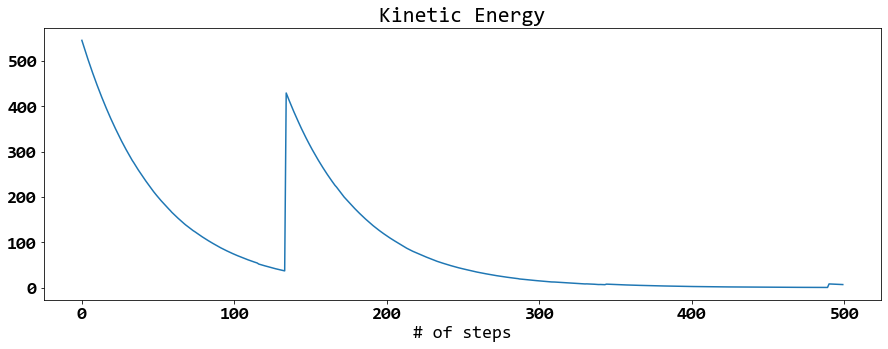

In [59]:
def KineticEnergy(Particles):
    KE = []
    NonStationary = []
    ''' Avoid stationary '''
    for p in Particles:
        if isinstance(p,Stationary):
            continue
        NonStationary.append(p)
    
    for frame in range(len(NonStationary[0].TVel)):
        kinetic = 0
        for p in NonStationary:
            kinetic += p.TVel[frame]*p.TVel[frame]
        KE.append(kinetic/len(NonStationary))
    return np.array(KE)

Kinetic = KineticEnergy(CrystalSimulation.Particles)
plt.title("Kinetic Energy")
plt.xlabel("# of steps")
plt.plot(Kinetic[500:])
plt.show()

In [60]:
C  = Camera(Orientation=Vector(1E-3,1E-3,-1),Position=Vector(0,0,100))
VG = VideoGenerator("Crystal_ZPers",CrystalSimulation.Particles,C)
VG.Generate(show_every=1)

'''
C  = Camera(Orientation=Vector(-1,0,0),Position=Vector(100,0,0))
VG = VideoGenerator("Crystal_XPers",CrystalSimulation.Particles,C)
VG.Generate(show_every=7)

C  = Camera(Orientation=Vector(0,-1,0),Position=Vector(0,100,0))
VG = VideoGenerator("Crystal_YPers",CrystalSimulation.Particles,C)
VG.Generate(show_every=7)
'''

[-0.14137736282335958, 0.14132687762852408] [-0.13993455364537158, 0.1427295708198417]
Generating Video for: Crystal_ZPers
99% : [=================================================] 


'\nC  = Camera(Orientation=Vector(-1,0,0),Position=Vector(100,0,0))\nVG = VideoGenerator("Crystal_XPers",CrystalSimulation.Particles,C)\nVG.Generate(show_every=7)\n\nC  = Camera(Orientation=Vector(0,-1,0),Position=Vector(0,100,0))\nVG = VideoGenerator("Crystal_YPers",CrystalSimulation.Particles,C)\nVG.Generate(show_every=7)\n'

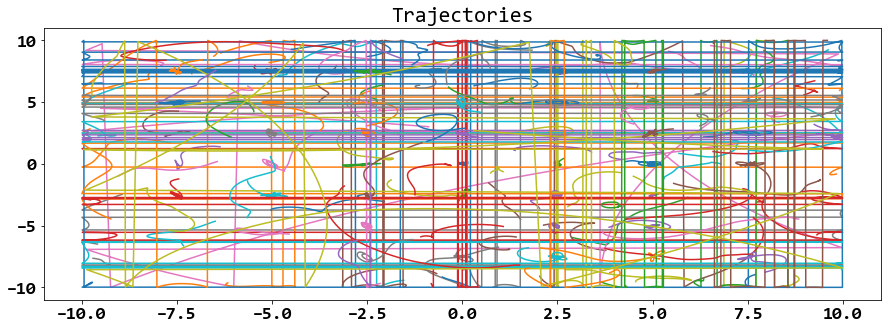

In [50]:
plt.clf()
plt.title("Trajectories")
for Particle in Electrons:
    x = [ P.x for P in Particle.TPos ]
    y = [ P.y for P in Particle.TPos ]
    plt.plot(x,y,label=Particle.Nam)
plt.show()